In [1]:
import os

repo_dir = os.environ.get("REPO_DIR")
code_dir = os.path.join(repo_dir, "code/")
data_dir = os.path.join(repo_dir, "data/")

os.chdir(code_dir)

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import pickle
import sklearn 
import sys
import pandas as pd
from importlib import reload

from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import seaborn as sns

from mosaiks.utils.imports import *

# Key prediction functions are here
from prediction_utils import (X_matrix_to_demeaned_X, df_to_demeaned_y_vars,
                              get_within_perf_from_kfold_dict, cv_solve, solver_kwargs,
                            get_train_idxs)
                              
from prediction_utils import make_train_pred_scatterplot as make_scatterplot

env variable MOSAIKS_HOME not defined; setting to: "/home/lsherman/code_luke/hdi_downscaling"
If not desired, please reset os.environ["MOSAIKS_NAME"]


#  Train HDI, IWI, and other ADM0/ADM1 level models
In this notebook we train ADM0 and ADM1 models and then evaluate at the same scale. Files needed to replicate this analysis are all included in the GitHub repository.

## Read in Xs and Ys -- and subset to training data set

### Read in MOSAIKS/RCF Xs

These daytime image feature files are included in the GitHub repository. They are also available at [mosaiks.org](mosaiks.org).

In [2]:
adm1_X = pd.read_pickle(
(data_dir + "features/mosaiks_features/"
"GDL_ADM1_polygon_X_creation_pop_weight=True.p")).drop(columns="GDLCODE")

adm0_X = pd.read_pickle((data_dir + "features/mosaiks_features/"
"GDL_ADM0_polygon_X_creation_pop_weight=True.p"))

adm1_X.head()

X_0       X_1       X_2       X_3       X_4       X_5       X_6  \
GDLCODE                                                                         
AFGr101  0.296243  0.566399  0.132676  0.376191  0.423434  0.611262  0.104580   
AFGr102  0.205197  0.528473  0.034544  0.642563  0.322423  0.370223  0.046795   
AFGr103  0.178888  0.375205  0.067020  0.224368  0.260576  0.442619  0.085794   
AFGr104  0.231737  0.581338  0.050665  0.712425  0.370986  0.375820  0.049962   
AFGr105  0.185107  0.498972  0.036417  0.607406  0.300143  0.372042  0.055738   

              X_7       X_8       X_9  ...    X_3990    X_3991    X_3992  \
GDLCODE                                ...                                 
AFGr101  0.236502  0.300176  0.596828  ...  0.352432  0.210764  0.604246   
AFGr102  0.057652  0.595370  0.398343  ...  0.110953  0.043917  0.170425   
AFGr103  0.156746  0.173106  0.396240  ...  0.202004  0.108165  0.392403   
AFGr104  0.083120  0.663175  0.438051  ...  0.122357  0.057889  0.219100   
AFGr105  0.074171  0.561080  0.390058  ...  0.112410  0.049431  0.194497   

           X_3993    X_3994    X_3995    X_3996    X_3997    X_3998    X_3999  
GDLCODE                                                                        
AFGr101  0.412964  0.256663  1.007759  1.779492  0.445359  0.605094  0.100552  
AFGr102  0.118251  0.105238  0.616474  0.700179  0.229152  0.464236  0.023037  
AFGr103  0.268643  0.158774  0.652044  1.217687  0.314744  0.400713  0.062426  
AFGr104  0.141557  0.102949  0.617183  0.799615  0.210456  0.434436  0.025360  
AFGr105  0.136292  0.107670  0.621367  0.713360  0.241749  0.480697  0.027199  

[5 rows x 4000 columns]

### Read in Y variables

These `Y` variables (HDI + component indicators) were cleaned and saved in the `/code/analysis/hdi_label_creation.ipynb` notebook. It is not necessary to run this notebook, but we make replication code for data cleaning available.

In [3]:
raw = pd.read_pickle( (data_dir + "int/GDL_HDI/"
                     "HDI_indicators_and_indices_clean.p") ).loc[adm1_X.index]

raw_adm0 = pd.read_pickle( (data_dir + "int/GDL_HDI/"
                     "HDI_indicators_and_indices_adm0_clean.p") ).loc[adm0_X.index]


raw.head()

ISO_Code      Country   Level  \
GDLCODE                                 
AFGr101      AFG  Afghanistan  Subnat   
AFGr102      AFG  Afghanistan  Subnat   
AFGr103      AFG  Afghanistan  Subnat   
AFGr104      AFG  Afghanistan  Subnat   
AFGr105      AFG  Afghanistan  Subnat   

                                                    Region  Life expectancy  \
GDLCODE                                                                       
AFGr101  Central (Kabul Wardak Kapisa Logar Parwan Panj...            66.22   
AFGr102                Central Highlands (Bamyan Daikundi)            64.89   
AFGr103           East (Nangarhar Kunar Laghman Nooristan)            64.01   
AFGr104    North (Samangan Sar-e-Pul Balkh Jawzjan Faryab)            63.42   
AFGr105      North East (Baghlan Takhar Badakhshan Kunduz)            63.10   

         GNI per capita in thousands of US$ (2011 PPP)  \
GDLCODE                                                  
AFGr101                                          2.165   
AFGr102                                          1.318   
AFGr103                                          1.299   
AFGr104                                          2.065   
AFGr105                                          1.506   

         Expected years schooling  Mean years schooling  \
GDLCODE                                                   
AFGr101                     12.70                  6.55   
AFGr102                     12.30                  2.44   
AFGr103                      9.74                  4.38   
AFGr104                     11.30                  4.03   
AFGr105                      9.17                  3.15   

         Population size in millions  Sub-national HDI  Health index  \
GDLCODE                                                                
AFGr101                         7.12             0.574         0.711   
AFGr102                         0.90             0.484         0.691   
AFGr103                         3.01             0.478         0.677   
AFGr104                         6.97             0.516         0.668   
AFGr105                         5.33             0.461         0.663   

         Income index  Educational index   
GDLCODE                                    
AFGr101         0.464               0.572  
AFGr102         0.389               0.423  
AFGr103         0.387               0.417  
AFGr104         0.457               0.449  
AFGr105         0.410               0.360

### Read in NL features

These NL features are included in the GitHub repo. They are based off the DMSP-OLS data product. Replication code for creating NL features for these administrative polygons is in the `code/analysis/NL_feature_creation_and_other_NL_processing/nighlight_pop_weighted_features_for_hdi_labels_DMSP.ipynb` notebook.

In [4]:
filepath = (data_dir + "features/nl_features/GDL_HDI_polygons/"
"dmsp_nightlight_features_for_hdi_polygons_20_bins_GPW_pop_weighted.p")
nl = pd.read_pickle(filepath).loc[adm1_X.index]

filepath = (data_dir + "features/nl_features/GDL_ADM0_polygons/"
            "dmsp_nightlight_features_for_adm0_polygons_20_bins_GPW_pop_weighted.p")
nl_adm0 = pd.read_pickle(filepath)

nl.head()

perc_pixels_in_bin_0  perc_pixels_in_bin_1  perc_pixels_in_bin_2  \
GDLCODE                                                                     
AFGr101                   0.0              0.341528              0.097743   
AFGr102                   0.0              0.998608              0.000806   
AFGr103                   0.0              0.867237              0.029551   
AFGr104                   0.0              0.859081              0.022181   
AFGr105                   0.0              0.947870              0.023249   

         perc_pixels_in_bin_3  perc_pixels_in_bin_4  perc_pixels_in_bin_5  \
GDLCODE                                                                     
AFGr101              0.044700              0.023192              0.015027   
AFGr102              0.000549              0.000037              0.000000   
AFGr103              0.018464              0.013235              0.007652   
AFGr104              0.009918              0.004951              0.002039   
AFGr105              0.010579              0.006459              0.002854   

         perc_pixels_in_bin_6  perc_pixels_in_bin_7  perc_pixels_in_bin_8  \
GDLCODE                                                                     
AFGr101              0.019316              0.021764              0.013239   
AFGr102              0.000000              0.000000              0.000000   
AFGr103              0.004762              0.004039              0.006819   
AFGr104              0.000911              0.000853              0.000319   
AFGr105              0.001993              0.003257              0.000800   

         perc_pixels_in_bin_9  perc_pixels_in_bin_10  perc_pixels_in_bin_11  \
GDLCODE                                                                       
AFGr101              0.012001               0.019940               0.013452   
AFGr102              0.000000               0.000000               0.000000   
AFGr103              0.002565               0.009129               0.005761   
AFGr104              0.000441               0.000663               0.002035   
AFGr105              0.000932               0.000670               0.000335   

         perc_pixels_in_bin_12  perc_pixels_in_bin_13  perc_pixels_in_bin_14  \
GDLCODE                                                                        
AFGr101               0.018973               0.022304               0.014314   
AFGr102               0.000000               0.000000               0.000000   
AFGr103               0.009349               0.006840               0.010498   
AFGr104               0.000410               0.005102               0.004575   
AFGr105               0.000586               0.000335               0.000084   

         perc_pixels_in_bin_15  perc_pixels_in_bin_16  perc_pixels_in_bin_17  \
GDLCODE                                                                        
AFGr101               0.020570               0.030971               0.040767   
AFGr102               0.000000               0.000000               0.000000   
AFGr103               0.004100               0.000000               0.000000   
AFGr104               0.008858               0.013081               0.009298   
AFGr105               0.000000               0.000000               0.000000   

         perc_pixels_in_bin_18  perc_pixels_in_bin_19  
GDLCODE                                                
AFGr101               0.063798               0.166403  
AFGr102               0.000000               0.000000  
AFGr103               0.000000               0.000000  
AFGr104               0.012724               0.042560  
AFGr105               0.000000               0.000000

### Add iwi as an outcome

These IWI data are downloaded from the [Global Data Lab](https://globaldatalab.org/areadata/table/iwi/) for the year 2018. We simly left join to the other indicators in the code below.

In [5]:
iwi_path = (data_dir + "raw/GDL_IWI/"
"GDL-Mean-International-Wealth-Index-(IWI)-score-of-region-data.csv")

iwi = pd.read_csv(iwi_path).set_index("GDLCODE").rename(columns = {"2018":"iwi"})

iwi_adm0 = iwi[iwi["Region"] == "Total"].set_index("ISO_Code")


In [6]:
## Join the available iwi observations with the training df
## Note that IWI has some missing observations, so we just have to drop those when we run the IWI models

raw = raw.join(iwi[["iwi"]],how = "left" )
raw_adm0 = raw_adm0.join(iwi_adm0[["iwi"]], how="left")

In [7]:
iwi_missings = raw["iwi"].isnull().sum()
print(f"IWI has {iwi_missings} fewer observations than HDI. Only {len(raw)-iwi_missings} observations of iwi are available.")

IWI has 622 fewer observations than HDI. Only 1107 observations of iwi are available.


### Subset to training data

In [8]:
train_idxs = get_train_idxs()

In [9]:
# Subset dense_df to training data

train_locs = raw["ISO_Code"].isin(train_idxs)


## Subset Y variables
train_df = raw.loc[train_locs]
train_df_adm0 = raw_adm0.loc[train_idxs]

# Subset MOSAIKS Xs
train_locs = raw["ISO_Code"].isin(train_idxs)
X_train = adm1_X.loc[train_locs]
X_train_adm0 = adm0_X.loc[train_idxs]

# Subset NL Xs
X_nl = nl.loc[train_df.index]
X_nl_adm0 = nl_adm0.loc[train_idxs]



In [10]:
train_df.head()

ISO_Code      Country   Level  \
GDLCODE                                 
AFGr101      AFG  Afghanistan  Subnat   
AFGr102      AFG  Afghanistan  Subnat   
AFGr103      AFG  Afghanistan  Subnat   
AFGr104      AFG  Afghanistan  Subnat   
AFGr105      AFG  Afghanistan  Subnat   

                                                    Region  Life expectancy  \
GDLCODE                                                                       
AFGr101  Central (Kabul Wardak Kapisa Logar Parwan Panj...            66.22   
AFGr102                Central Highlands (Bamyan Daikundi)            64.89   
AFGr103           East (Nangarhar Kunar Laghman Nooristan)            64.01   
AFGr104    North (Samangan Sar-e-Pul Balkh Jawzjan Faryab)            63.42   
AFGr105      North East (Baghlan Takhar Badakhshan Kunduz)            63.10   

         GNI per capita in thousands of US$ (2011 PPP)  \
GDLCODE                                                  
AFGr101                                          2.165   
AFGr102                                          1.318   
AFGr103                                          1.299   
AFGr104                                          2.065   
AFGr105                                          1.506   

         Expected years schooling  Mean years schooling  \
GDLCODE                                                   
AFGr101                     12.70                  6.55   
AFGr102                     12.30                  2.44   
AFGr103                      9.74                  4.38   
AFGr104                     11.30                  4.03   
AFGr105                      9.17                  3.15   

         Population size in millions  Sub-national HDI  Health index  \
GDLCODE                                                                
AFGr101                         7.12             0.574         0.711   
AFGr102                         0.90             0.484         0.691   
AFGr103                         3.01             0.478         0.677   
AFGr104                         6.97             0.516         0.668   
AFGr105                         5.33             0.461         0.663   

         Income index  Educational index    iwi  
GDLCODE                                          
AFGr101         0.464               0.572  58.0  
AFGr102         0.389               0.423  41.8  
AFGr103         0.387               0.417  41.3  
AFGr104         0.457               0.449  56.5  
AFGr105         0.410               0.360  46.2

In [11]:
X_train.head()

X_0       X_1       X_2       X_3       X_4       X_5       X_6  \
GDLCODE                                                                         
AFGr101  0.296243  0.566399  0.132676  0.376191  0.423434  0.611262  0.104580   
AFGr102  0.205197  0.528473  0.034544  0.642563  0.322423  0.370223  0.046795   
AFGr103  0.178888  0.375205  0.067020  0.224368  0.260576  0.442619  0.085794   
AFGr104  0.231737  0.581338  0.050665  0.712425  0.370986  0.375820  0.049962   
AFGr105  0.185107  0.498972  0.036417  0.607406  0.300143  0.372042  0.055738   

              X_7       X_8       X_9  ...    X_3990    X_3991    X_3992  \
GDLCODE                                ...                                 
AFGr101  0.236502  0.300176  0.596828  ...  0.352432  0.210764  0.604246   
AFGr102  0.057652  0.595370  0.398343  ...  0.110953  0.043917  0.170425   
AFGr103  0.156746  0.173106  0.396240  ...  0.202004  0.108165  0.392403   
AFGr104  0.083120  0.663175  0.438051  ...  0.122357  0.057889  0.219100   
AFGr105  0.074171  0.561080  0.390058  ...  0.112410  0.049431  0.194497   

           X_3993    X_3994    X_3995    X_3996    X_3997    X_3998    X_3999  
GDLCODE                                                                        
AFGr101  0.412964  0.256663  1.007759  1.779492  0.445359  0.605094  0.100552  
AFGr102  0.118251  0.105238  0.616474  0.700179  0.229152  0.464236  0.023037  
AFGr103  0.268643  0.158774  0.652044  1.217687  0.314744  0.400713  0.062426  
AFGr104  0.141557  0.102949  0.617183  0.799615  0.210456  0.434436  0.025360  
AFGr105  0.136292  0.107670  0.621367  0.713360  0.241749  0.480697  0.027199  

[5 rows x 4000 columns]

### Save train df, useful later

In [12]:
train_df.to_pickle(data_dir + "model_data/full_training_df.p")

### Create demeaned feature sets

This demeaned Xs are needed for the within-country models.

In [13]:
X_demeaned = X_matrix_to_demeaned_X(X_train)
X_demeaned_nl = X_matrix_to_demeaned_X(X_nl)

### Set some basic solve parameters:

In [14]:
tasks = ['Sub-national HDI', 
         "Life expectancy", 
         "Mean years schooling", 
         "Expected years schooling",
         "GNI per capita in thousands of US$ (2011 PPP)",
         "iwi"
        ]

log_task = {'Sub-national HDI': False,
              "Life expectancy": False,
               "Mean years schooling" : False,
               "Expected years schooling" : False,
               "GNI per capita in thousands of US$ (2011 PPP)" : True,
               "iwi":False}


rescale_lambdas = np.hstack([1,(np.logspace(-3,6,8)**.3)])
rescale_lambdas.sort()


model_directory = data_dir + "model_data/"

In [15]:
def get_idxs_without_adm0_observations(df, country_col = "ISO_Code"):
    """
    For country-demeaned outcomes, we want to remove all the ADM0 level observations. 
    
    In other words, if there is no within-country we shouldn't keep this as training data
    
    """
    col = tasks[0]
    g = df.groupby("ISO_Code")
    
    country_counts = train_df.groupby(country_col)[col].count() 

    adm0_idxs = country_counts[country_counts == 1].index
    adm1_idxs = df.reset_index().set_index("ISO_Code").drop(adm0_idxs).set_index(df.index.name).index
    
    assert len(adm1_idxs) == len(df)-len(adm0_idxs)
    
    return adm1_idxs

# Begin running solves

### Cross country model  - RCF only

Sub-national HDI
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting Sub-national HDI...
Life expectancy
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting Life expectancy...
Mean years schooling
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting Mean years schooling...
Expected years schooling
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting Expected years schooling...
GNI per capita in thousands of US$ (2011 PPP)
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting GNI per capita in thousands of US$ (2011 PPP)...
iwi
499
Training model...

on fold (of 5): 0 

/shares/maps100/code/code_LS/hdi_downscaling/code/analysis/prediction_utils.py:231: UserWarning: 499 missing values for outcome, these will be dropped
  warnings.warn(f"{num_missings} missing values for outcome, these will be dropped")


1 2 3 4 

Plotting iwi...


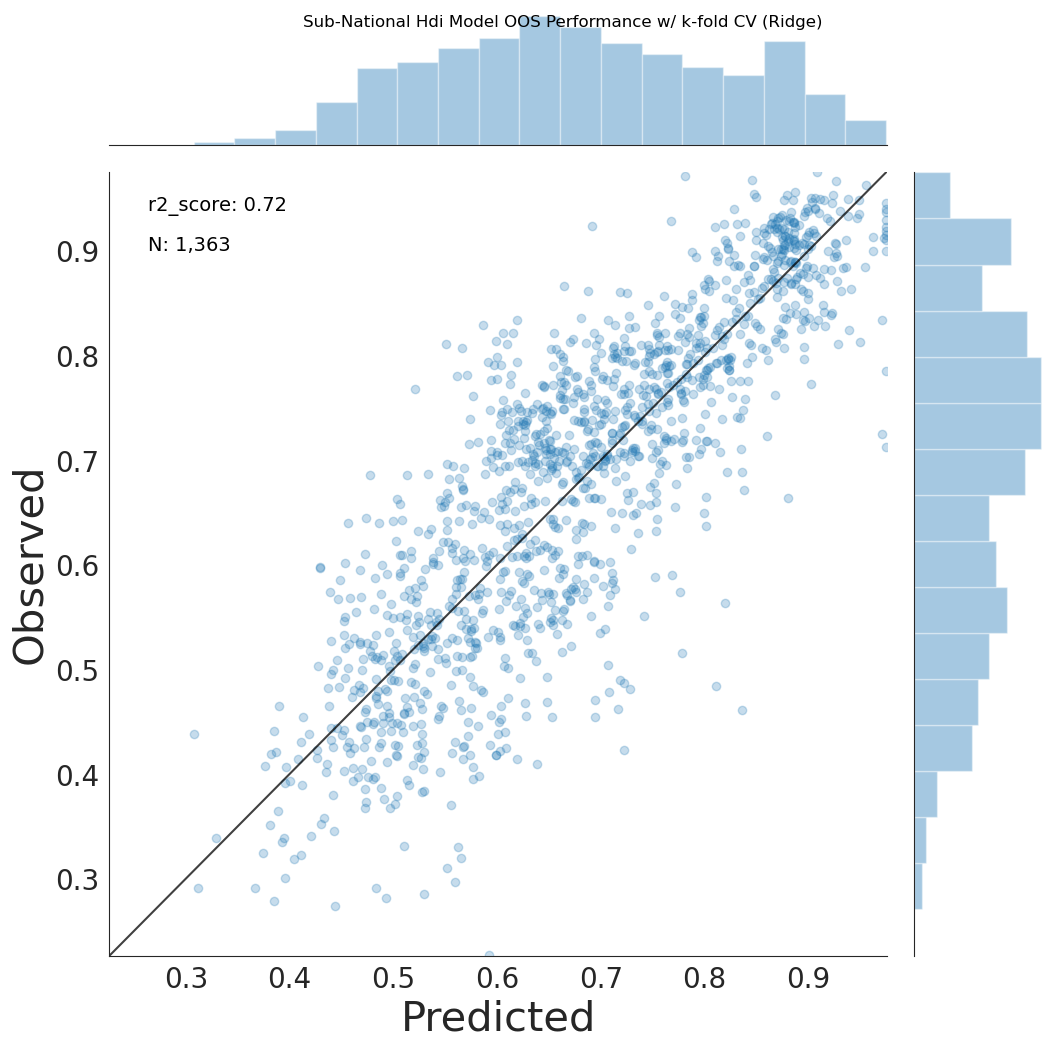

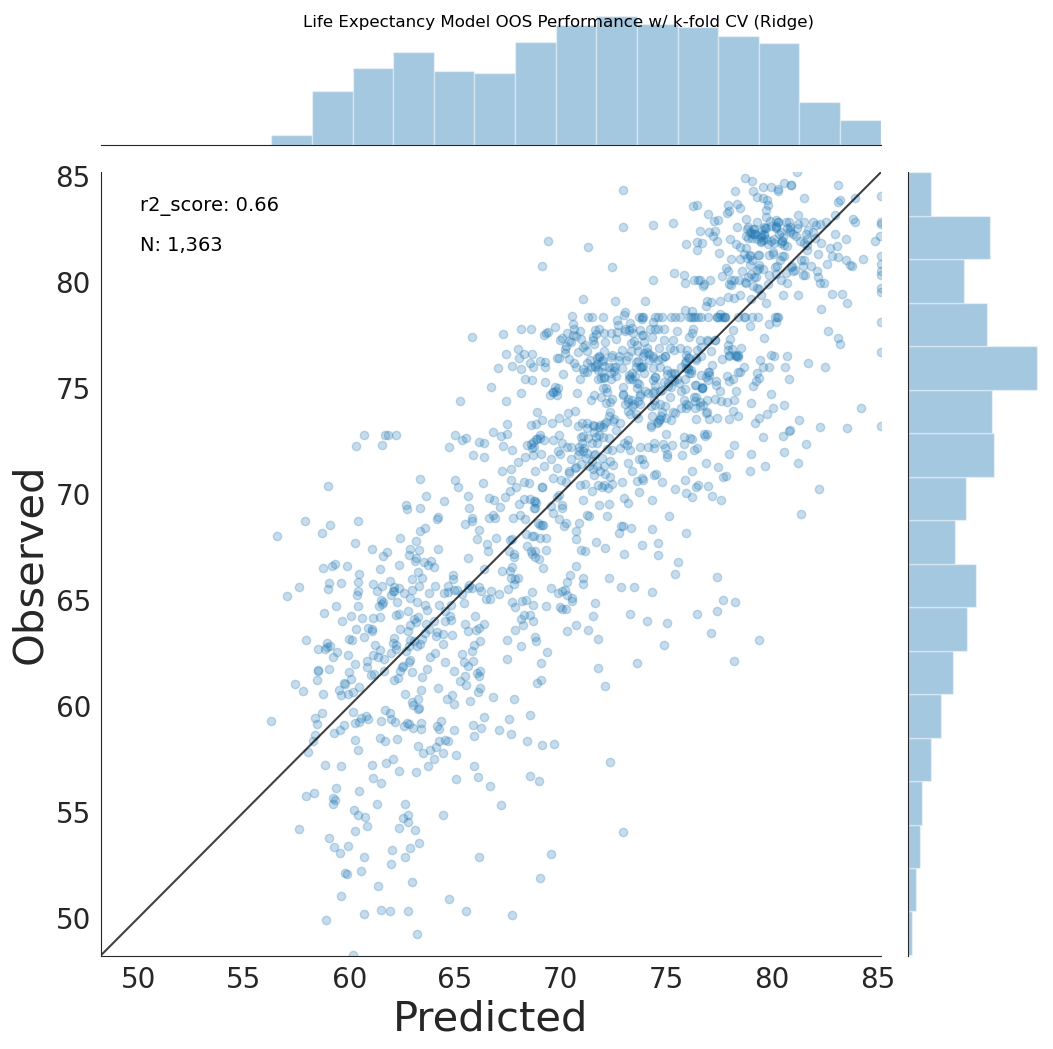

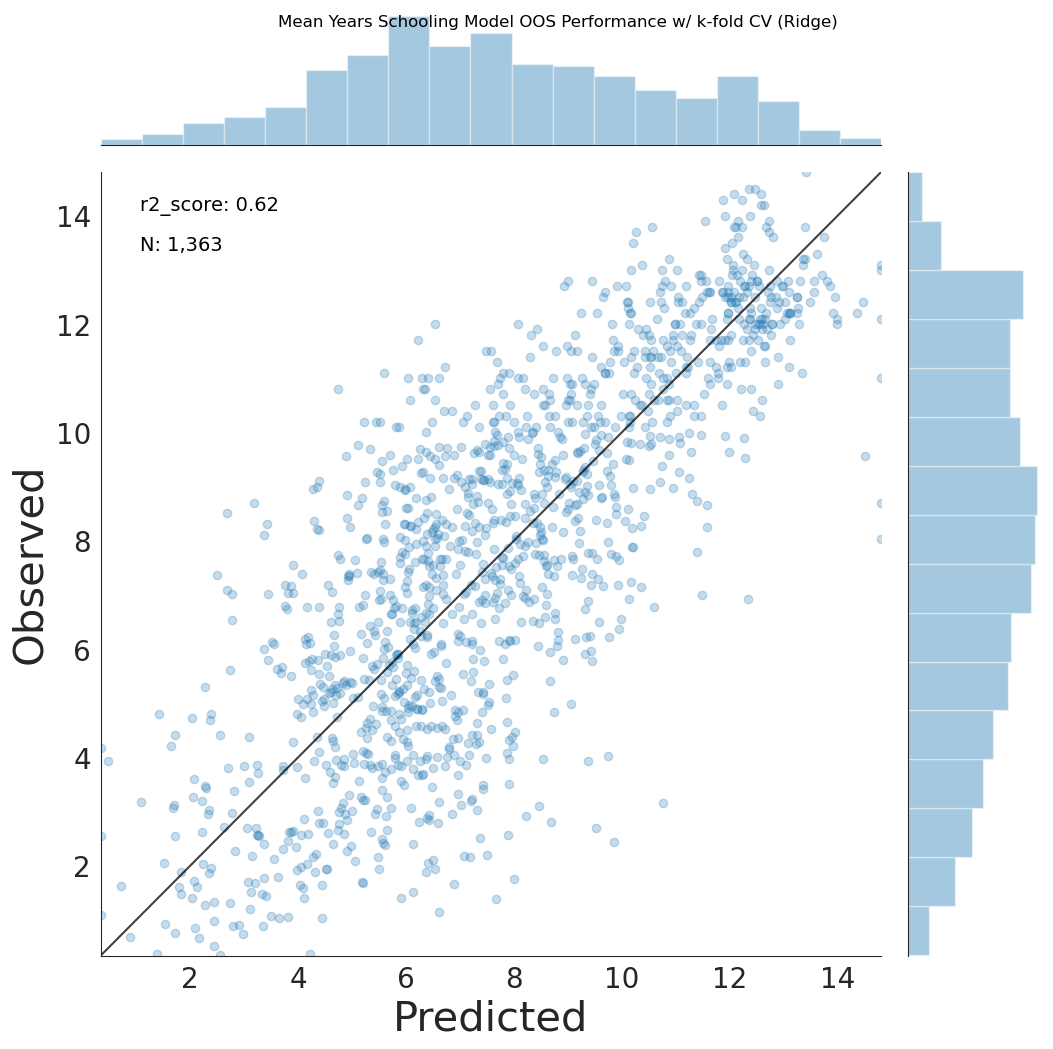

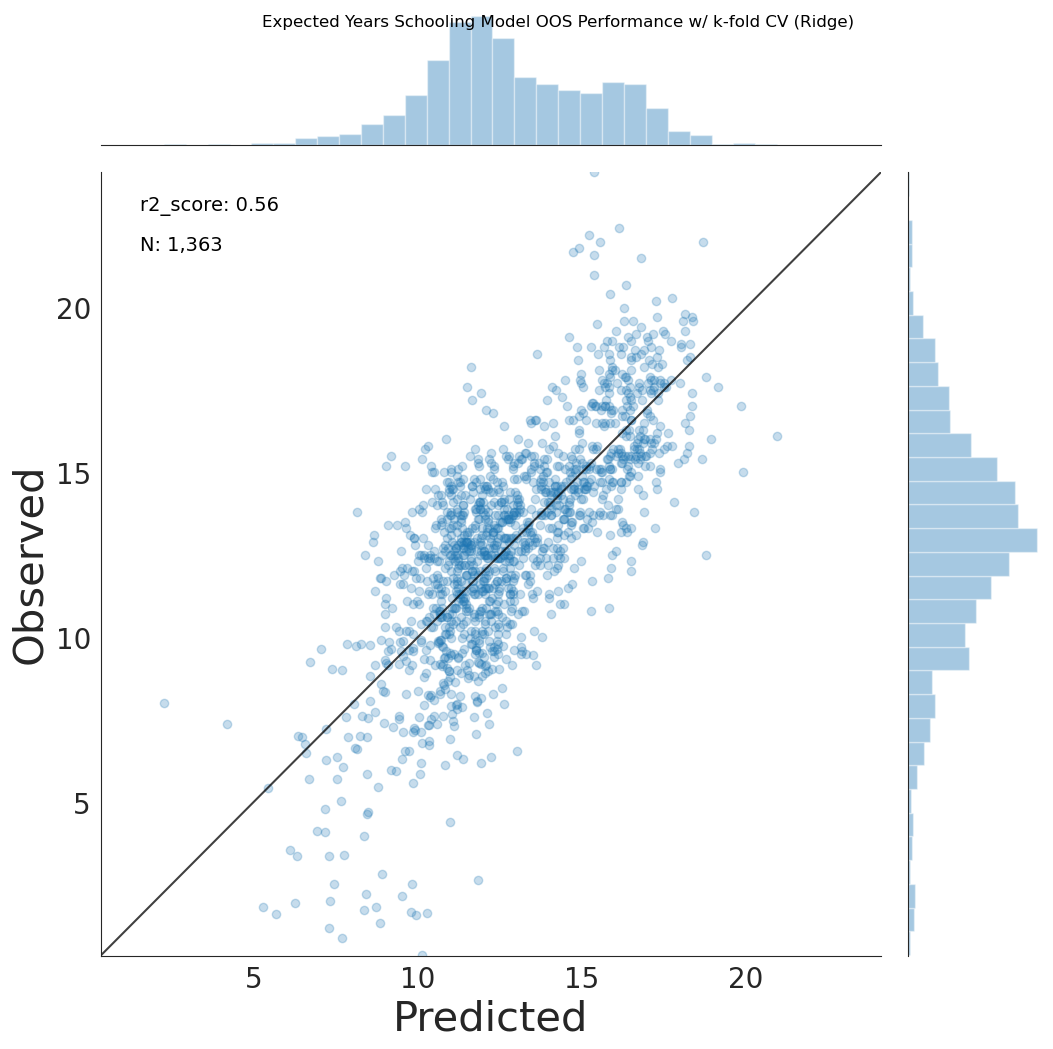

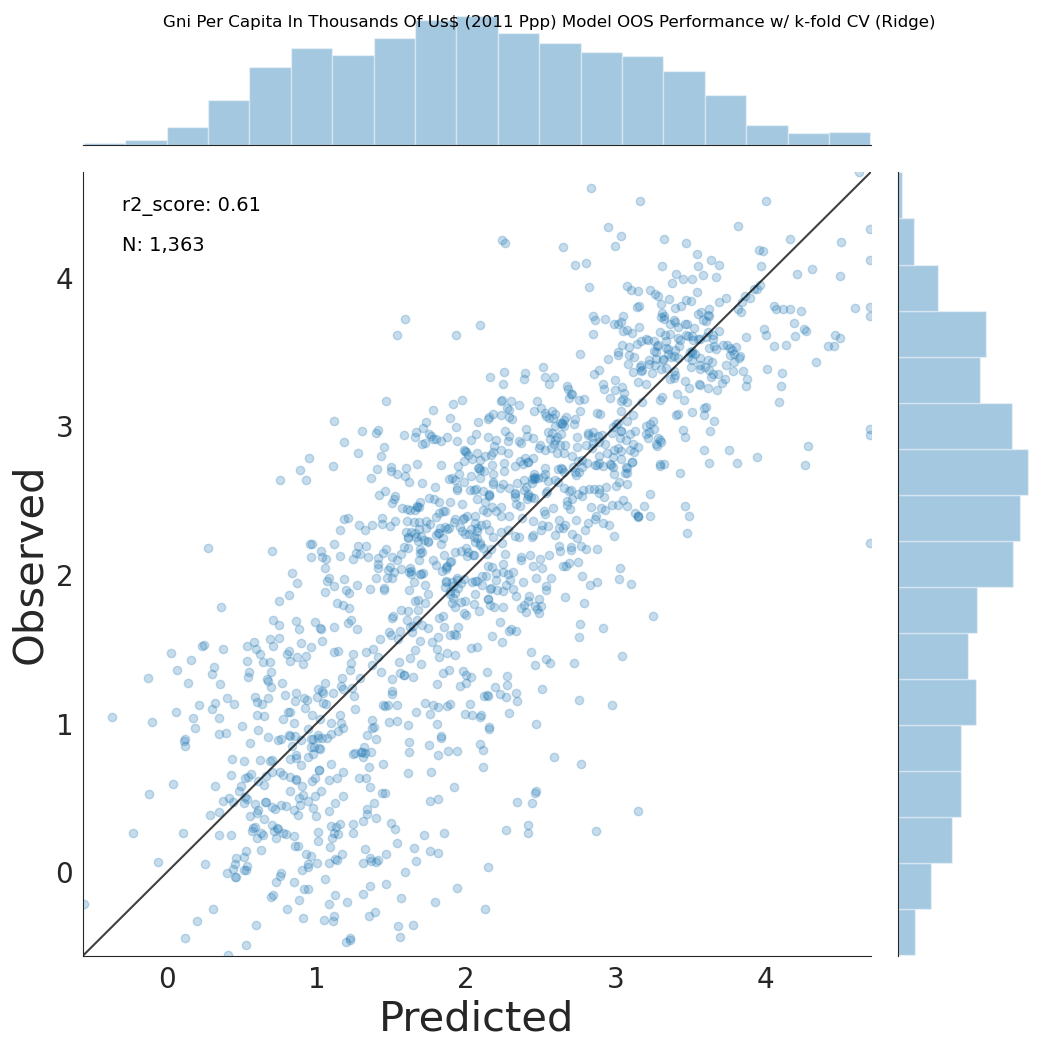

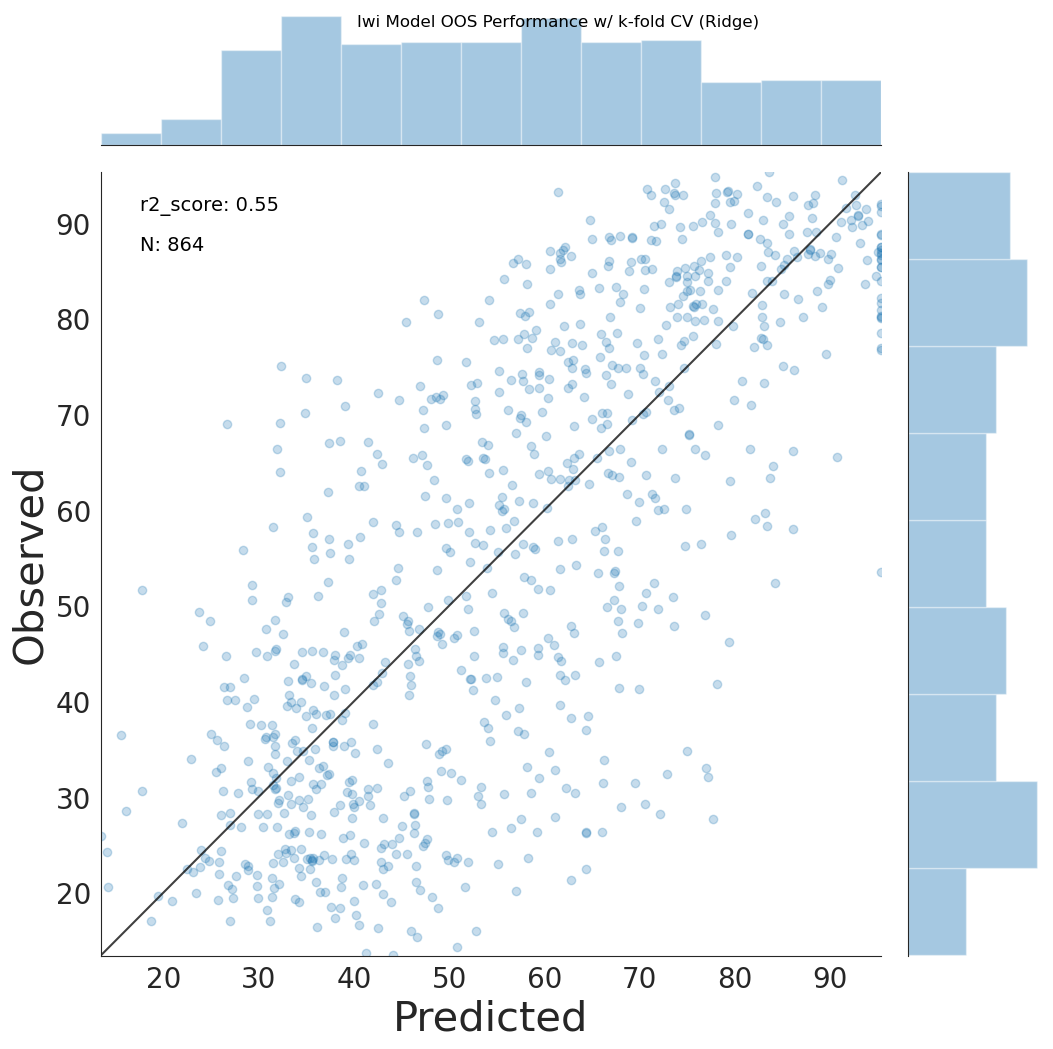

In [16]:
kfold_dict = {}

for task in tasks:
    Y_train = train_df[task]
    if log_task[task]:
        Y_train = np.log(Y_train)
    kfold_dict[task]  = cv_solve(task,
                                    X_train,
                                    Y_train,
                                    clip_bounds = [np.min(Y_train), np.max(Y_train)], 
                                 country_fold = True)

In [17]:
outpath = (model_directory+
           "cross_country_kfold_solve_all_outcomes_country_fold_DENSE_pop_weight=True.pkl")
pickle.dump(kfold_dict, open(outpath, "wb"))
kfold_dict = pickle.load(open(outpath, "rb"))

cc_rcf_perf_dict = {}
n_adm1 = {}

for task in tasks:
    cc_rcf_perf_dict[task] = get_within_perf_from_kfold_dict(kfold_dict, task, metric="ALL")
    n_adm1[task] = len(np.hstack(kfold_dict[task]["locations_test"]))
    

### Within country model (demeaned outcomes) - RCF only

Zero obs dropped = 19
Sub-national HDI
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting Sub-national HDI...
Zero obs dropped = 19
Life expectancy
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting Life expectancy...
Zero obs dropped = 19
Mean years schooling
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting Mean years schooling...
Zero obs dropped = 19
Expected years schooling
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting Expected years schooling...
Zero obs dropped = 19
GNI per capita in thousands of US$ (2011 PPP)
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting GNI per capita in thousands of US$ (2011 PPP)...
Zero obs dropped = 19
iwi
481
Training model...

on fold (of 5): 0 

/shares/maps100/code/code_LS/hdi_downscaling/code/analysis/prediction_utils.py:231: UserWarning: 481 missing values for outcome, these will be dropped
  warnings.warn(f"{num_missings} missing values for outcome, these will be dropped")


1 2 3 4 

Plotting iwi...


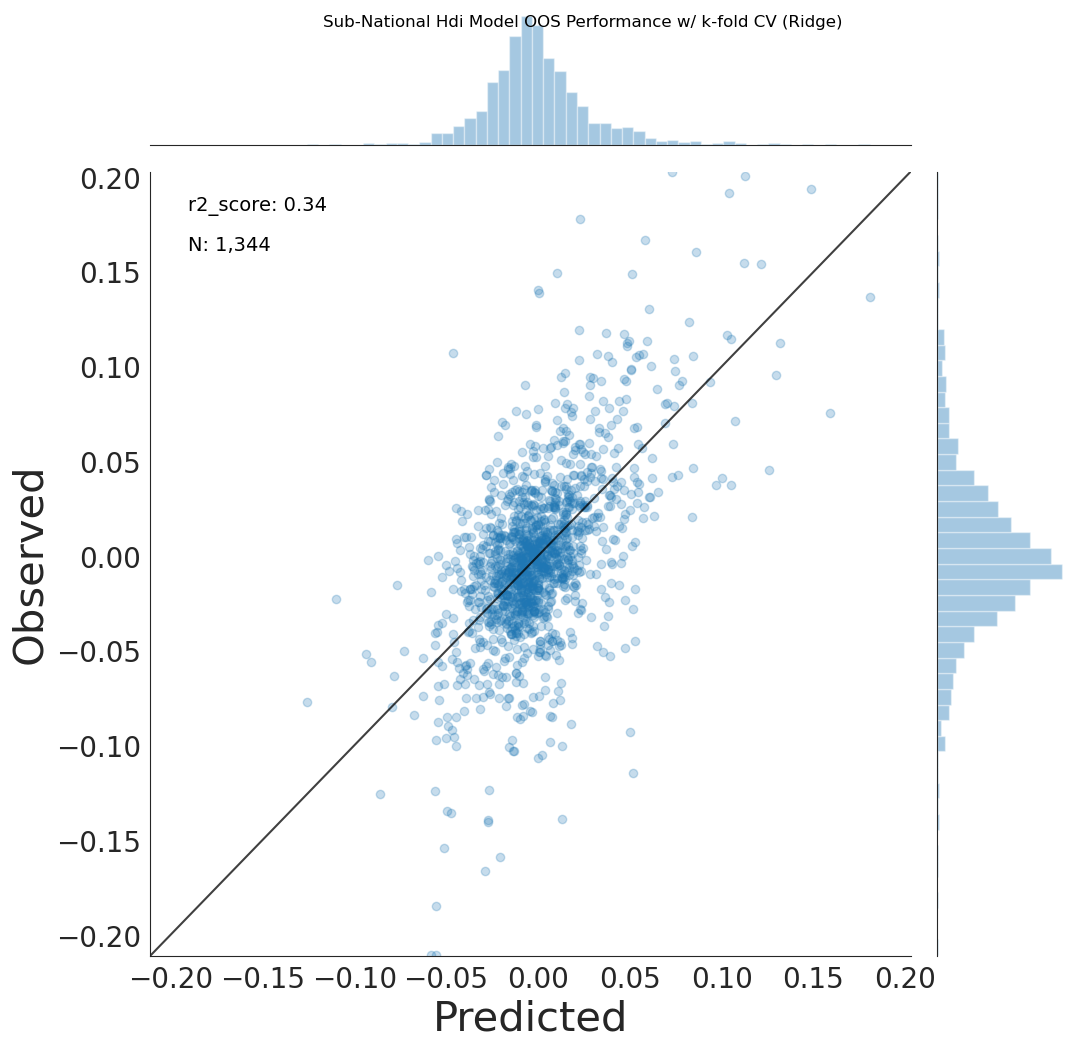

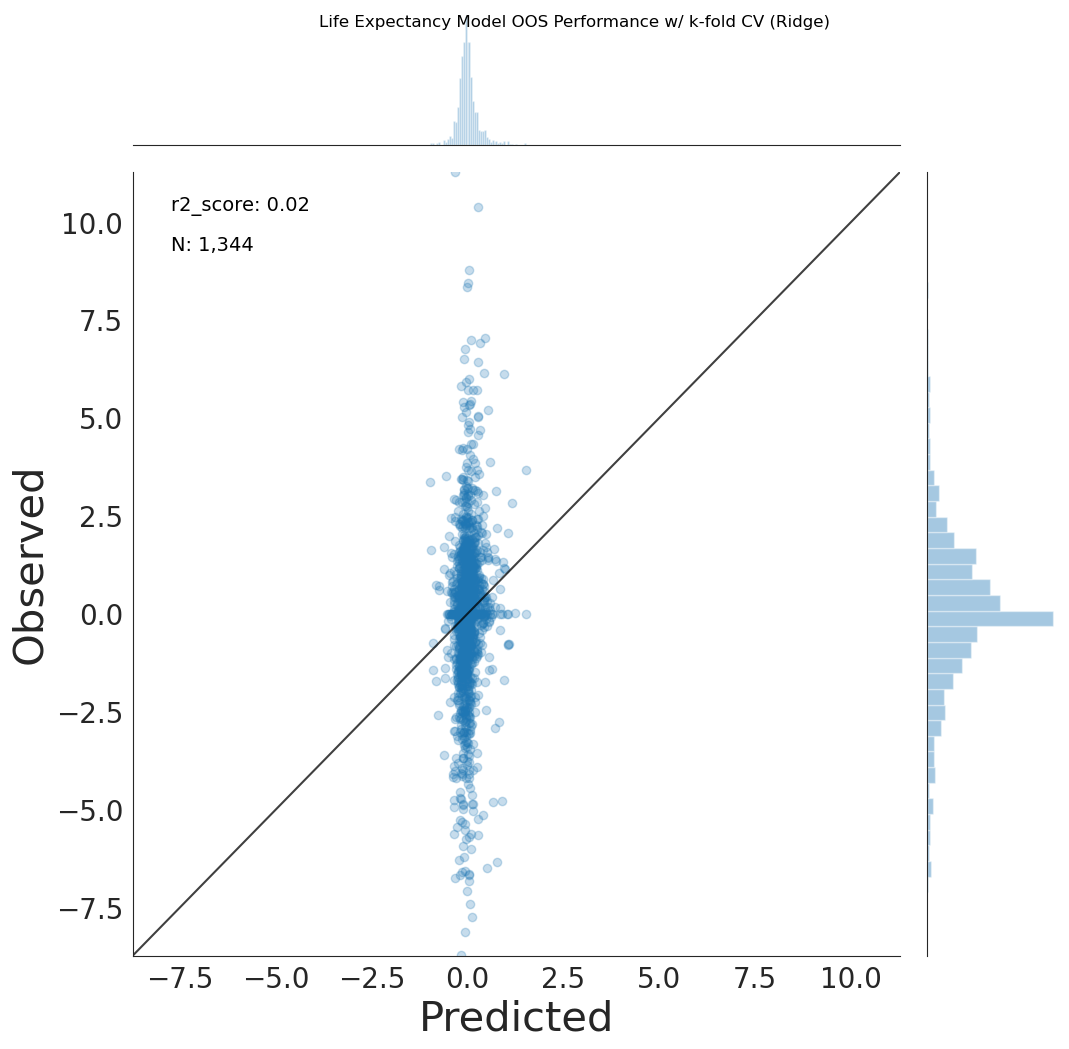

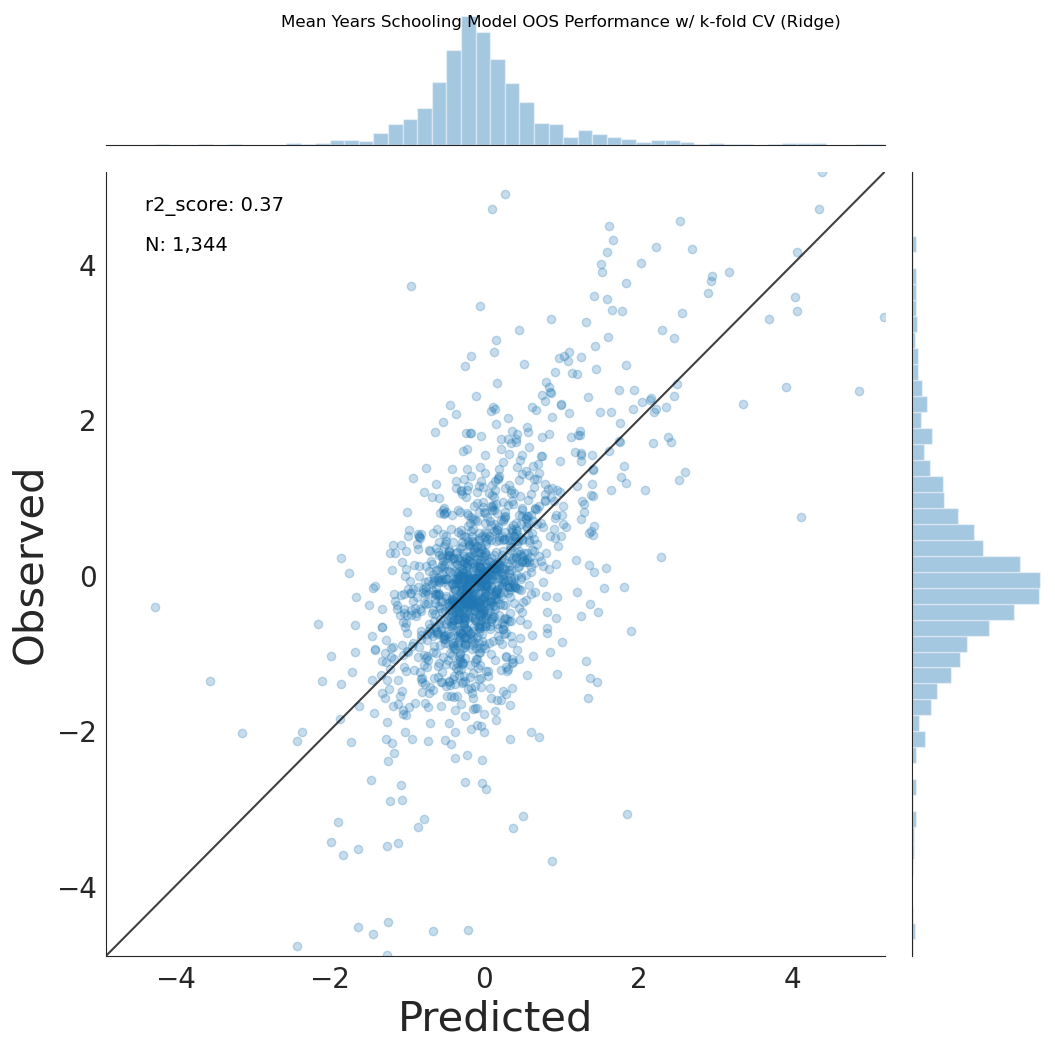

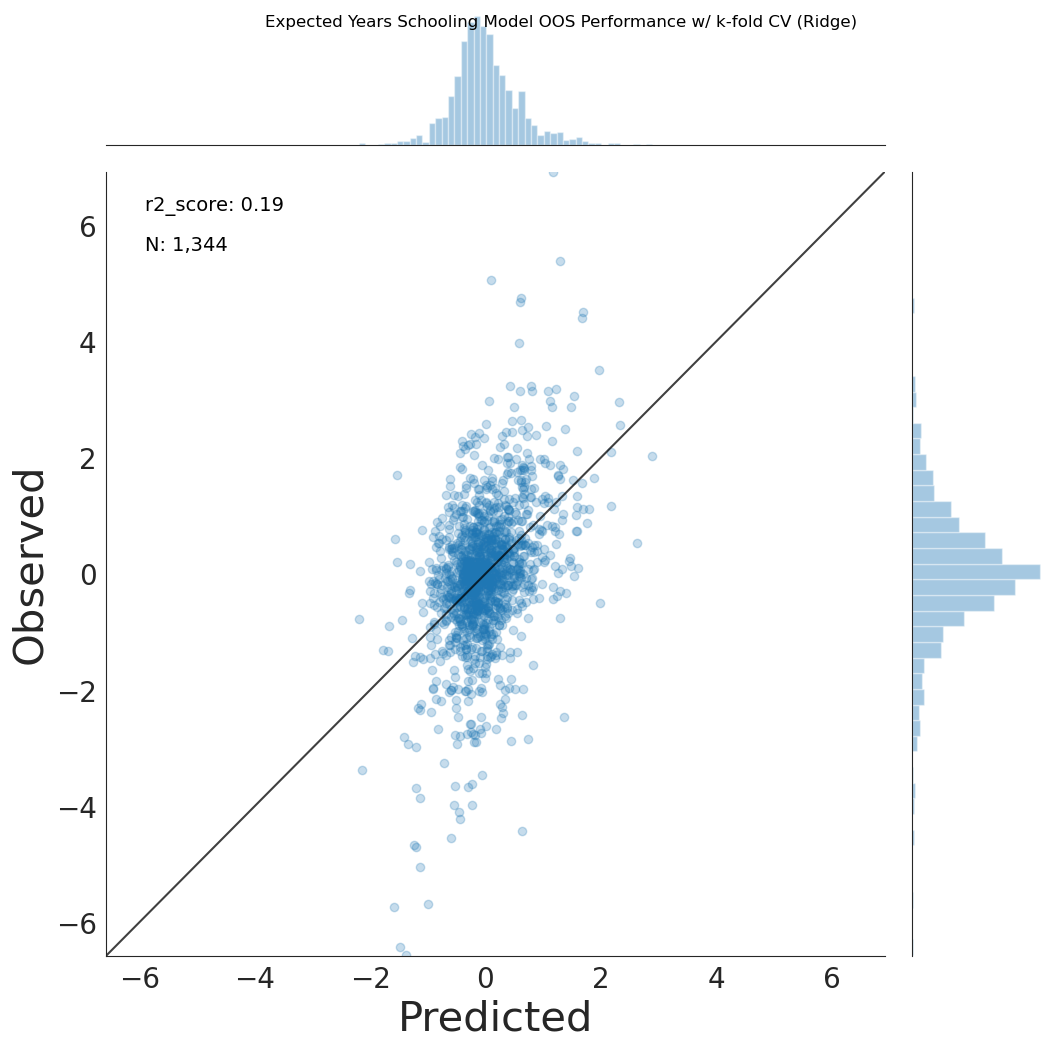

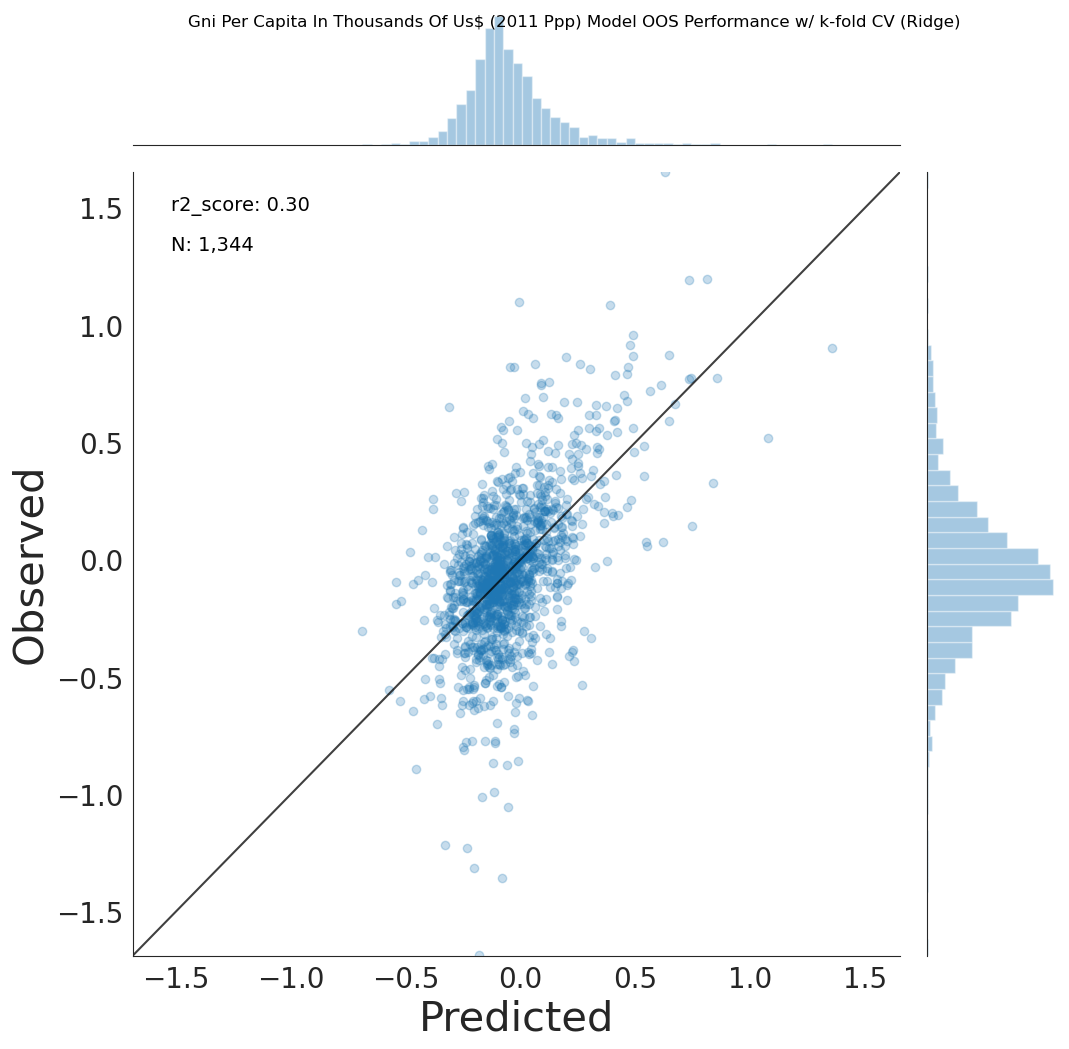

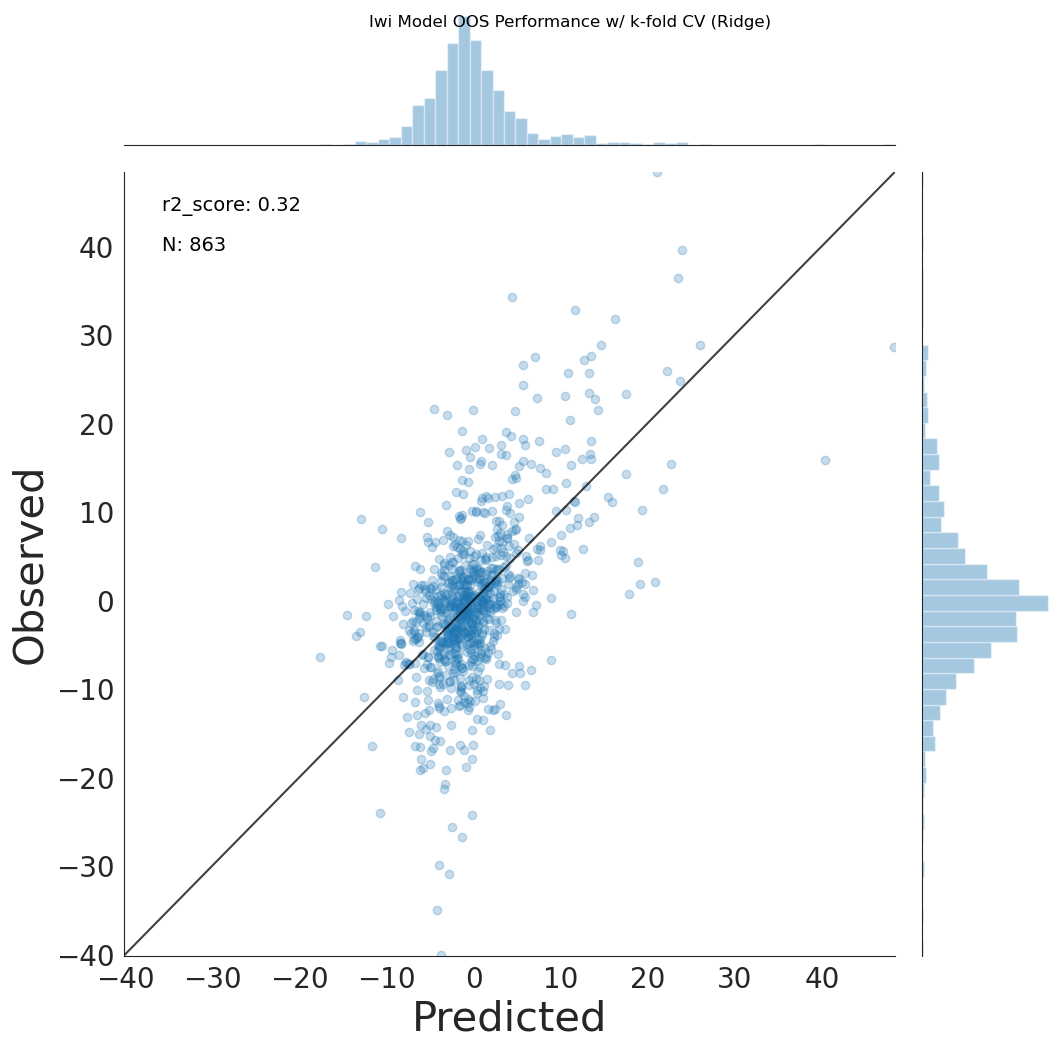

In [18]:
demeaned_kfold_dict = {}

for task in tasks:
    Y_demeaned = df_to_demeaned_y_vars(task, train_df, log_before_diff = log_task[task])
    
    ##Let's drop Y observations that do not have any within country variation. There is nothing to learn from these:
    keep_indxs = get_idxs_without_adm0_observations(train_df)
    Y_demeaned = Y_demeaned.loc[keep_indxs]
    X_demeaned_dropped = X_demeaned.loc[keep_indxs]
    
    print("Zero obs dropped =",(len(X_demeaned) - len(X_demeaned_dropped)))
    
    demeaned_kfold_dict[task]  = cv_solve(
        task,
        X_demeaned_dropped,
        Y_demeaned,
        clip_bounds = [np.min(Y_demeaned), np.max(Y_demeaned)],
        country_fold = True)

In [19]:
outpath = (model_directory+
           "within_country_demeaned_kfold_solve_all_outcomes_country_fold_DENSE_pop_weight=True.pkl")
pickle.dump(demeaned_kfold_dict, open(outpath, "wb"))
demeaned_kfold_dict = pickle.load(open(outpath, "rb"))


demean_rcf_perf_dict = {}

n_demean = {}
for task in tasks:
    demean_rcf_perf_dict[task] = get_within_perf_from_kfold_dict(demeaned_kfold_dict, task, metric="ALL",
                                                                demeaned_input=True, not_demeaned_df=train_df,
                                                                 logged=log_task[task])
    n_demean[task] =  len(np.hstack(demeaned_kfold_dict[task]["locations_test"]))

### NL only model 

Sub-national HDI
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting Sub-national HDI...
Life expectancy
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting Life expectancy...
Mean years schooling
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting Mean years schooling...
Expected years schooling
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting Expected years schooling...
GNI per capita in thousands of US$ (2011 PPP)
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting GNI per capita in thousands of US$ (2011 PPP)...
iwi
499
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting iwi...


/shares/maps100/code/code_LS/hdi_downscaling/code/analysis/prediction_utils.py:231: UserWarning: 499 missing values for outcome, these will be dropped
  warnings.warn(f"{num_missings} missing values for outcome, these will be dropped")


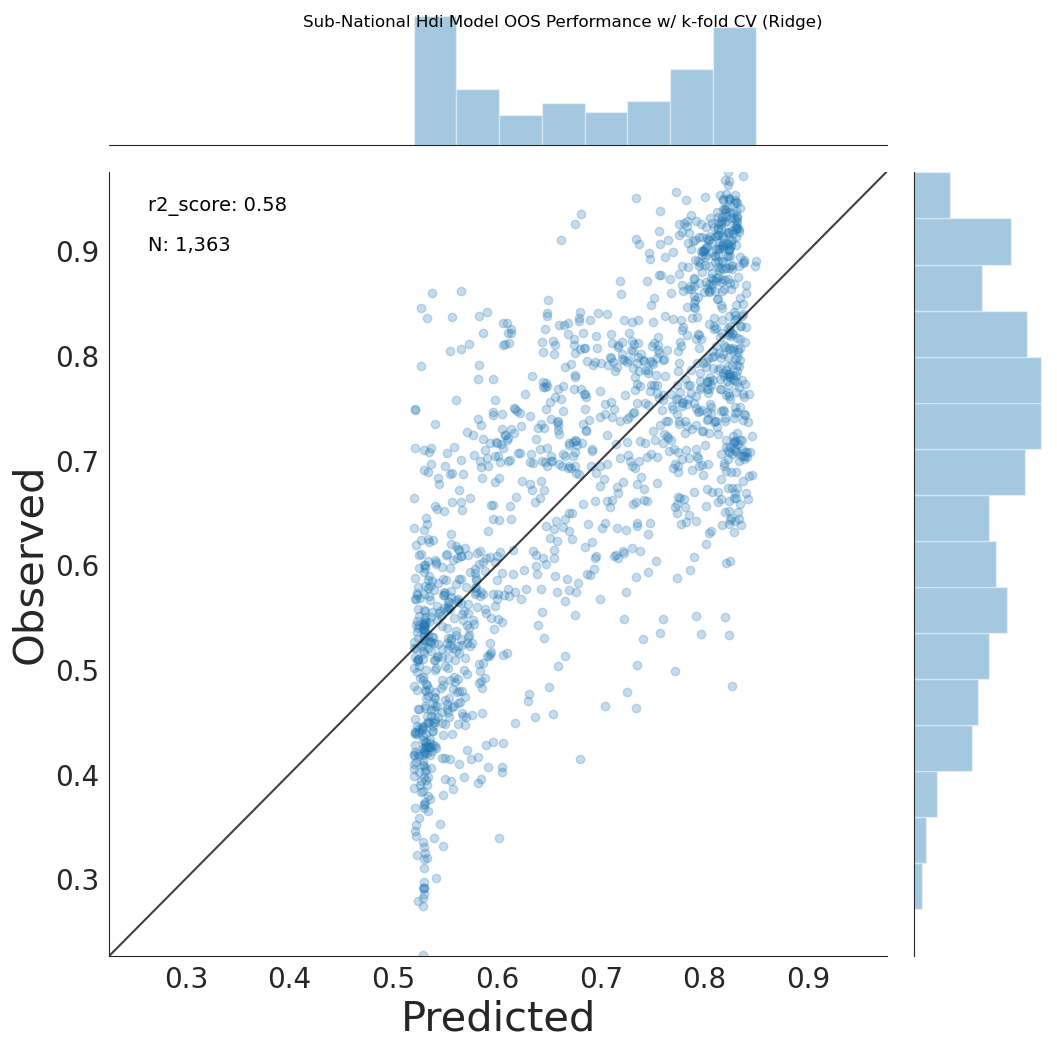

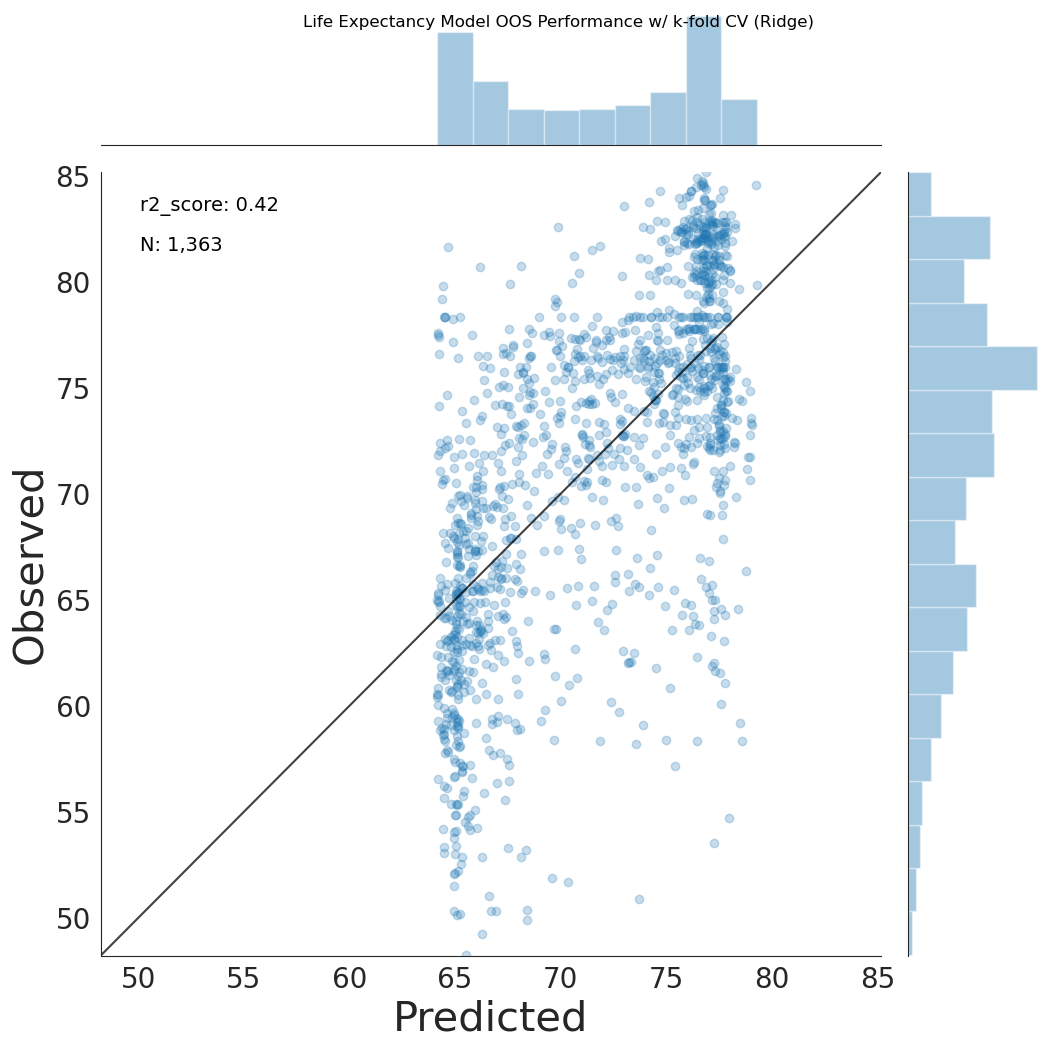

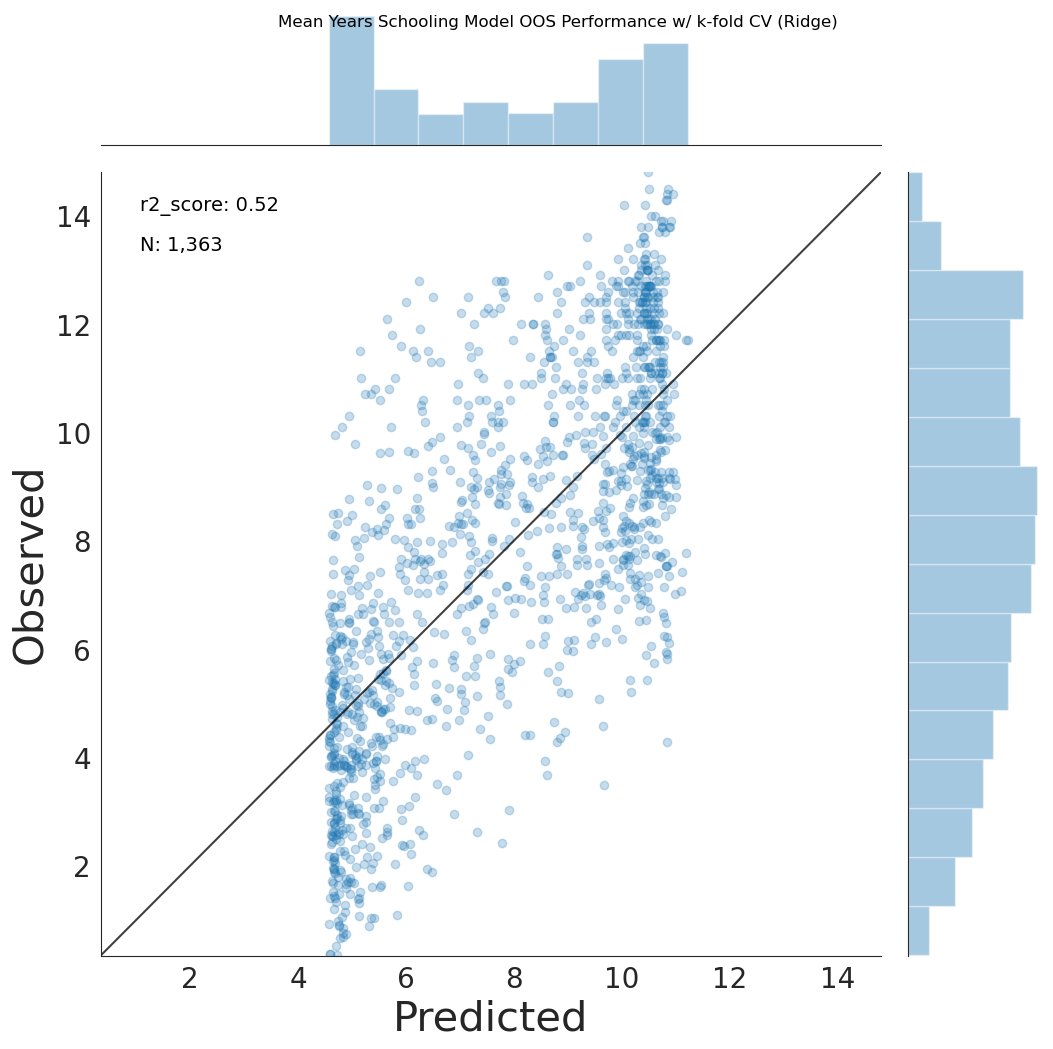

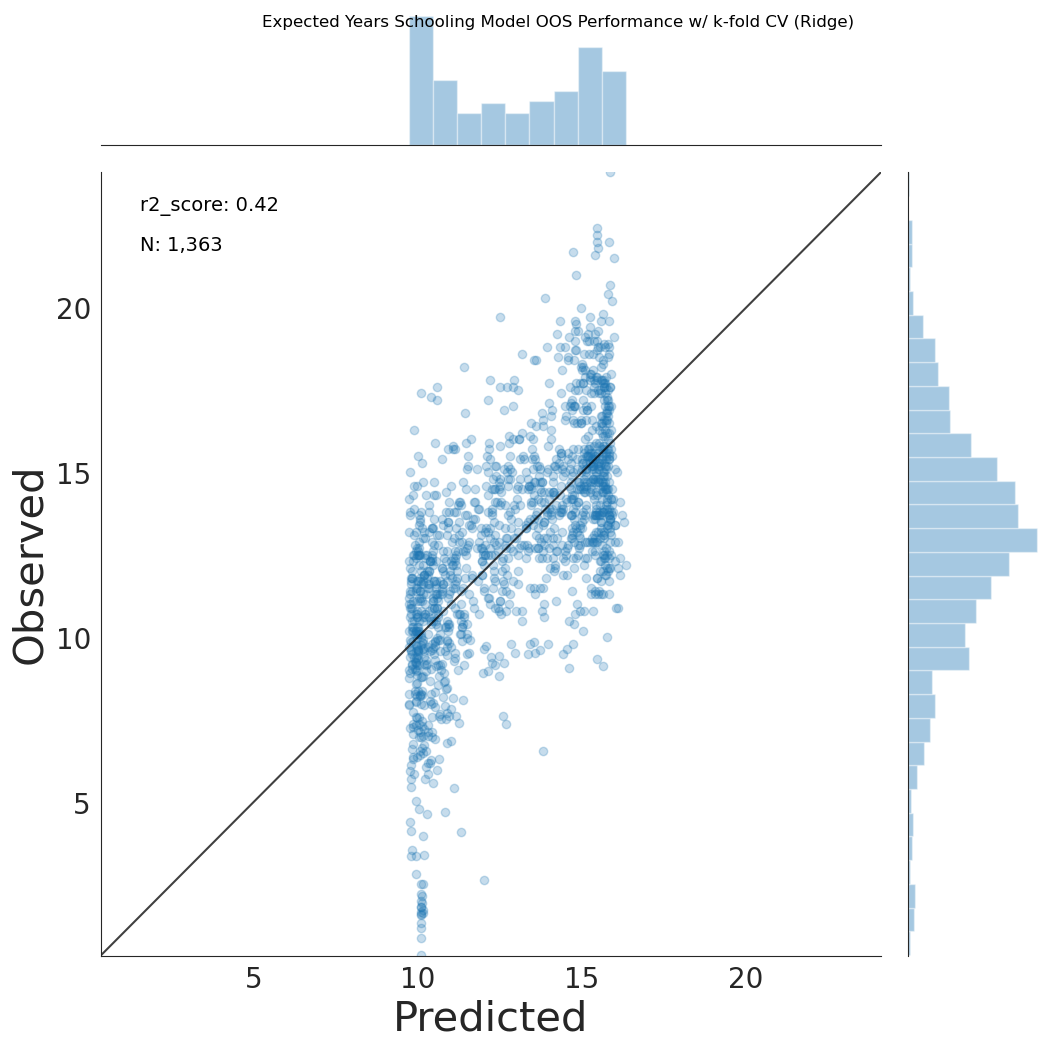

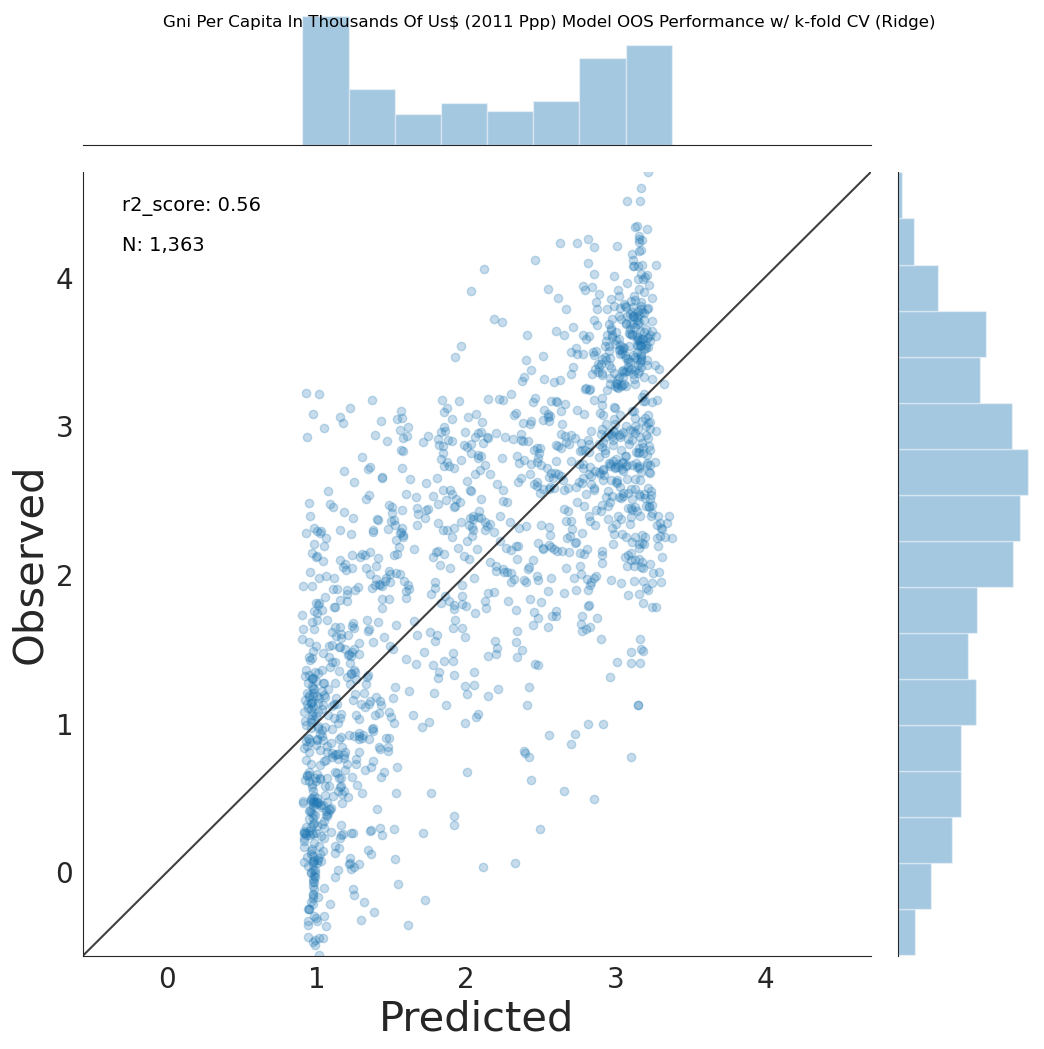

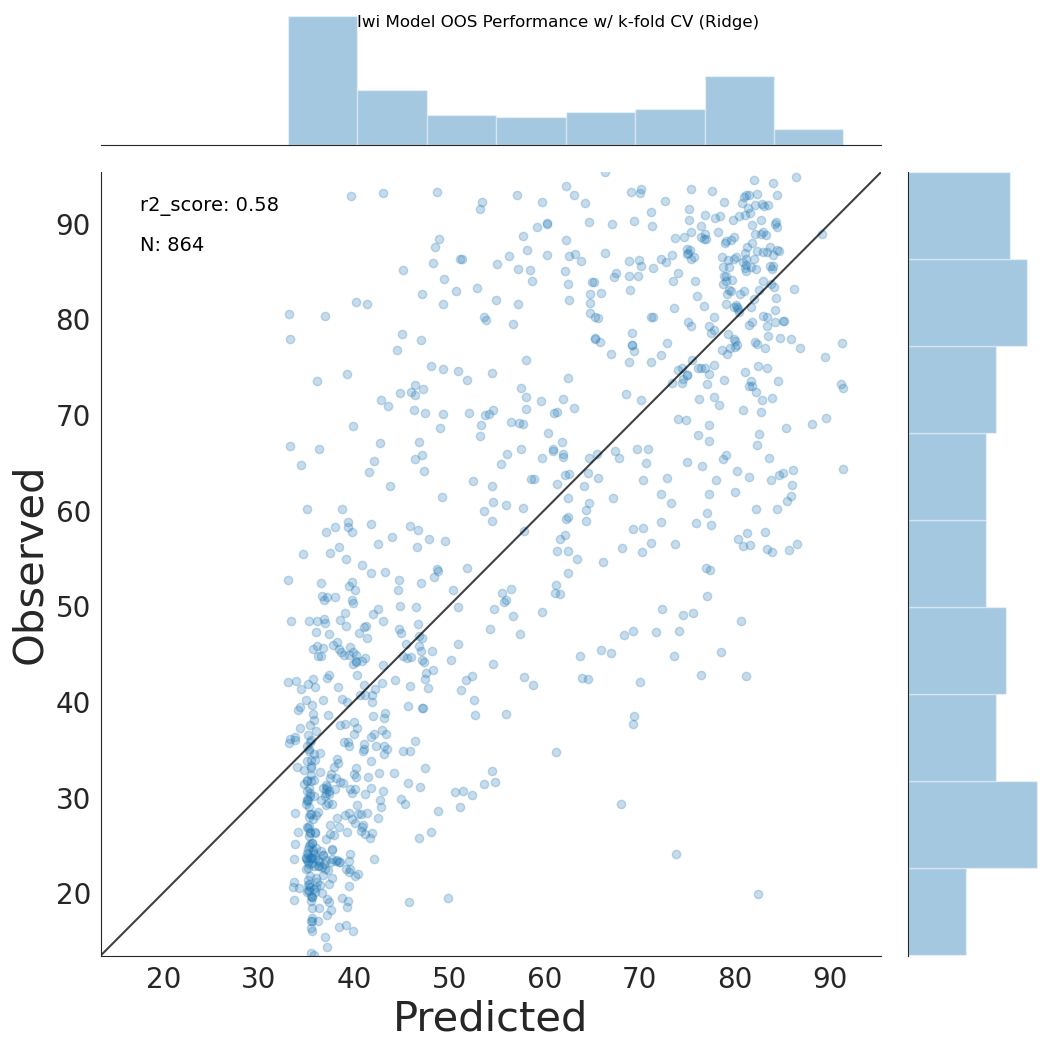

In [20]:
nl_kfold_dict = {}

for task in tasks:
    Y_train = train_df[task]
    if log_task[task]:
        Y_train = np.log(Y_train)
    nl_kfold_dict[task] = cv_solve(task,
                                   X_nl,
                                   Y_train,
                                   clip_bounds = [np.min(Y_train), np.max(Y_train)],
                                    country_fold = True
                                  )

In [21]:
outpath = (model_directory+
           "cross_country_nl_solve_all_outcomes_country_fold_dmsp_hist_bins_GPW_pop_weighted.pkl")
pickle.dump(nl_kfold_dict, open(outpath, "wb"))
nl_kfold_dict = pickle.load(open(outpath, "rb"))


cc_nl_perf_dict = {}
for task in tasks:
    cc_nl_perf_dict[task] = get_within_perf_from_kfold_dict(nl_kfold_dict, task, metric="ALL")
    
    

###  NL only - demeaned

Zero obs dropped = 19
Sub-national HDI
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting Sub-national HDI...
Zero obs dropped = 19
Life expectancy
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting Life expectancy...
Zero obs dropped = 19
Mean years schooling
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting Mean years schooling...
Zero obs dropped = 19
Expected years schooling
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting Expected years schooling...
Zero obs dropped = 19
GNI per capita in thousands of US$ (2011 PPP)
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting GNI per capita in thousands of US$ (2011 PPP)...
Zero obs dropped = 19
iwi
481
Training model...

on fold (of 5): 0 1 2 3 4 

Plotting iwi...


/shares/maps100/code/code_LS/hdi_downscaling/code/analysis/prediction_utils.py:231: UserWarning: 481 missing values for outcome, these will be dropped
  warnings.warn(f"{num_missings} missing values for outcome, these will be dropped")


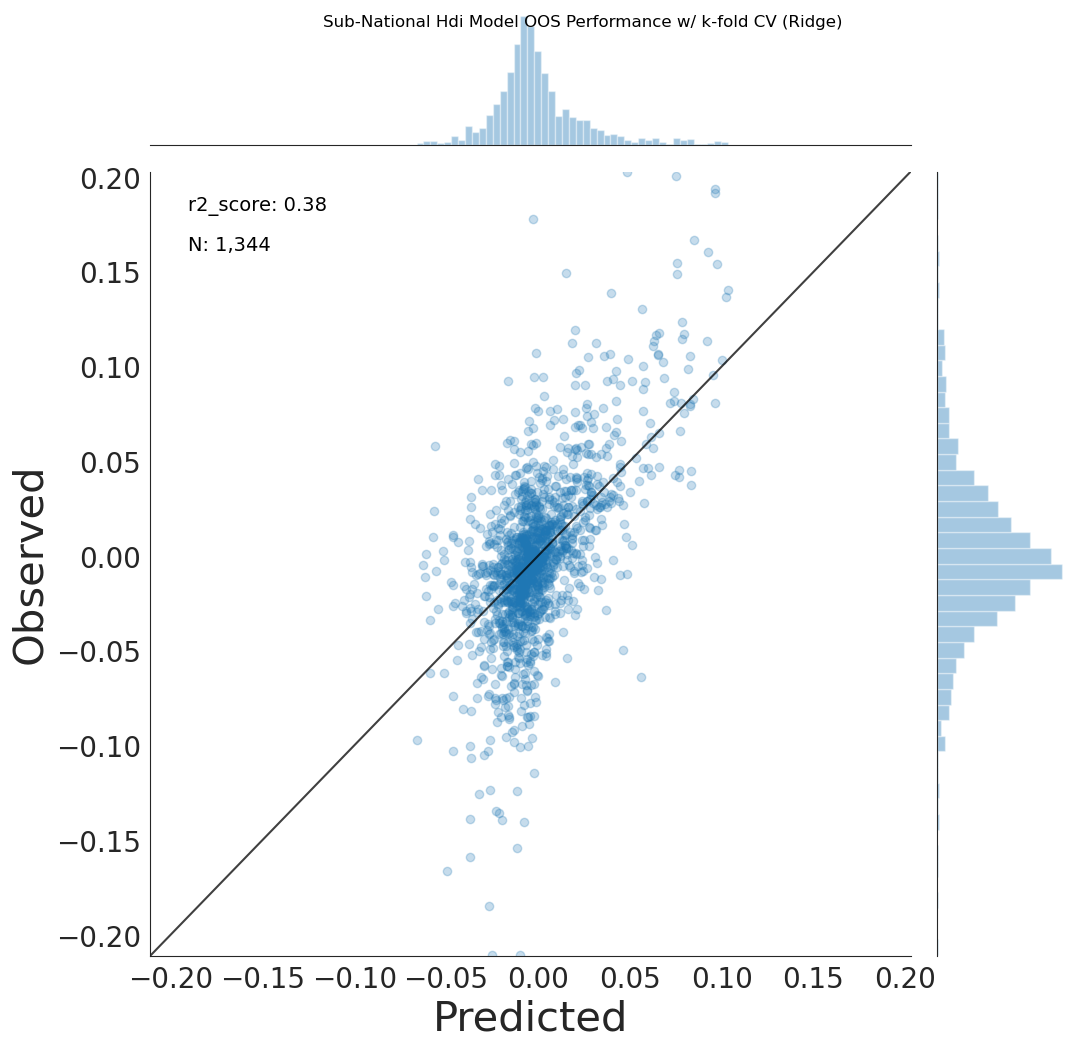

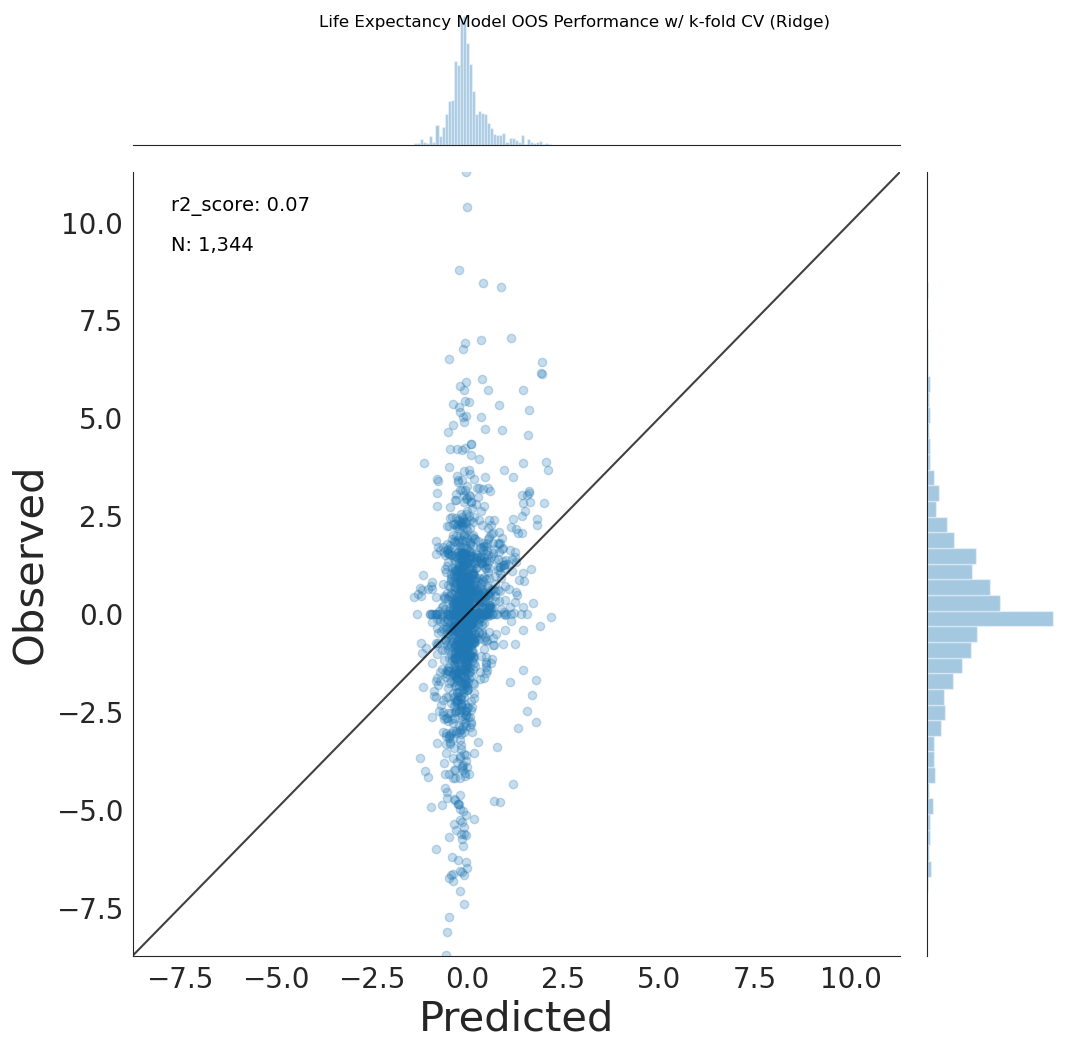

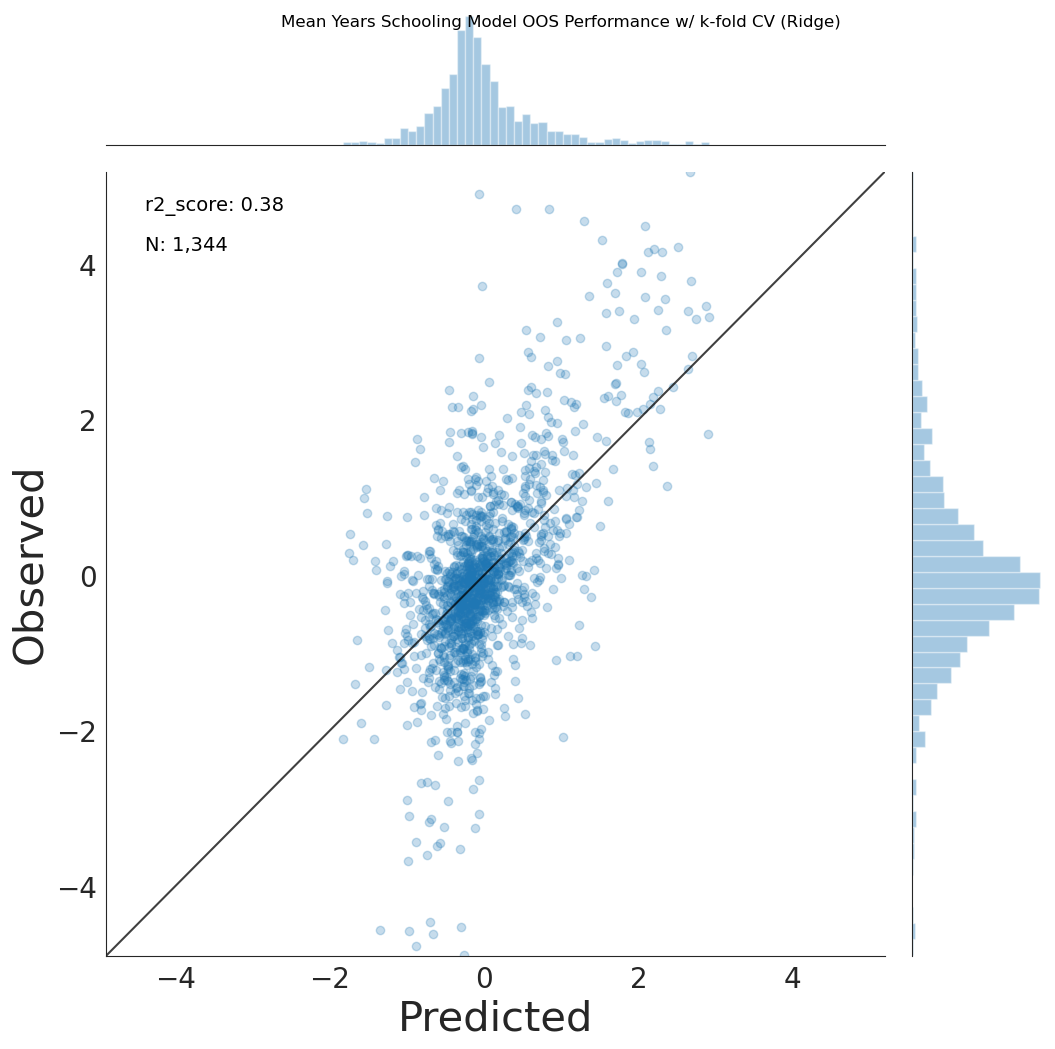

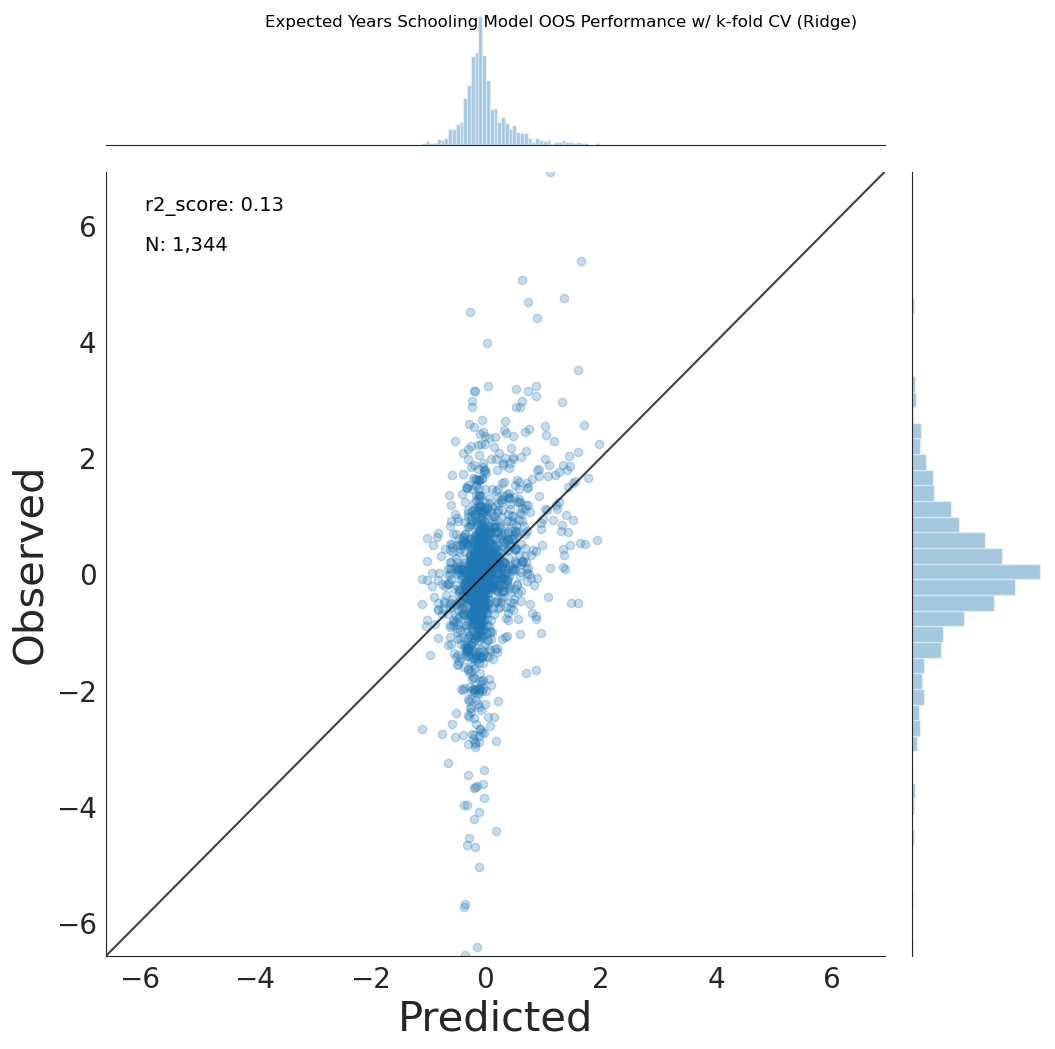

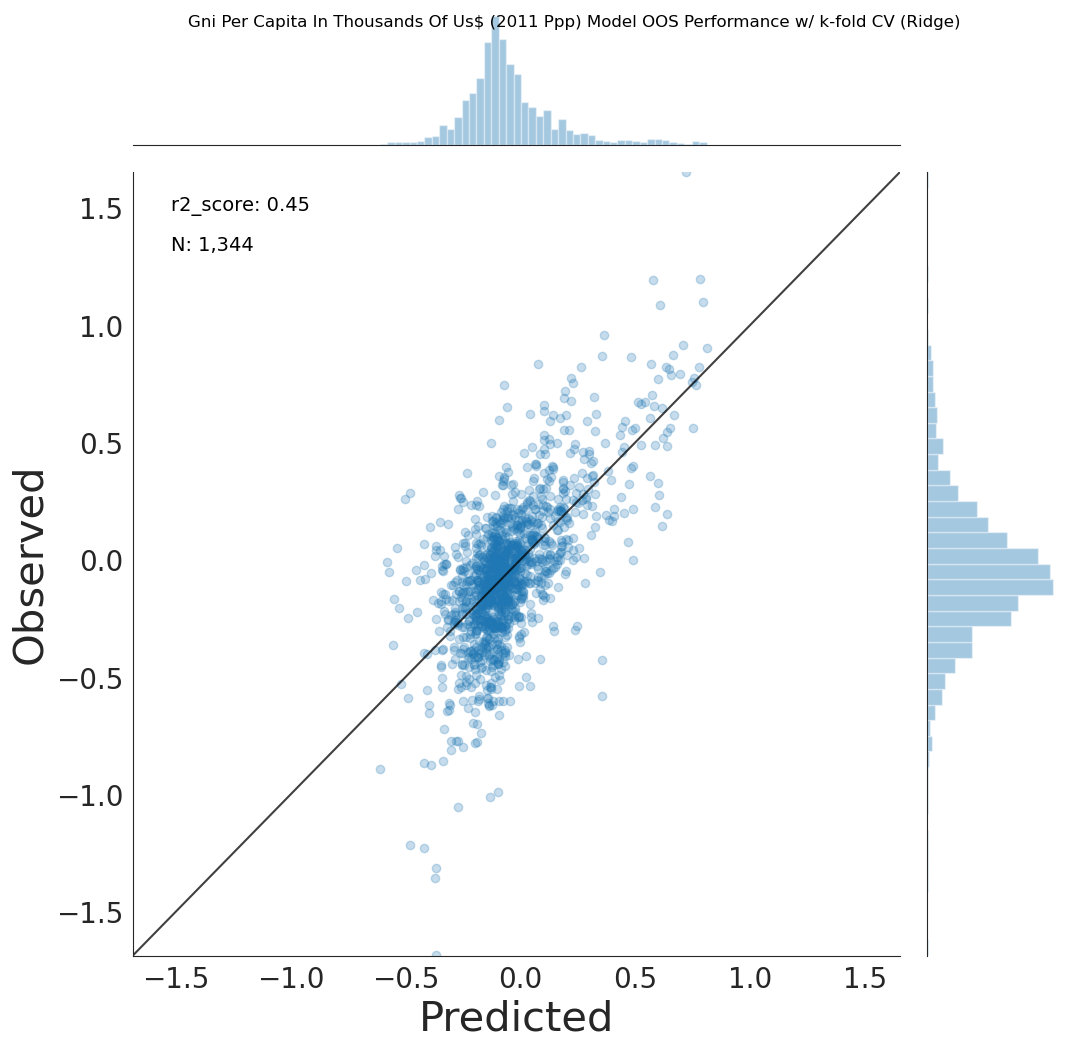

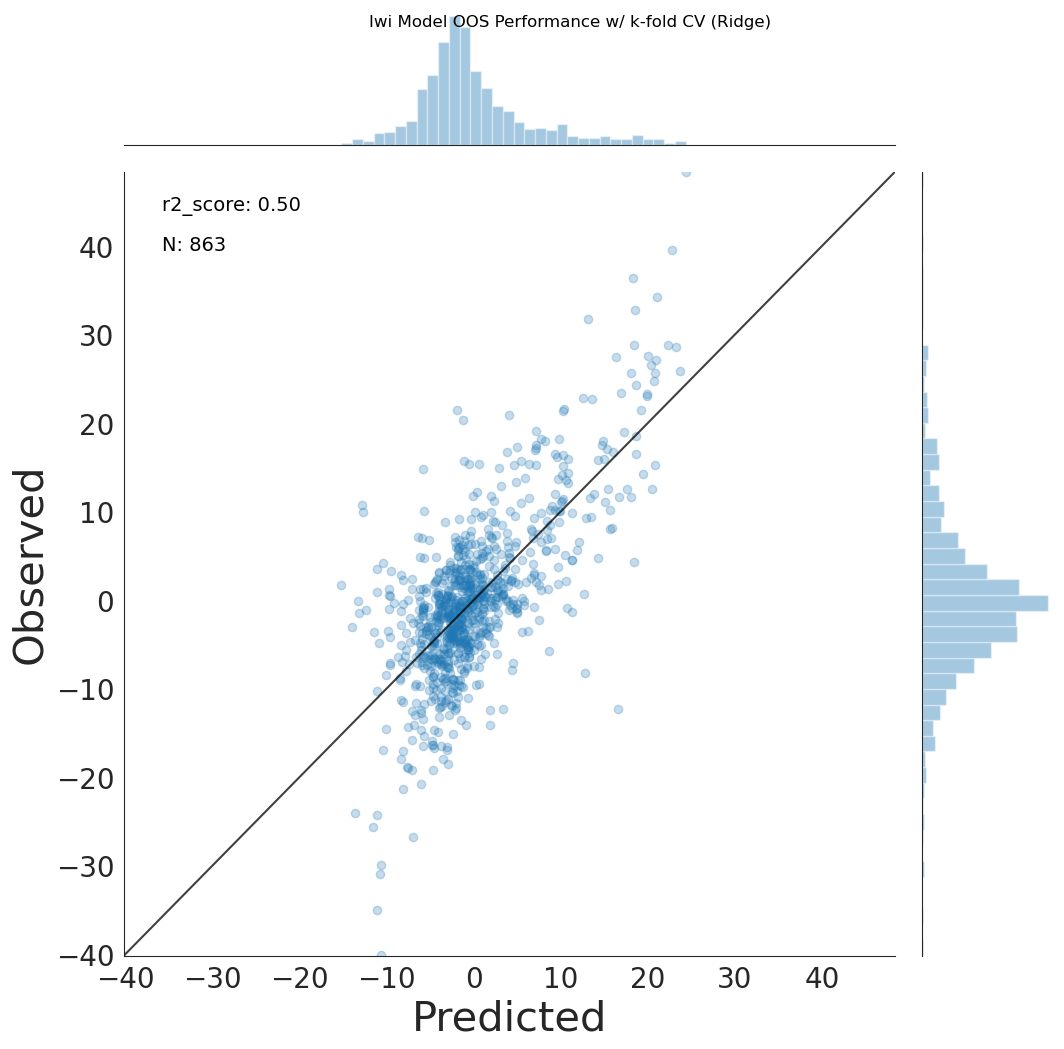

In [22]:
nl_demeaned_kfold_dict = {}

for task in tasks:
    Y_demeaned = df_to_demeaned_y_vars(task, train_df, log_before_diff = log_task[task])
    
    ##Let's drop Y observations that do not have any within country variation. There is nothing to learn from these:
    keep_indxs = get_idxs_without_adm0_observations(train_df)
    Y_demeaned = Y_demeaned.loc[keep_indxs]
    X_demeaned_dropped = X_demeaned_nl.loc[keep_indxs]
    
    print("Zero obs dropped =",(len(X_demeaned)-len(X_demeaned_dropped)))
    
    nl_demeaned_kfold_dict[task] = cv_solve(
        task,
        X_demeaned_dropped,
        Y_demeaned,
        clip_bounds = [np.min(Y_demeaned), np.max(Y_demeaned)],
        country_fold = True)

In [23]:
outpath = (model_directory+
           "within_country_nl_demeaned_solve_all_outcomes_country_fold_dmsp_hist_bins_GPW_pop_weighted.pkl")
pickle.dump(nl_demeaned_kfold_dict, open(outpath, "wb"))
nl_demeaned_kfold_dict = pickle.load(open(outpath, "rb"))


demean_nl_perf_dict = {}
for task in tasks:
    demean_nl_perf_dict[task] = get_within_perf_from_kfold_dict(nl_demeaned_kfold_dict, task, metric="ALL",
                                                               demeaned_input=True, not_demeaned_df=train_df,
                                                                 logged=log_task[task])
    

###  RCF + NL features, cross country model

Sub-national HDI
Training model...

Rescaling X2 by 0.12589254117941673
0 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.30599496872071963
1 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.7437527275659047
2 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.0
3 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.807768676963435
4 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 4.393970560760792
5 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 10.680004325145758
6 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 25.958865861263956
7 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 63.095734448019314
8 out of 9
on fold (of 5): 0 1 2 3 4 

X2 is best rescaled by 1.807768676963435
Plotting Sub-national HDI...
Life expectancy
Training model...

Rescaling X2 by 0.12589254117941673
0 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.30599496872071963
1 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.7437527275659047
2 out of 9
on fold (of 

/shares/maps100/code/code_LS/hdi_downscaling/code/analysis/prediction_utils.py:231: UserWarning: 499 missing values for outcome, these will be dropped
  warnings.warn(f"{num_missings} missing values for outcome, these will be dropped")


on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.30599496872071963
1 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.7437527275659047
2 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.0
3 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.807768676963435
4 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 4.393970560760792
5 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 10.680004325145758
6 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 25.958865861263956
7 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 63.095734448019314
8 out of 9
on fold (of 5): 0 1 2 3 4 

X2 is best rescaled by 0.7437527275659047
Plotting iwi...


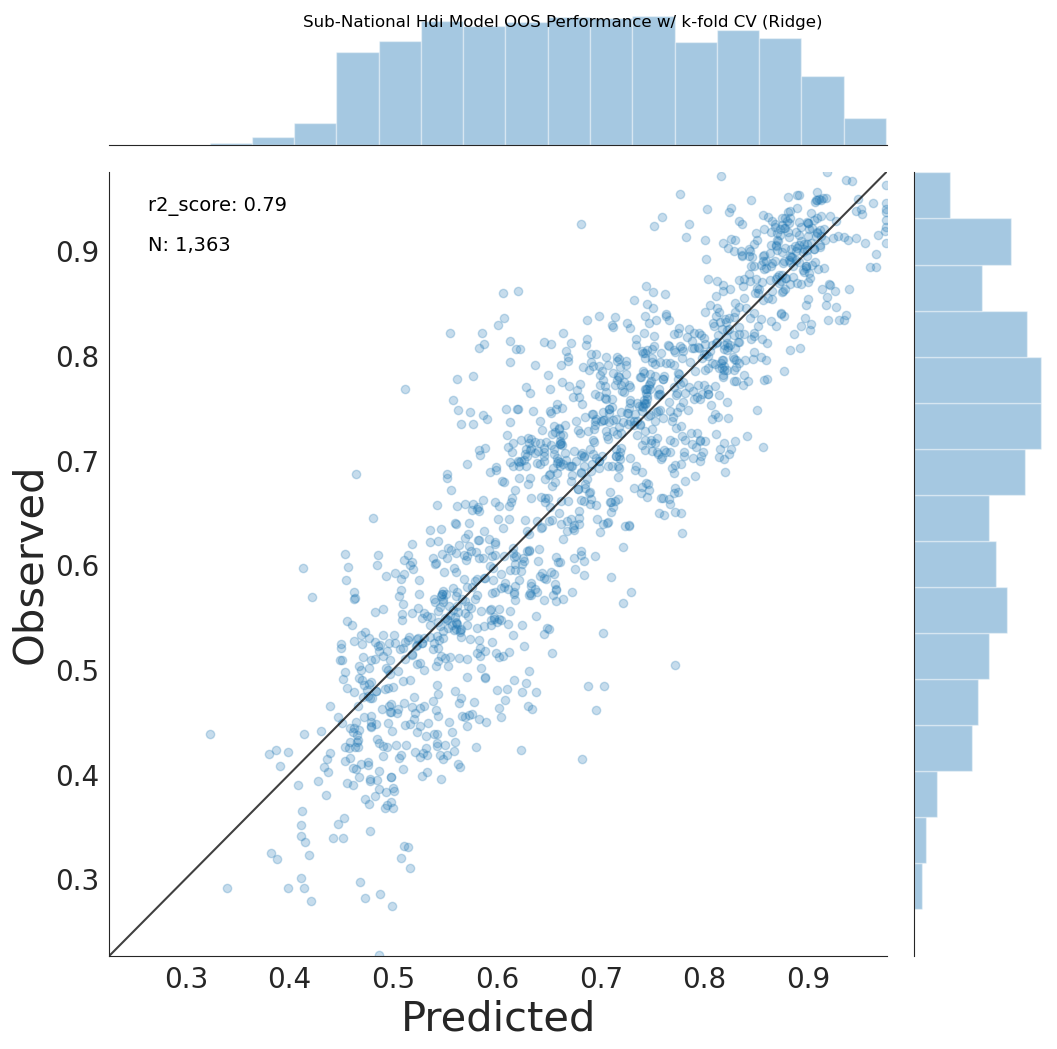

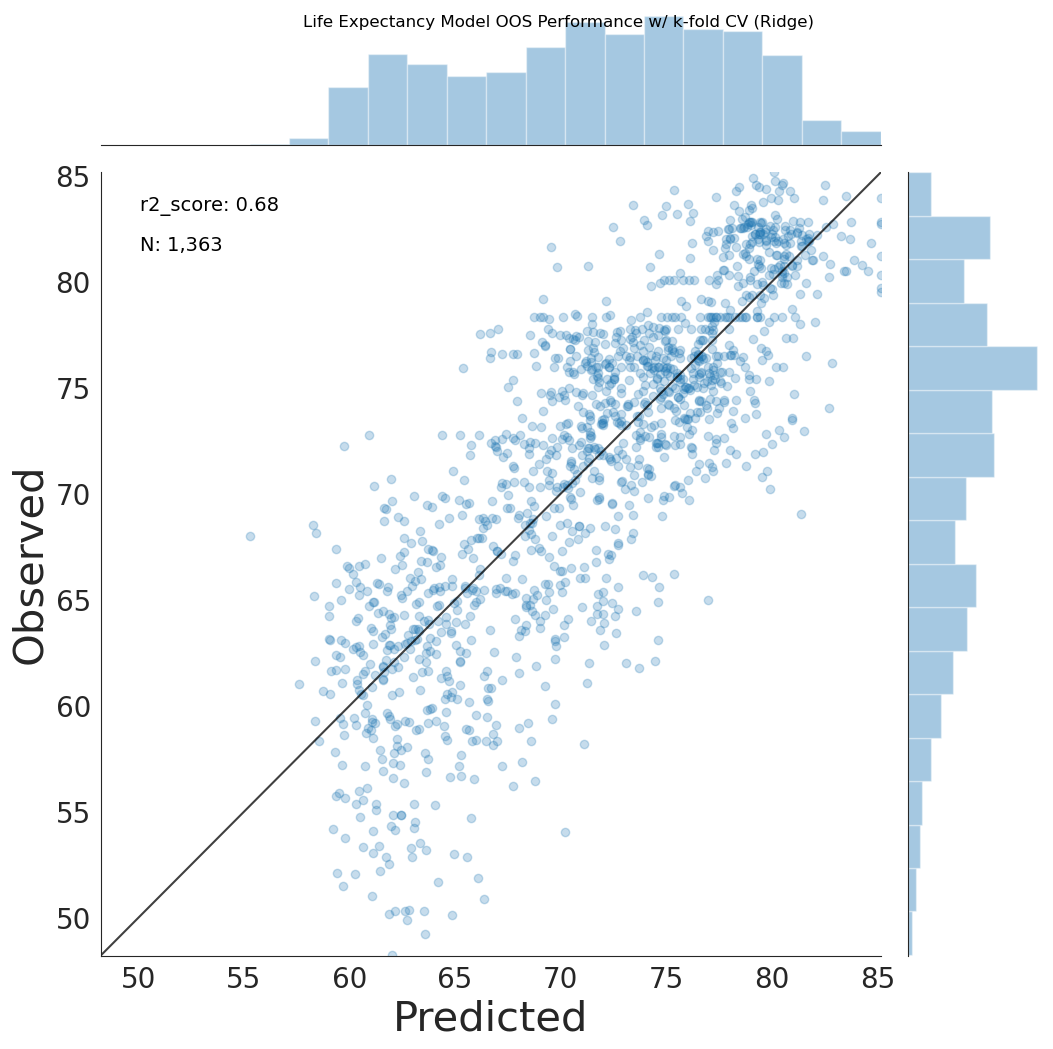

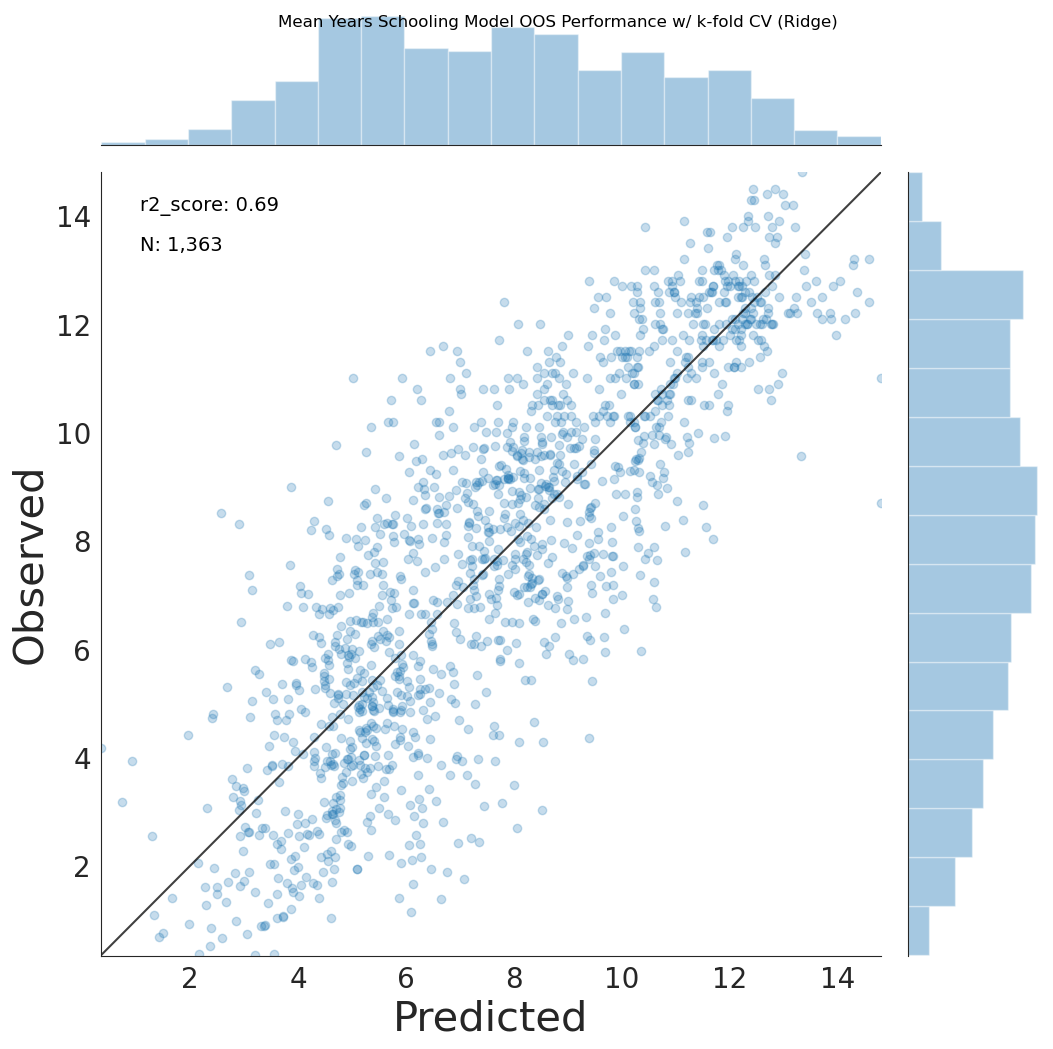

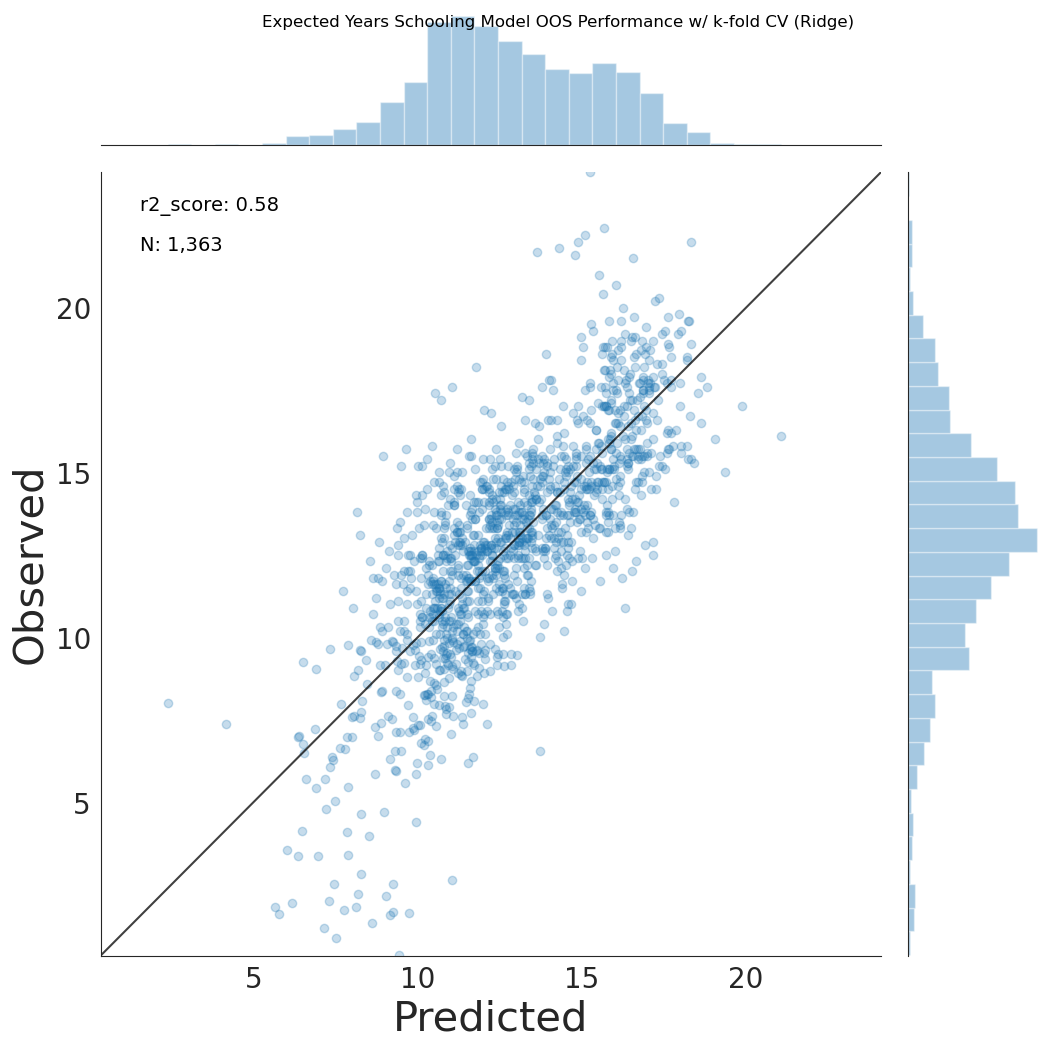

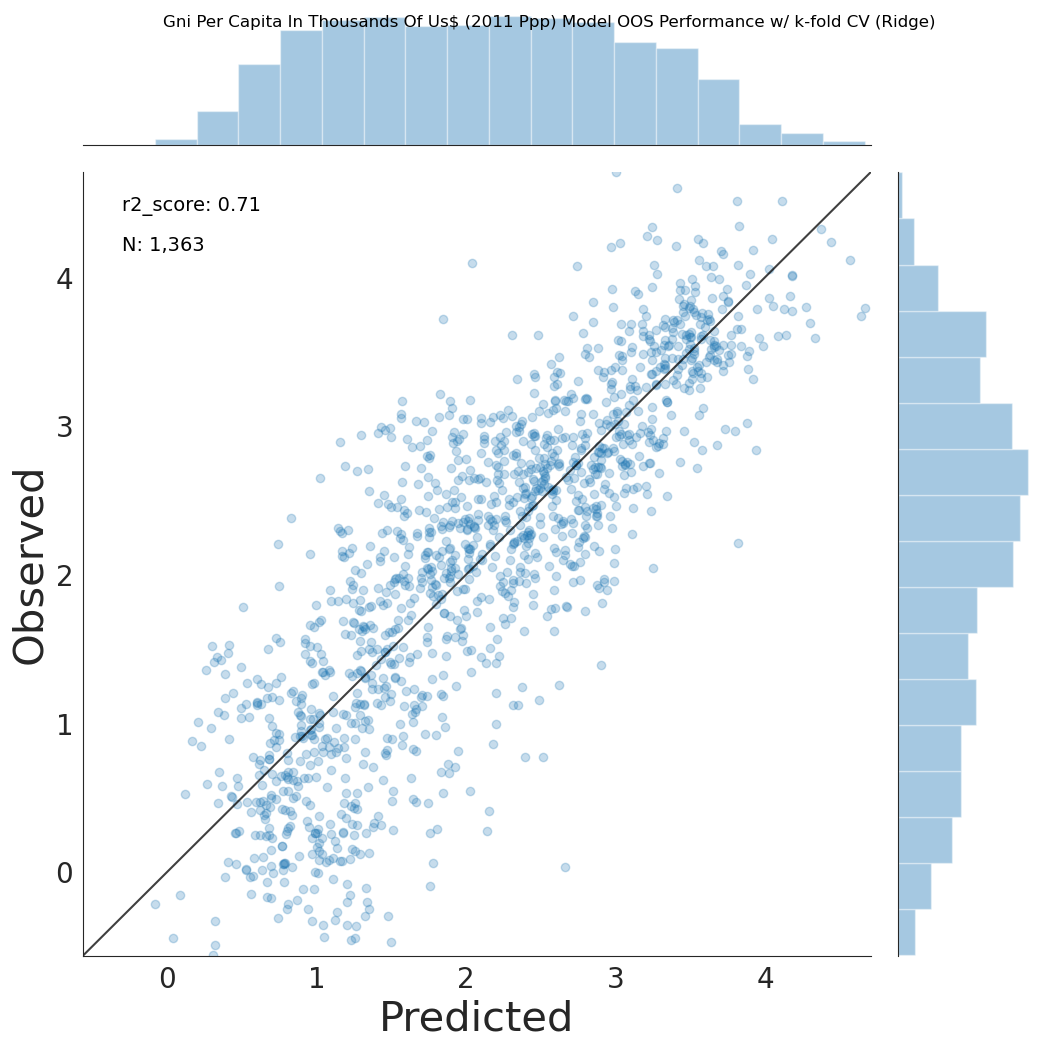

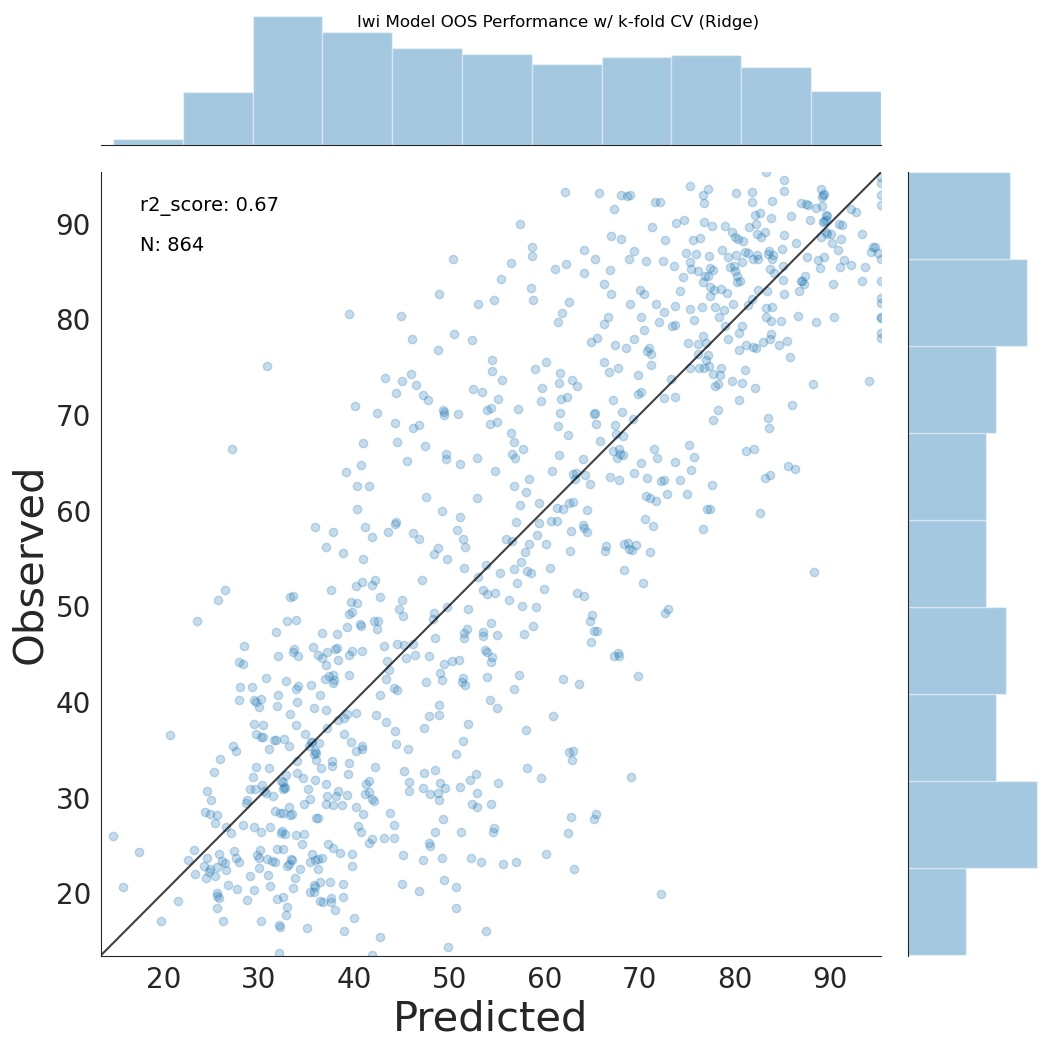

In [24]:
nl_and_rcf_kfold_dict = {}


for task in tasks:
    Y_train = train_df[task]
    if log_task[task]:
        Y_train = np.log(Y_train)
    nl_and_rcf_kfold_dict[task]  = cv_solve(task,
                                            X_train,
                                            Y_train,
                                            X_train2 = X_nl, # here's the nl data
                                            lambdas2 = rescale_lambdas,
                                            clip_bounds = [np.min(Y_train), np.max(Y_train)],
                                            country_fold = True)

In [25]:
outpath = (model_directory+
           "cross_country_rcf_and_nl_solve_all_outcomes_country_fold_DENSE_pop_weight=True_dmsp_hist_bins_GPW_pop_weighted.pkl")
pickle.dump(nl_and_rcf_kfold_dict, open(outpath, "wb"))
nl_and_rcf_kfold_dict = pickle.load(open(outpath, "rb"))

cc_nl_and_rcf_perf_dict = {}
for task in tasks:
    cc_nl_and_rcf_perf_dict[task] = get_within_perf_from_kfold_dict(nl_and_rcf_kfold_dict, task, metric="ALL")
    

### RCF + NL Demeaned (Demeaned Ys and Demeaned Xs)

Zero obs dropped = 19
Sub-national HDI
Training model...

Rescaling X2 by 0.12589254117941673
0 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.30599496872071963
1 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.7437527275659047
2 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.0
3 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.807768676963435
4 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 4.393970560760792
5 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 10.680004325145758
6 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 25.958865861263956
7 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 63.095734448019314
8 out of 9
on fold (of 5): 0 1 2 3 4 

X2 is best rescaled by 4.393970560760792
Plotting Sub-national HDI...
Zero obs dropped = 19
Life expectancy
Training model...

Rescaling X2 by 0.12589254117941673
0 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.30599496872071963
1 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 b

/shares/maps100/code/code_LS/hdi_downscaling/code/analysis/prediction_utils.py:231: UserWarning: 481 missing values for outcome, these will be dropped
  warnings.warn(f"{num_missings} missing values for outcome, these will be dropped")


1 2 3 4 

Rescaling X2 by 0.30599496872071963
1 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 0.7437527275659047
2 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.0
3 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 1.807768676963435
4 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 4.393970560760792
5 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 10.680004325145758
6 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 25.958865861263956
7 out of 9
on fold (of 5): 0 1 2 3 4 

Rescaling X2 by 63.095734448019314
8 out of 9
on fold (of 5): 0 1 2 3 4 

X2 is best rescaled by 1.807768676963435
Plotting iwi...


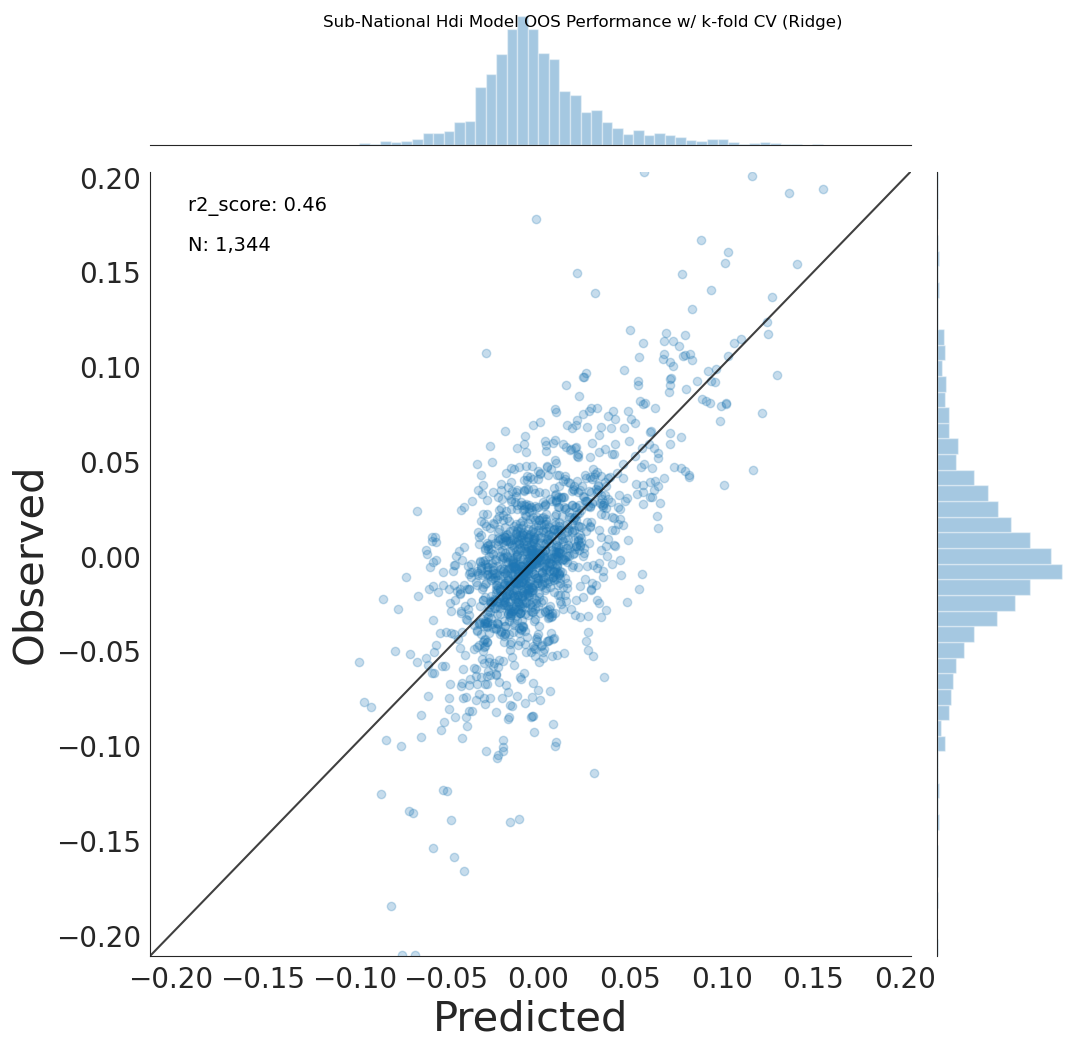

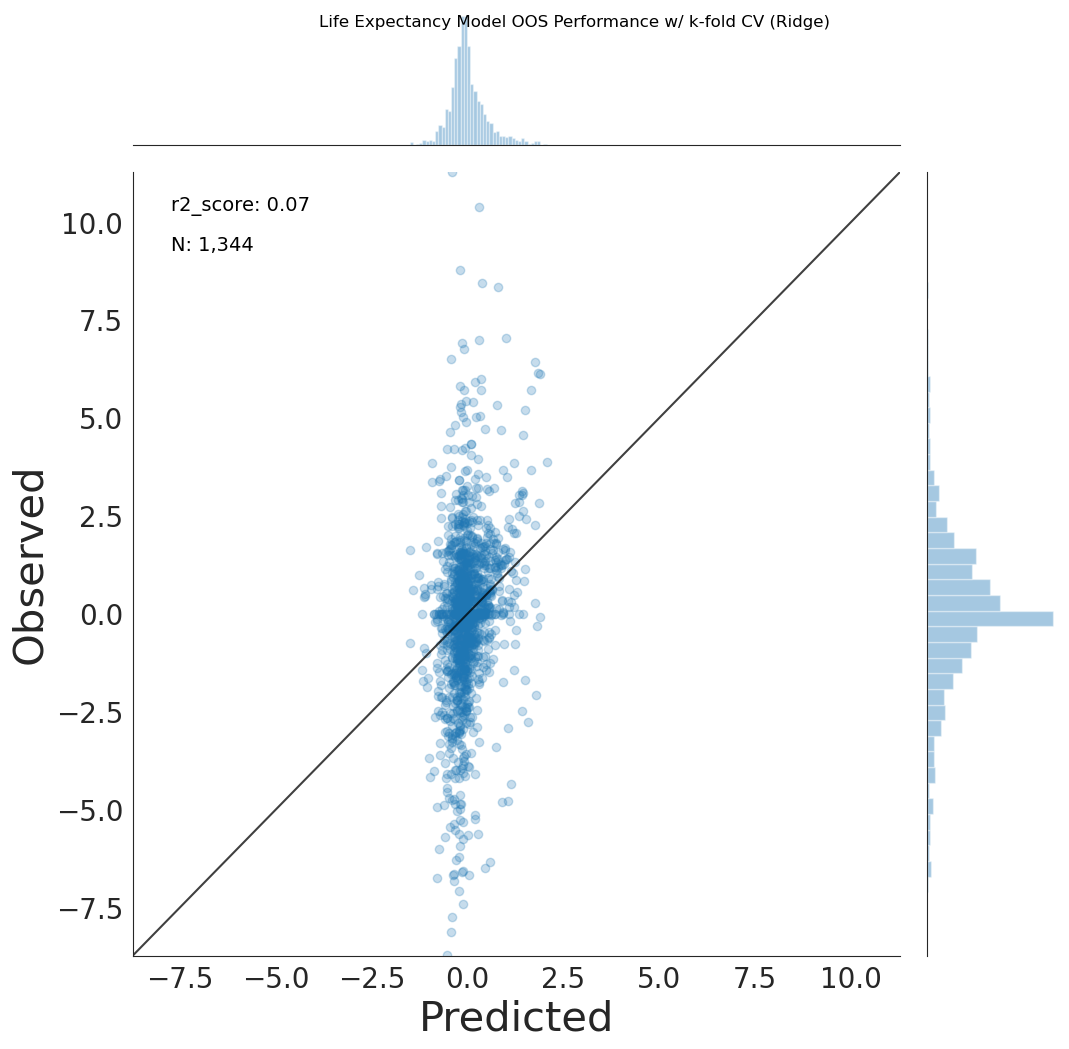

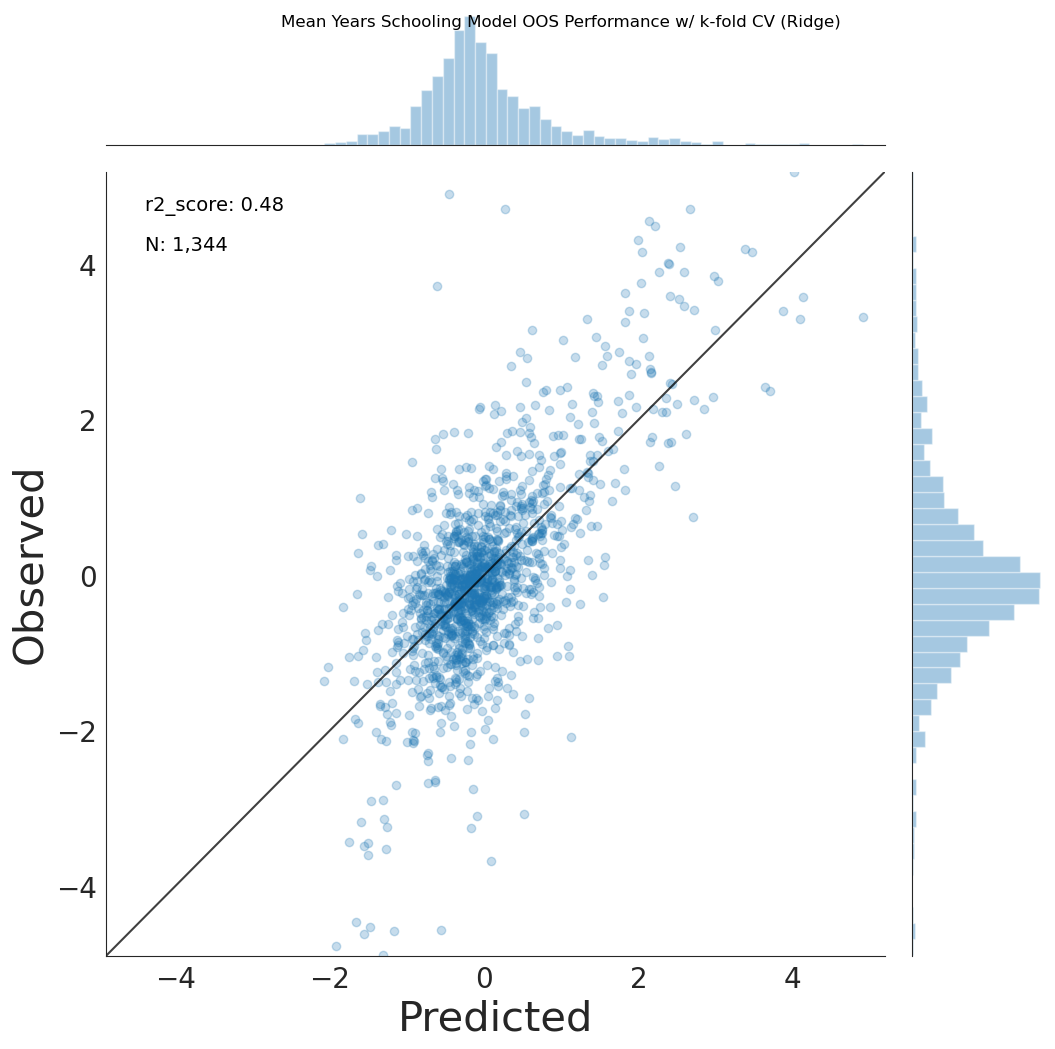

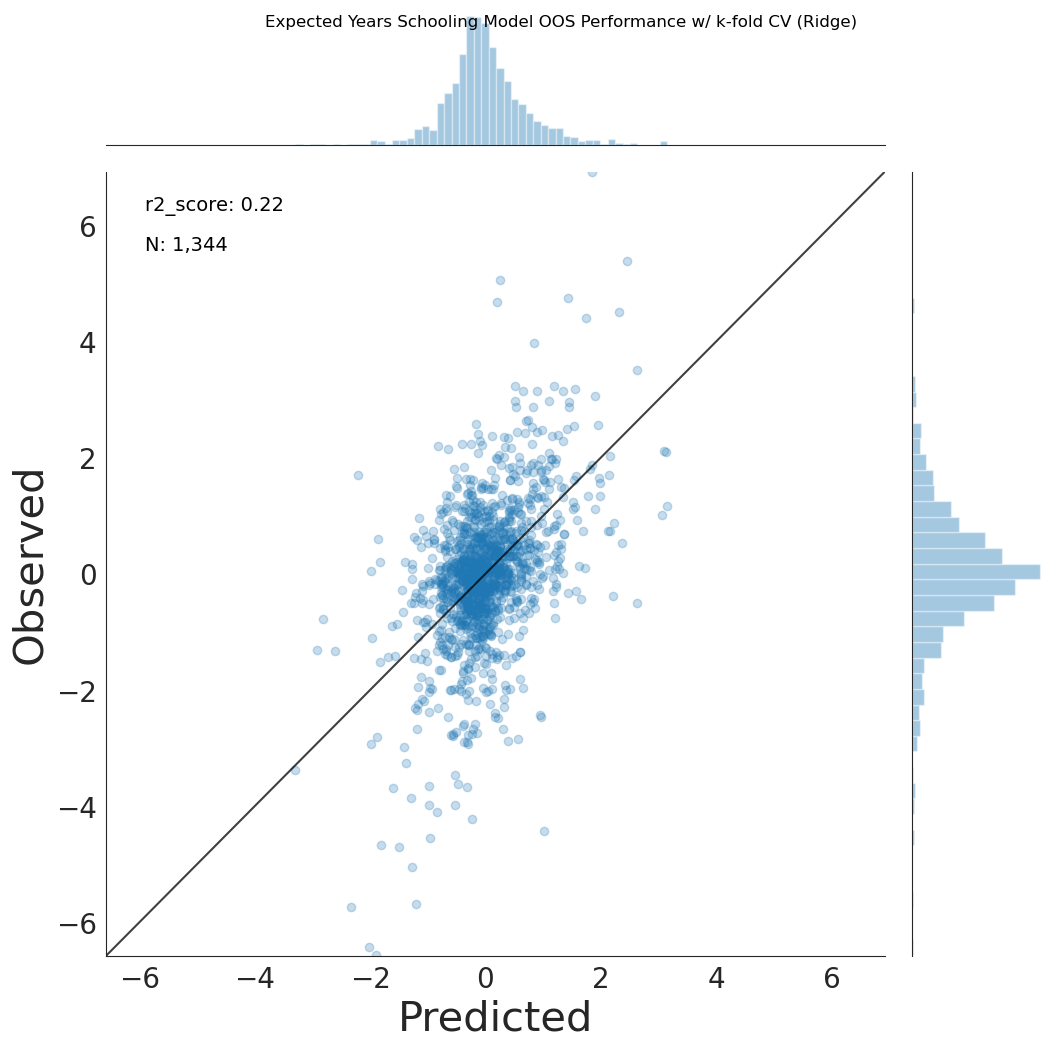

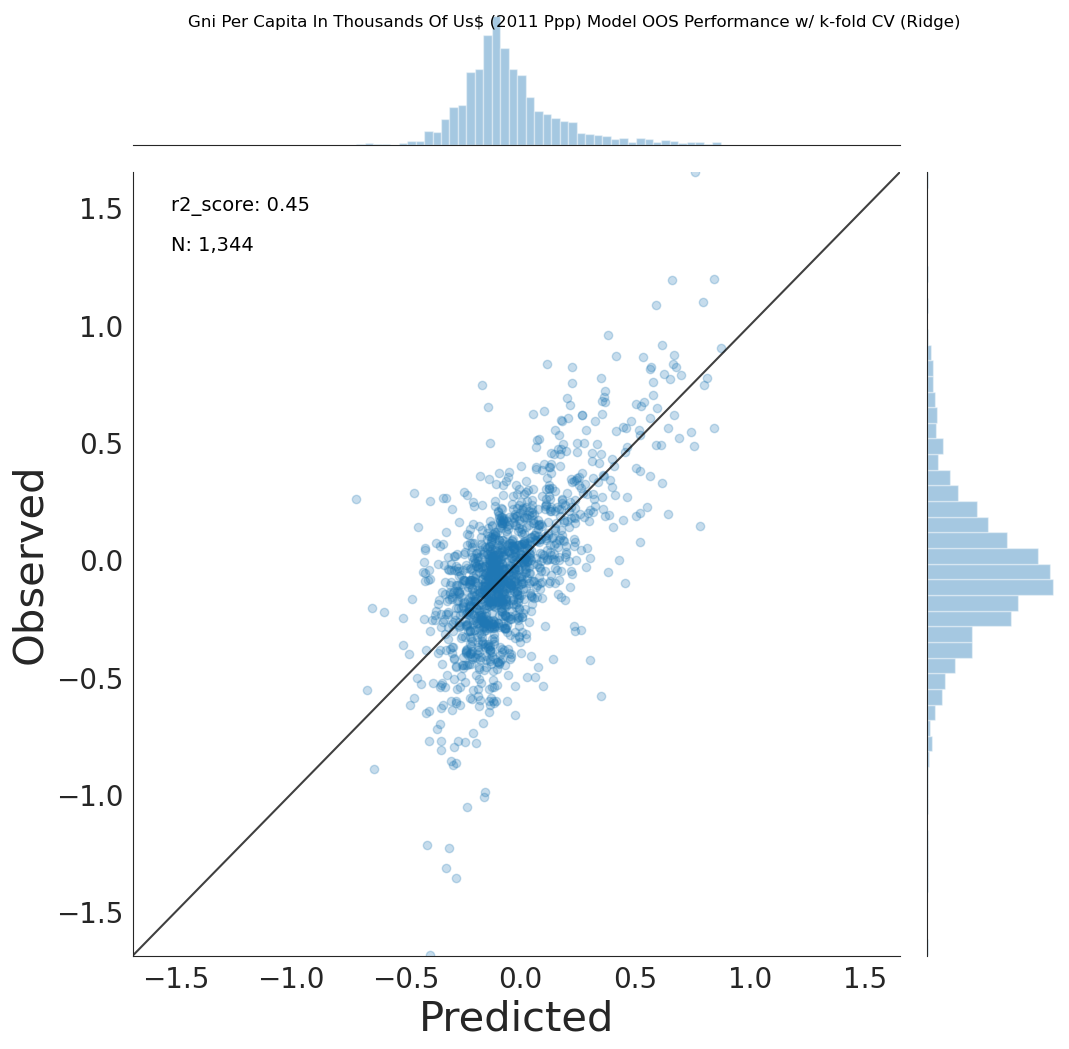

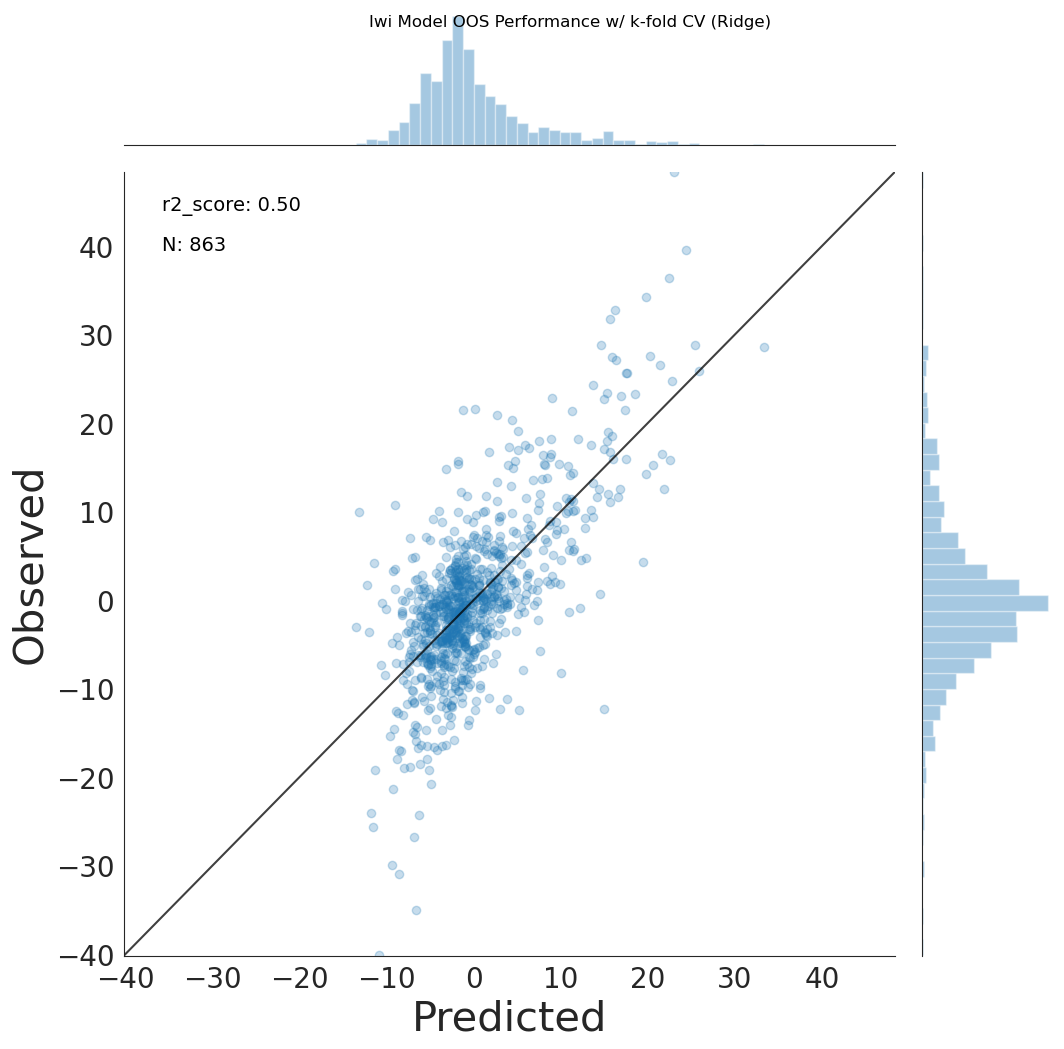

In [26]:
nl_and_rcf_demeaned_kfold_dict = {}

for task in tasks:
    Y_demeaned = df_to_demeaned_y_vars(task, train_df,log_before_diff = log_task[task])
    
    ##Let's drop Y observations that do not have any within country variation. There is nothing to learn from these:
    keep_indxs = get_idxs_without_adm0_observations(train_df)
    Y_demeaned = Y_demeaned.loc[keep_indxs]
    X_demeaned_dropped = X_demeaned.loc[keep_indxs]
    X2_demeaned_dropped = X_demeaned_nl.loc[keep_indxs]
    
    print("Zero obs dropped =",(len(X_demeaned ) - len(X_demeaned_dropped)))
    
    nl_and_rcf_demeaned_kfold_dict[task] = cv_solve(
        task,
        X_demeaned_dropped,
        Y_demeaned,
        X_train2 = X2_demeaned_dropped,
        lambdas2 = rescale_lambdas, # I found that this range worked through iteration
        clip_bounds = [np.min(Y_demeaned), np.max(Y_demeaned)],
         country_fold = True)

In [27]:
outpath = (model_directory+
           "within_country_rcf_and_nl_demeaned_solve_all_outcomes_country_fold"
           "_DENSE_pop_weight=True_dmsp_hist_bins_GPW_pop_weighted.pkl")

pickle.dump(nl_and_rcf_demeaned_kfold_dict, open(outpath, "wb"))
nl_and_rcf_demeaned_kfold_dict = pickle.load(open(outpath, "rb"))

demeaned_nl_and_rcf_demeaned_perf_dict = {}

for task in tasks:
    demeaned_nl_and_rcf_demeaned_perf_dict[task] = get_within_perf_from_kfold_dict(nl_and_rcf_demeaned_kfold_dict, 
                                                                                   task, metric="ALL",demeaned_input=True, 
                                                                                   not_demeaned_df=train_df,
                                                                 logged=log_task[task])
    

## Examine ADM0 Performance

Sub-national HDI
Training model...

on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Plotting Sub-national HDI...
Life expectancy
Training model...

on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Plotting Life expectancy...
Mean years schooling
Training model...

on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Plotting Mean years schooling...
Expected years schooling
Training model...

on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Plotting Expected years schooling...
GNI per capita in thousands of US$ (2011 PPP)
Training model...

on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Plotting GNI per capita in thousands of US$ (2011 PPP)...
iwi
58
Training model...

on fold (1 of 5): 


/shares/maps100/code/code_LS/hdi_downscaling/code/analysis/prediction_utils.py:231: UserWarning: 58 missing values for outcome, these will be dropped
  warnings.warn(f"{num_missings} missing values for outcome, these will be dropped")


on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Plotting iwi...


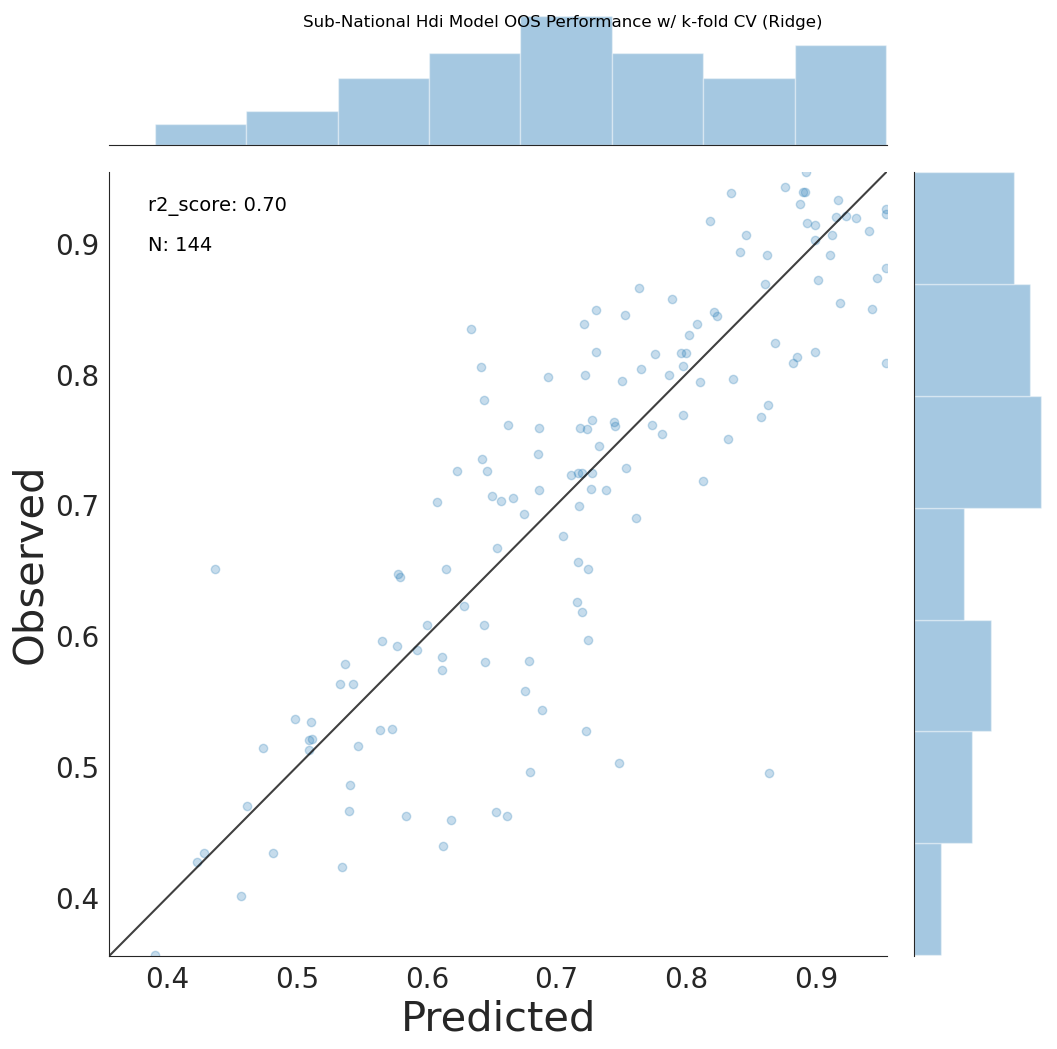

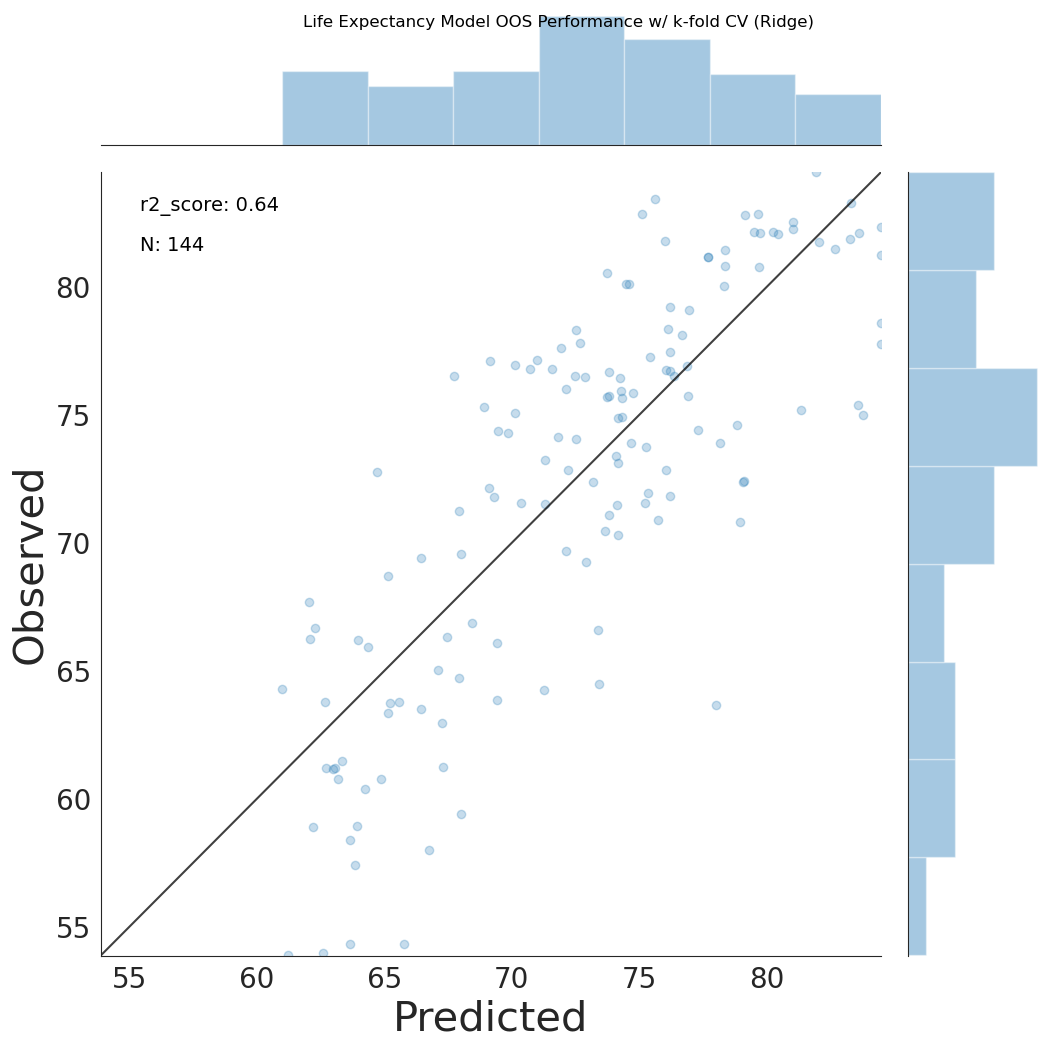

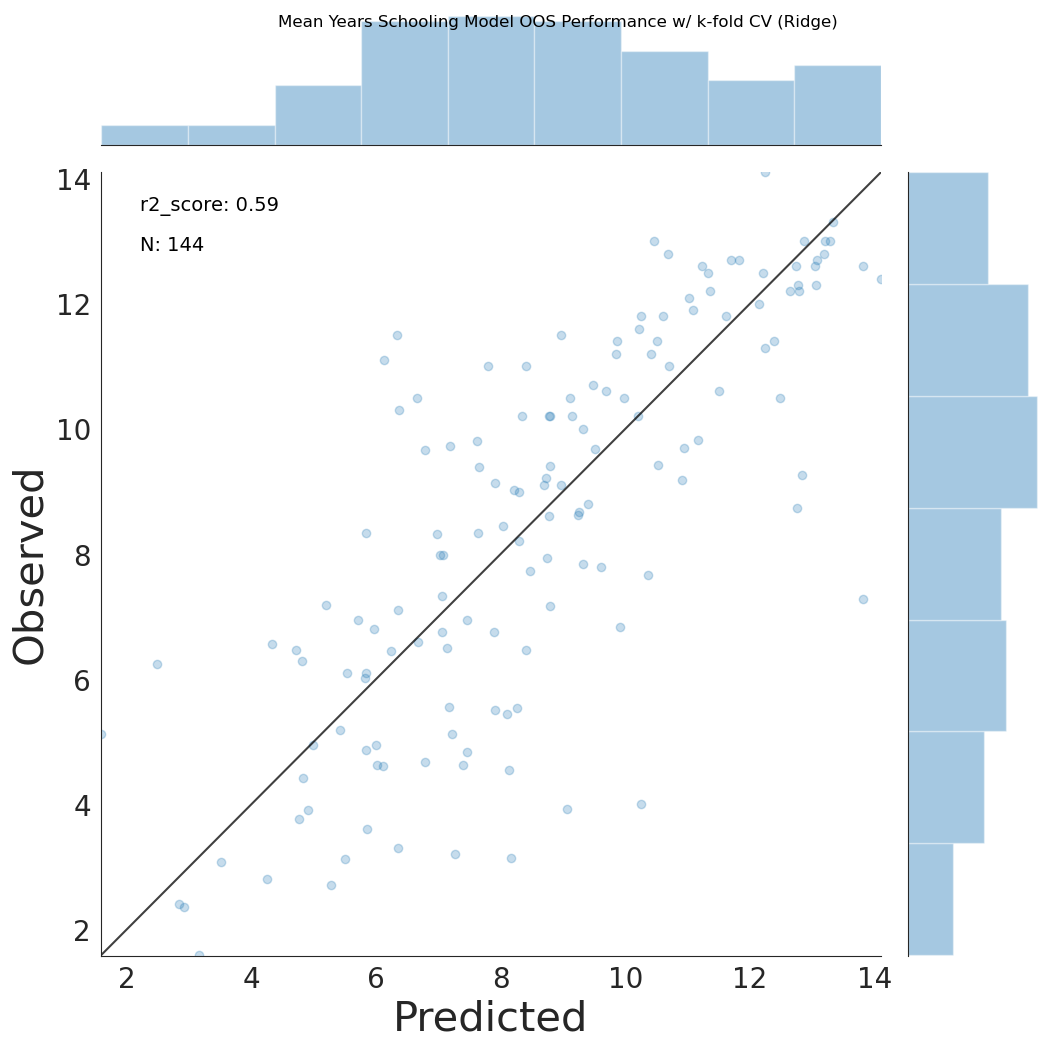

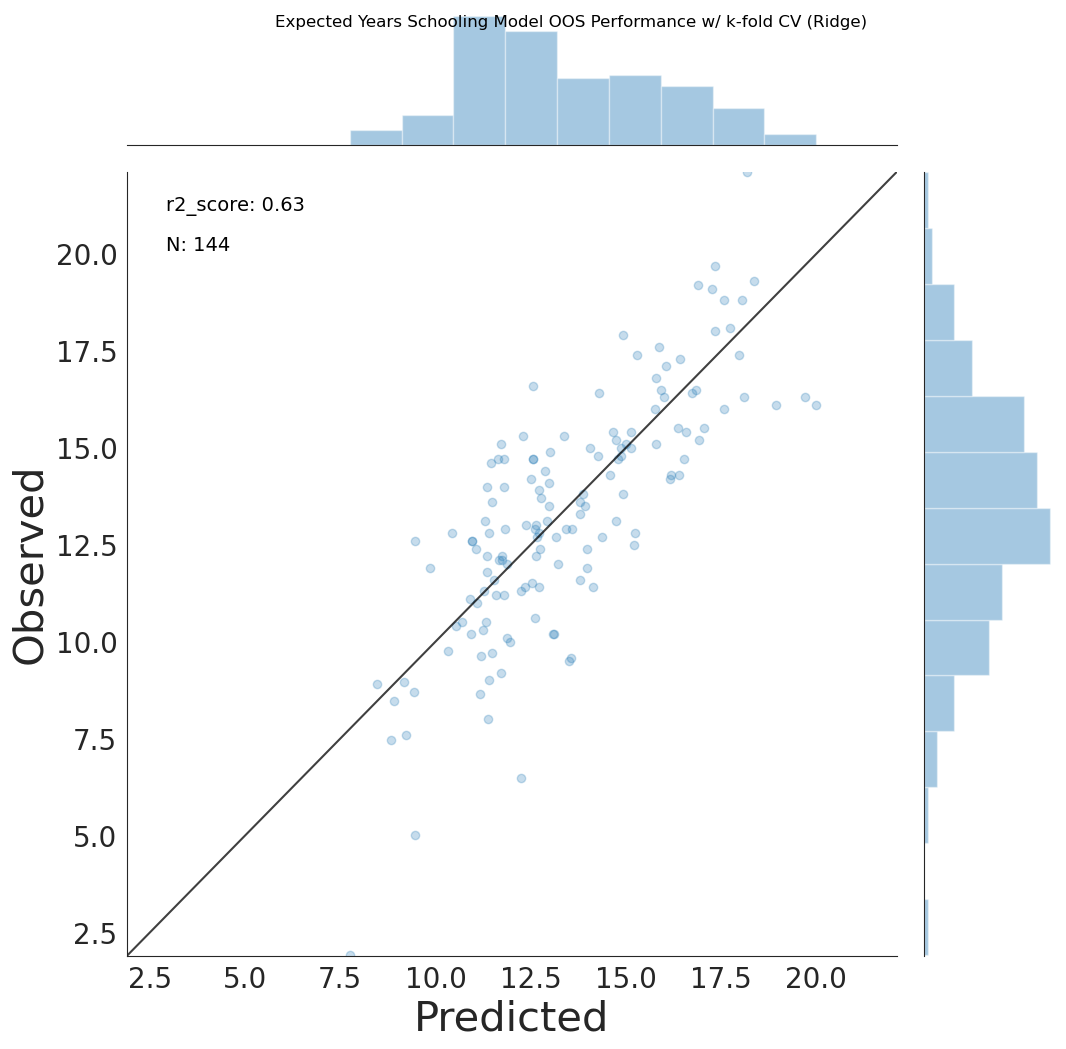

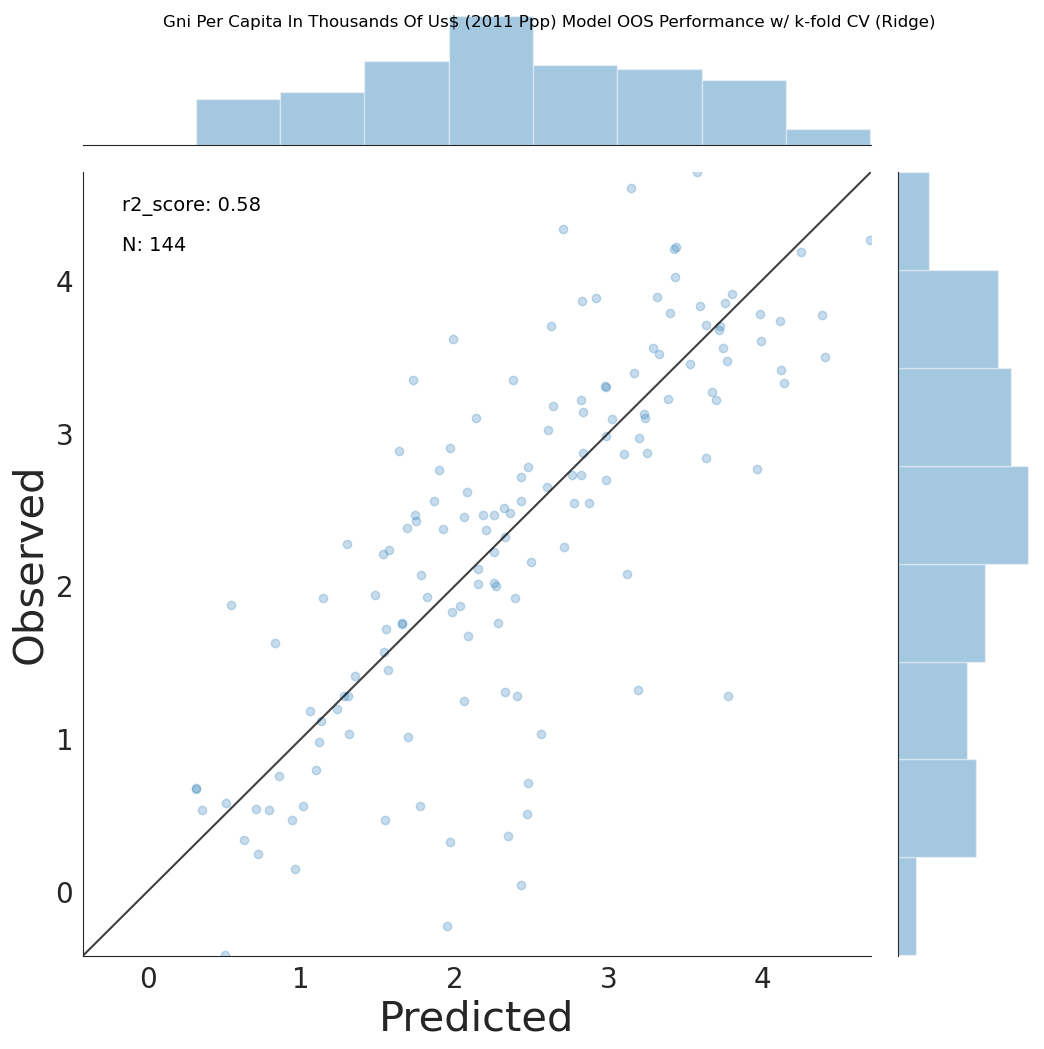

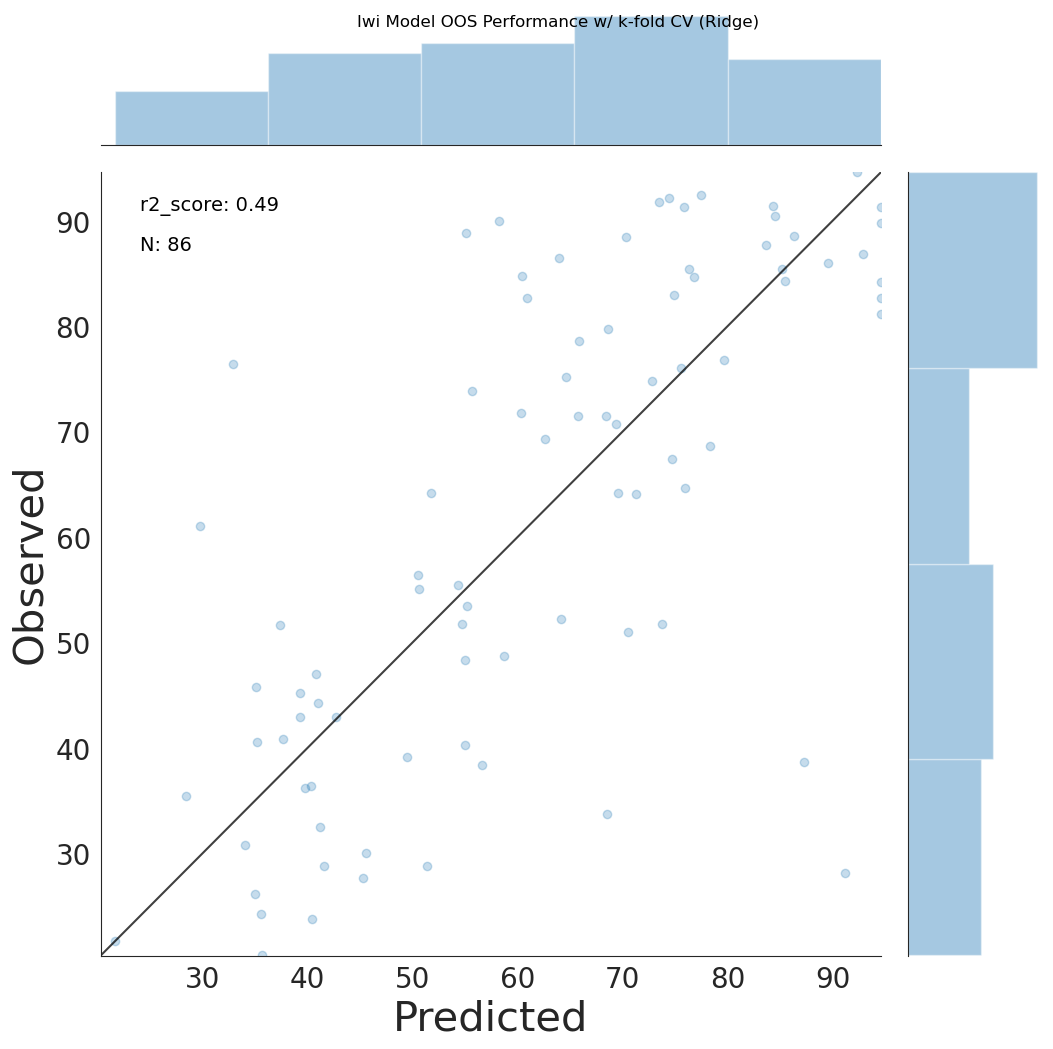

In [28]:
adm0_kfold_dict = {}

for task in tasks:
    Y_train = train_df_adm0[task]
    if log_task[task]:
        Y_train = np.log(Y_train)
    
    adm0_kfold_dict[task]  = cv_solve(task,
                                    X_train_adm0,
                                    Y_train,
                                    clip_bounds = [np.min(Y_train), np.max(Y_train)],)

In [29]:
outpath = (model_directory+
           "kfold_solve_adm0_model_full"
           "_pop_weighted_feats_DENSE.pkl")

pickle.dump(adm0_kfold_dict, open(outpath, "wb"))
adm0_kfold_dict = pickle.load(open(outpath, "rb"))

In [30]:
n_adm0 = {}
for task in tasks:
    n_adm0[task] = len(np.hstack(adm0_kfold_dict[task]["locations_test"]))

### Now ADM 0 with NL features

Sub-national HDI
Training model...

on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Plotting Sub-national HDI...
Life expectancy
Training model...

on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Plotting Life expectancy...
Mean years schooling
Training model...

on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Plotting Mean years schooling...
Expected years schooling
Training model...

on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Plotting Expected years schooling...
GNI per capita in thousands of US$ (2011 PPP)
Training model...

on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Plotting GNI per capita in thousands of US$ (2011 PPP)...
iwi
58
Training model...

on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 

/shares/maps100/code/code_LS/hdi_downscaling/code/analysis/prediction_utils.py:231: UserWarning: 58 missing values for outcome, these will be dropped
  warnings.warn(f"{num_missings} missing values for outcome, these will be dropped")


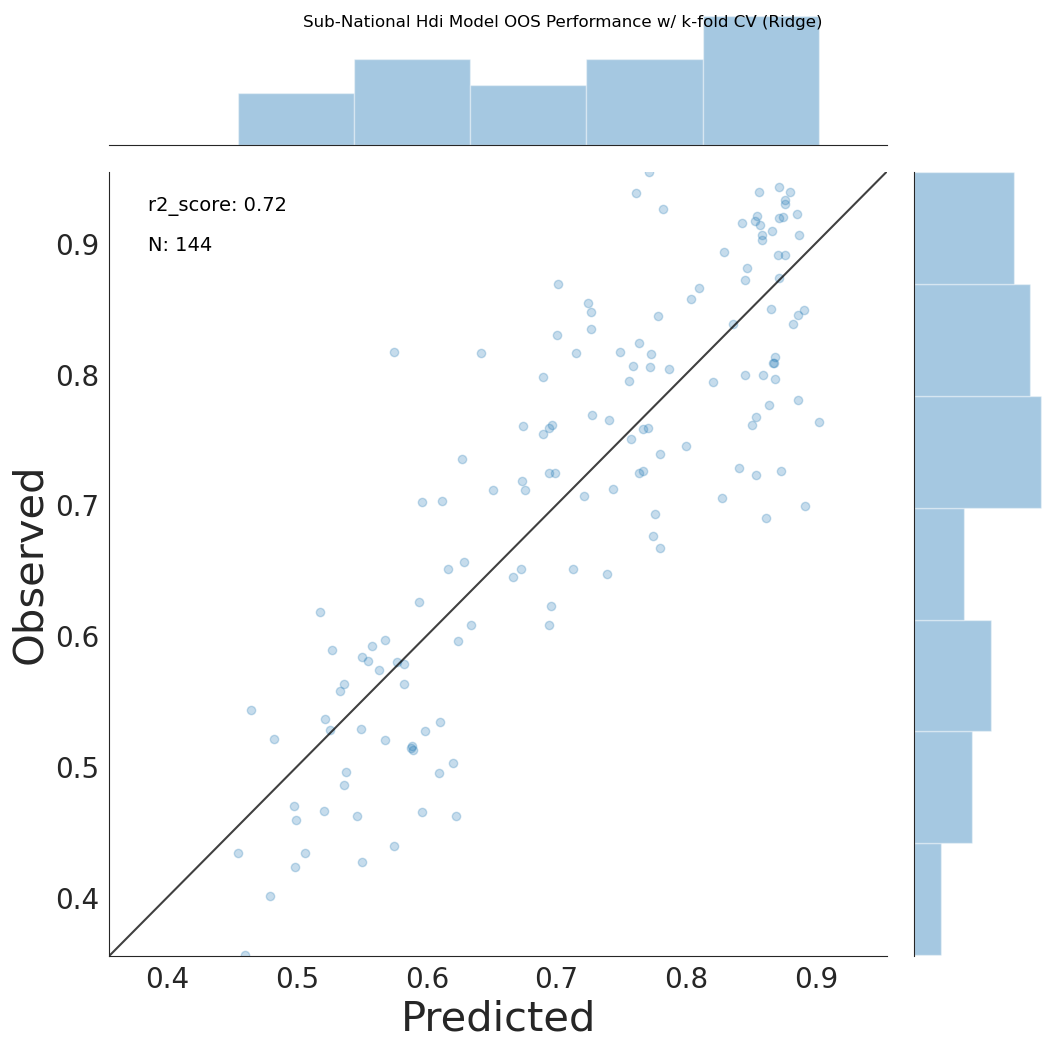

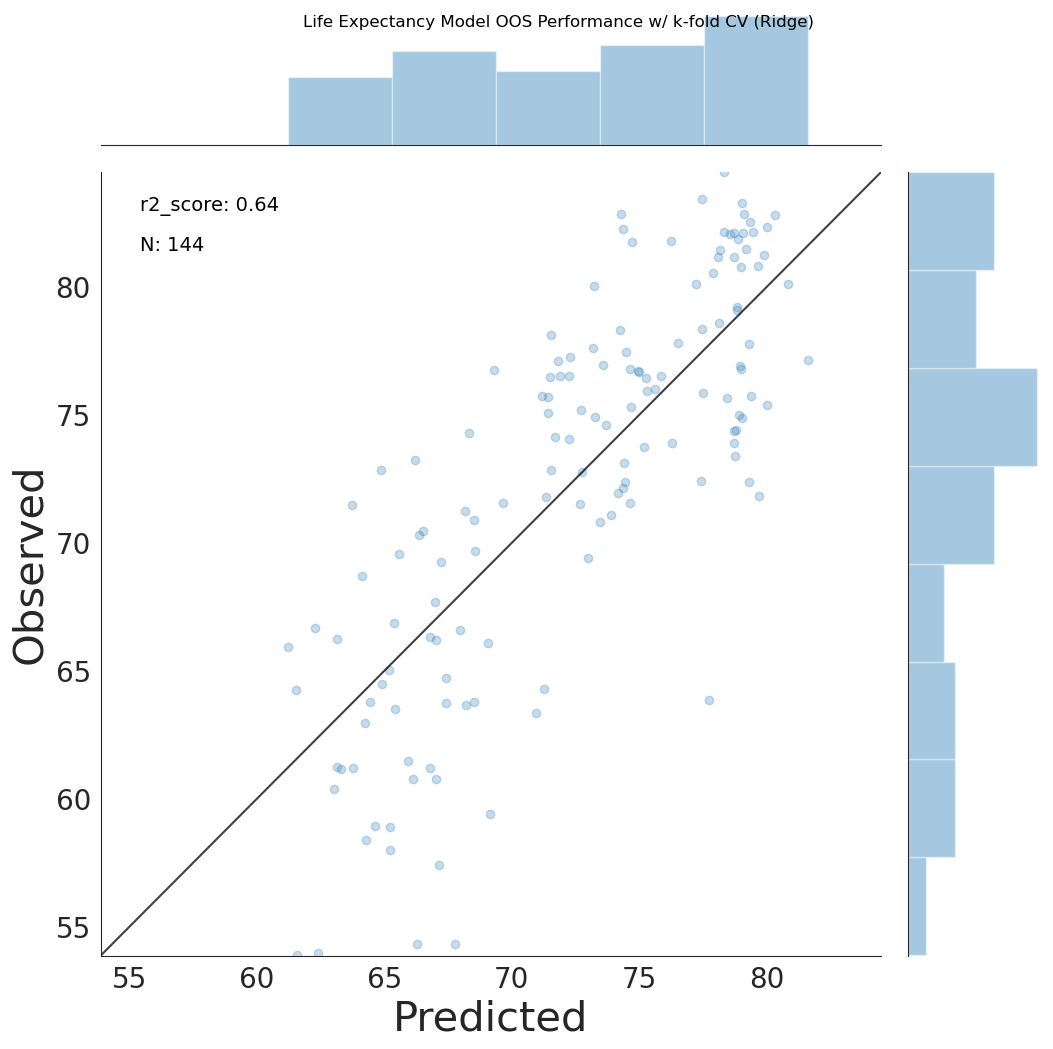

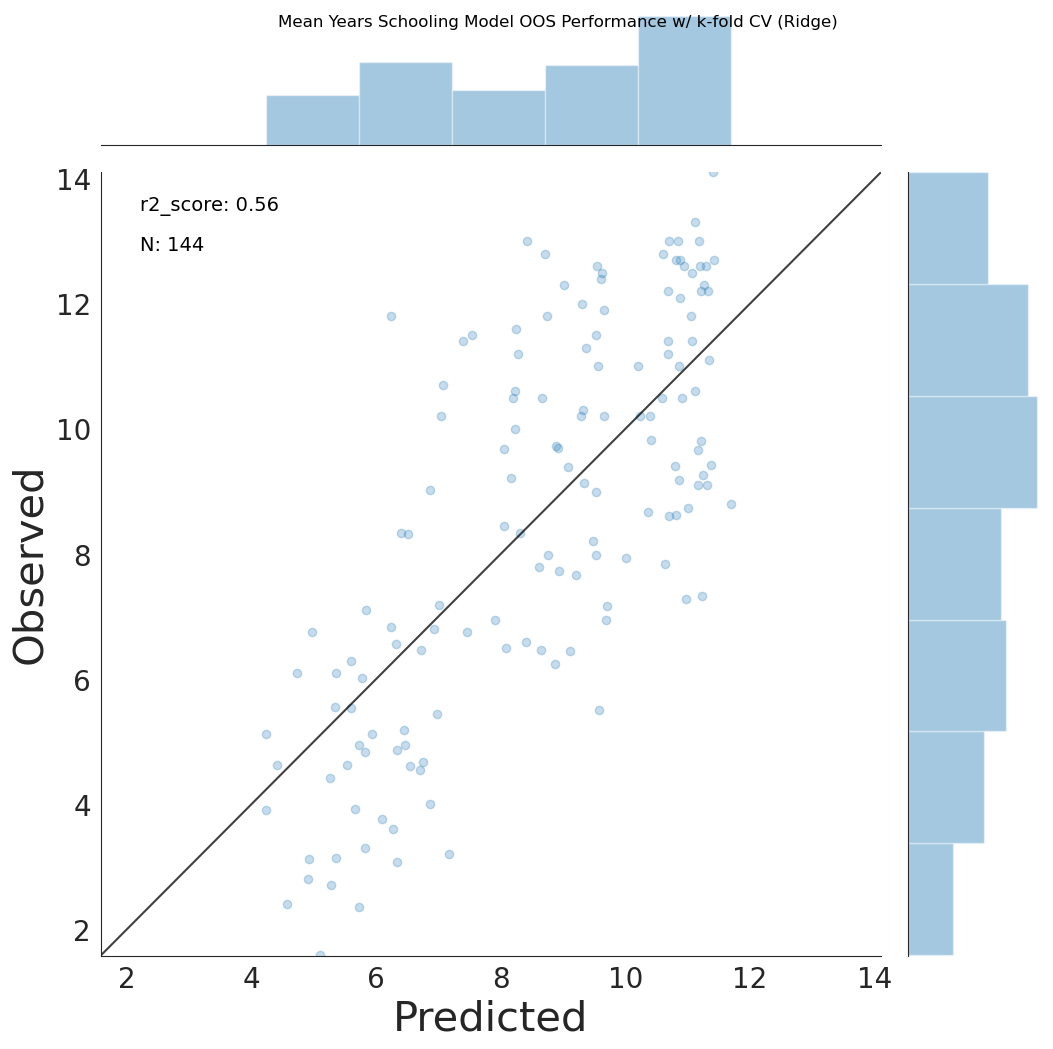

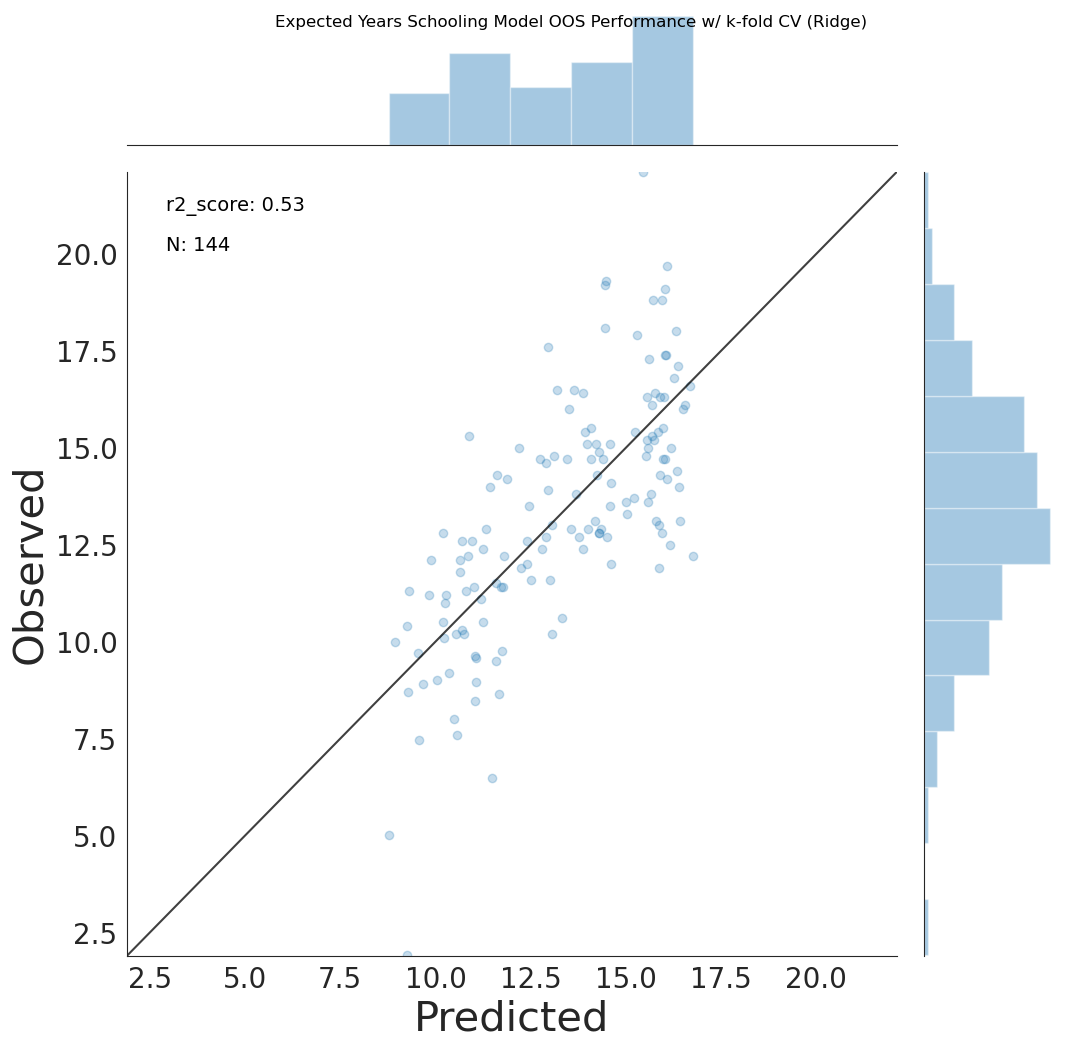

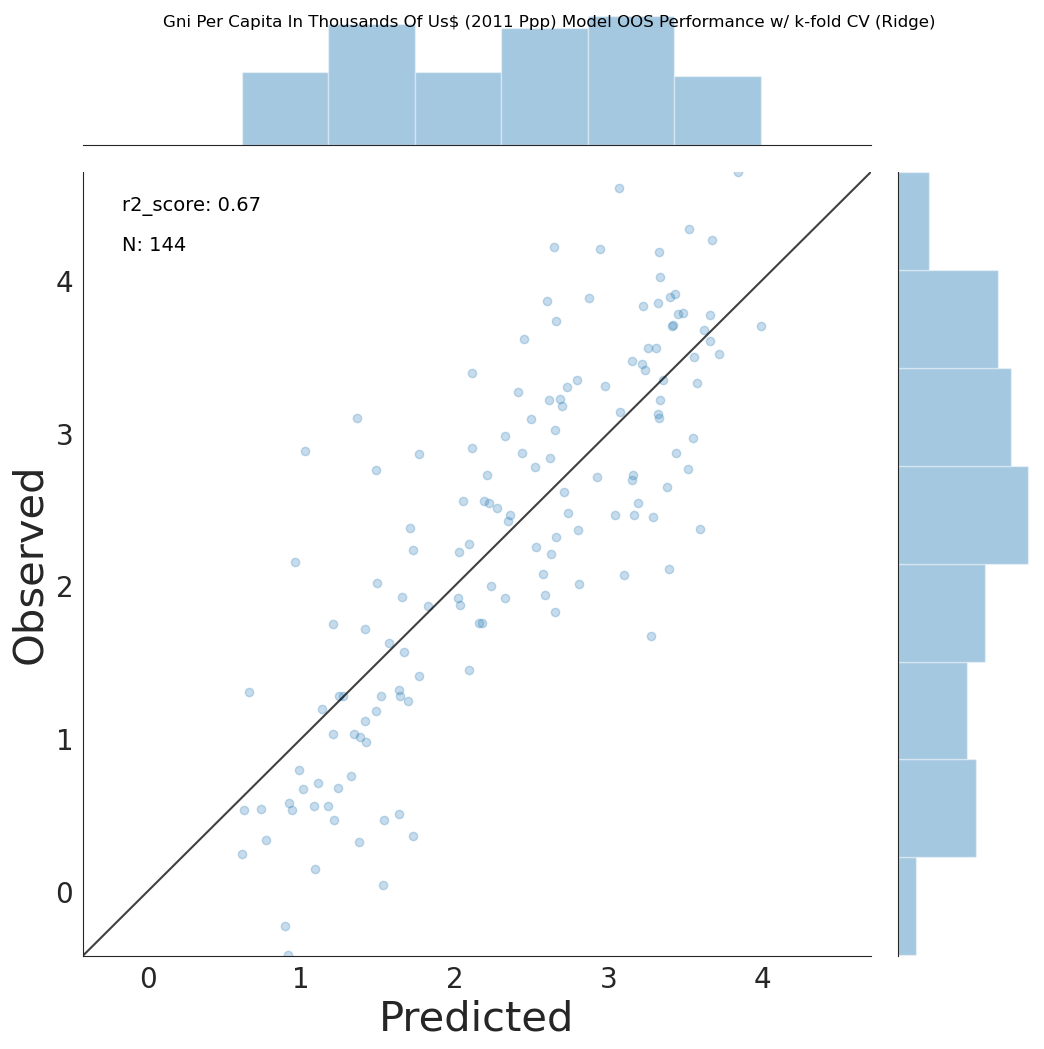

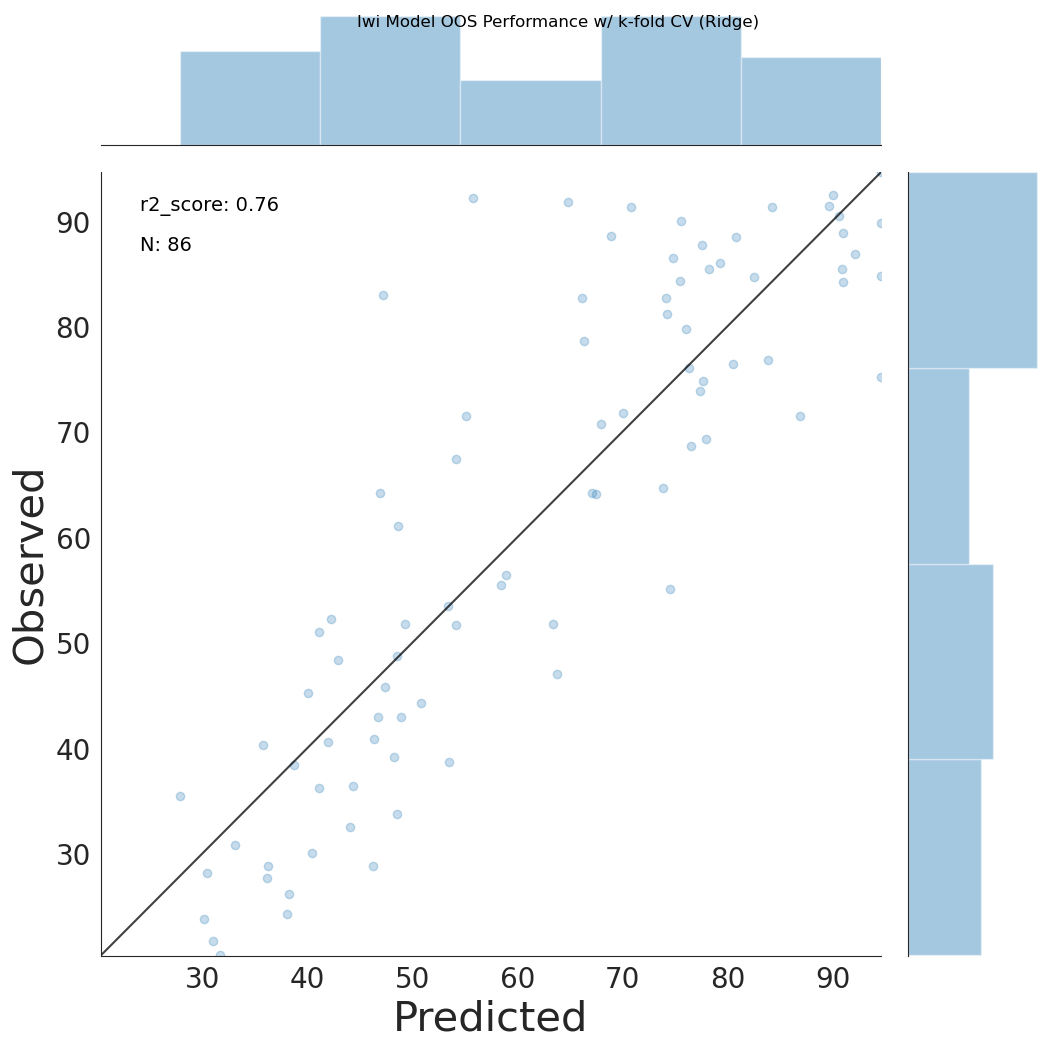

In [31]:
adm0_nl_kfold_dict = {}

for task in tasks:
    Y_train = train_df_adm0[task]
    if log_task[task]:
        Y_train = np.log(Y_train)
    
    adm0_nl_kfold_dict[task]  = cv_solve(task,
                                    X_nl_adm0 ,
                                    Y_train,
                                    clip_bounds = [np.min(Y_train), np.max(Y_train)],)

In [32]:
outpath = (data_dir + "model_data/"
           "dmsp_hist_bins_GPW_pop_weighted.pkl")

pickle.dump(adm0_nl_kfold_dict, open(outpath, "wb"))
adm0_nl_kfold_dict = pickle.load(open(outpath, "rb"))


### Now, we run the ADM0 model with RCF and NL

Sub-national HDI
Training model...

Rescaling X2 by 0.12589254117941673
0 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 0.30599496872071963
1 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 0.7437527275659047
2 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 1.0
3 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 1.807768676963435
4 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 4.393970560760792
5 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 10.680004325145758
6 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 

/shares/maps100/code/code_LS/hdi_downscaling/code/analysis/prediction_utils.py:342: UserWarning: Rescale X2 val is at max of range
  warnings.warn("Rescale X2 val is at max of range")


Expected years schooling
Training model...

Rescaling X2 by 0.12589254117941673
0 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 0.30599496872071963
1 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 0.7437527275659047
2 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 1.0
3 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 1.807768676963435
4 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 4.393970560760792
5 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 10.680004325145758
6 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on 

/shares/maps100/code/code_LS/hdi_downscaling/code/analysis/prediction_utils.py:342: UserWarning: Rescale X2 val is at max of range
  warnings.warn("Rescale X2 val is at max of range")


GNI per capita in thousands of US$ (2011 PPP)
Training model...

Rescaling X2 by 0.12589254117941673
0 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 0.30599496872071963
1 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 0.7437527275659047
2 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 1.0
3 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 1.807768676963435
4 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 4.393970560760792
5 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 10.680004325145758
6 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
o

/shares/maps100/code/code_LS/hdi_downscaling/code/analysis/prediction_utils.py:231: UserWarning: 58 missing values for outcome, these will be dropped
  warnings.warn(f"{num_missings} missing values for outcome, these will be dropped")


on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 0.30599496872071963
1 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 0.7437527275659047
2 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 1.0
3 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 1.807768676963435
4 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 4.393970560760792
5 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 10.680004325145758
6 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
Rescaling X2 by 25.958865861263956
7 out of 9
on fold (1 of 5): 
on fold (2 of 5): 
on fold (3

/shares/maps100/code/code_LS/hdi_downscaling/code/analysis/prediction_utils.py:342: UserWarning: Rescale X2 val is at max of range
  warnings.warn("Rescale X2 val is at max of range")


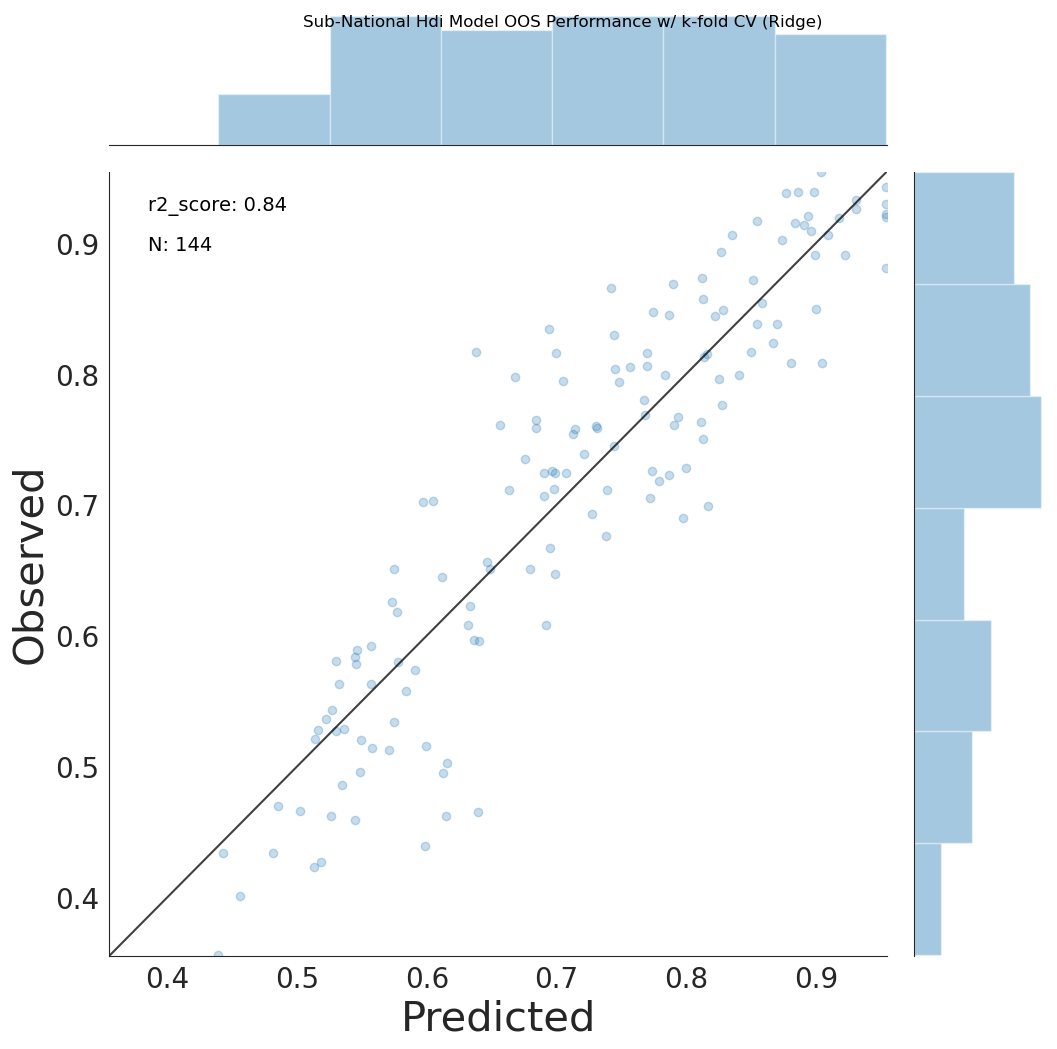

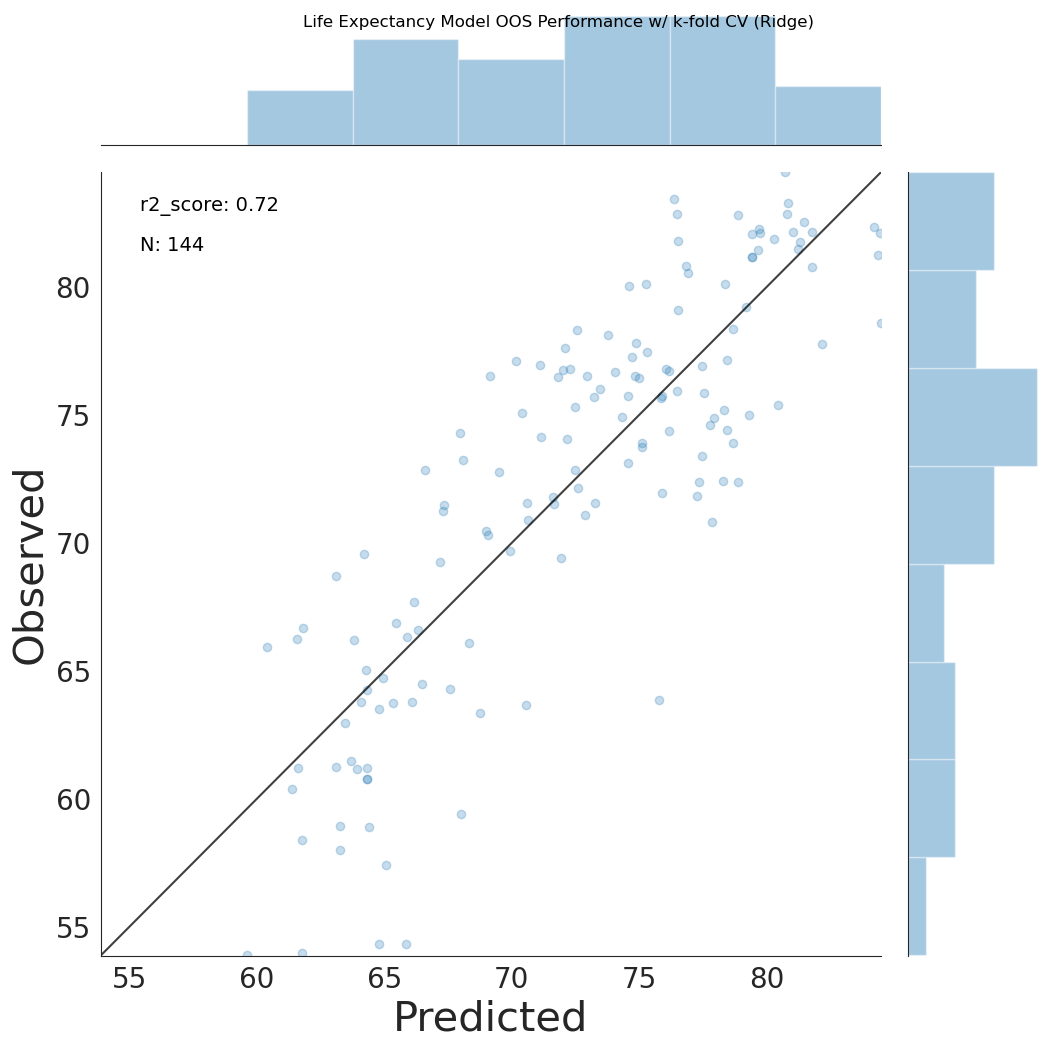

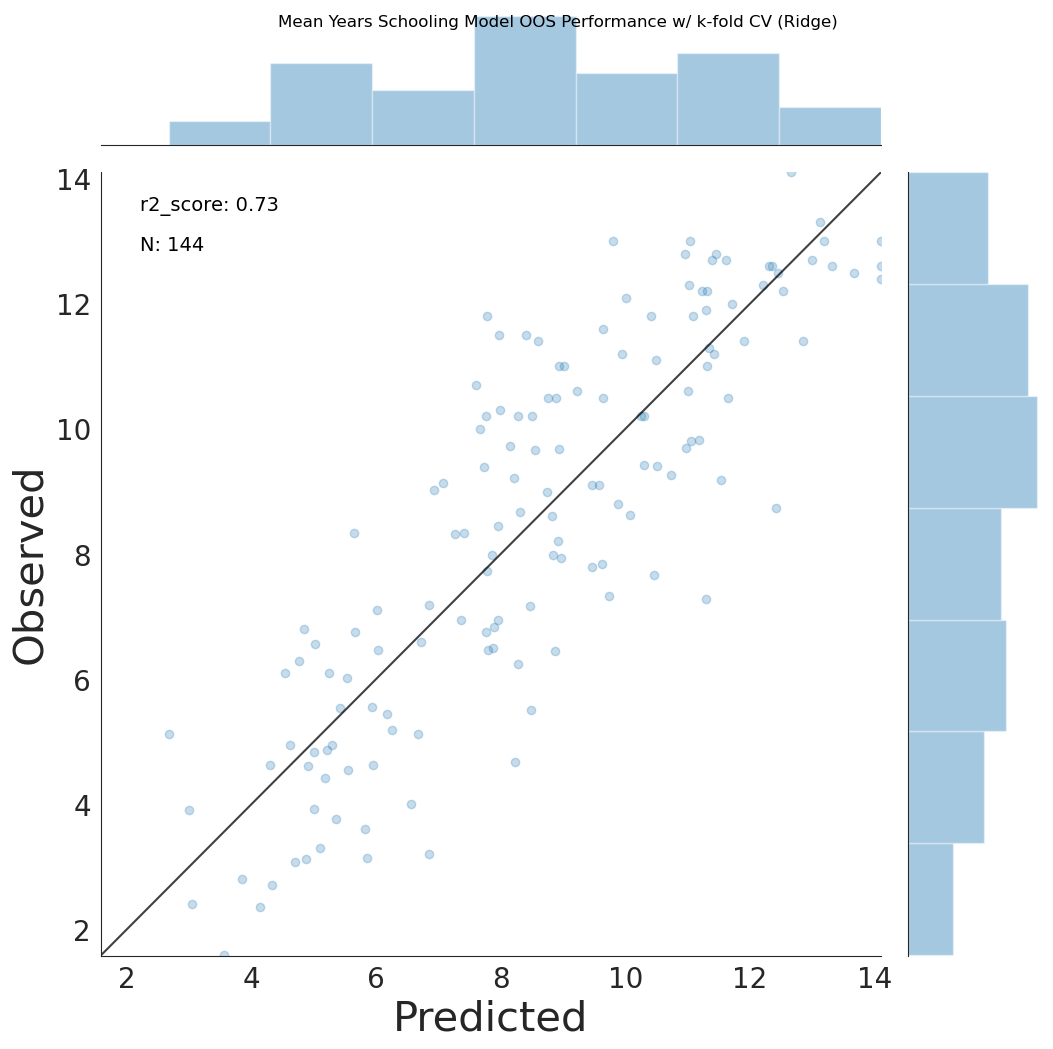

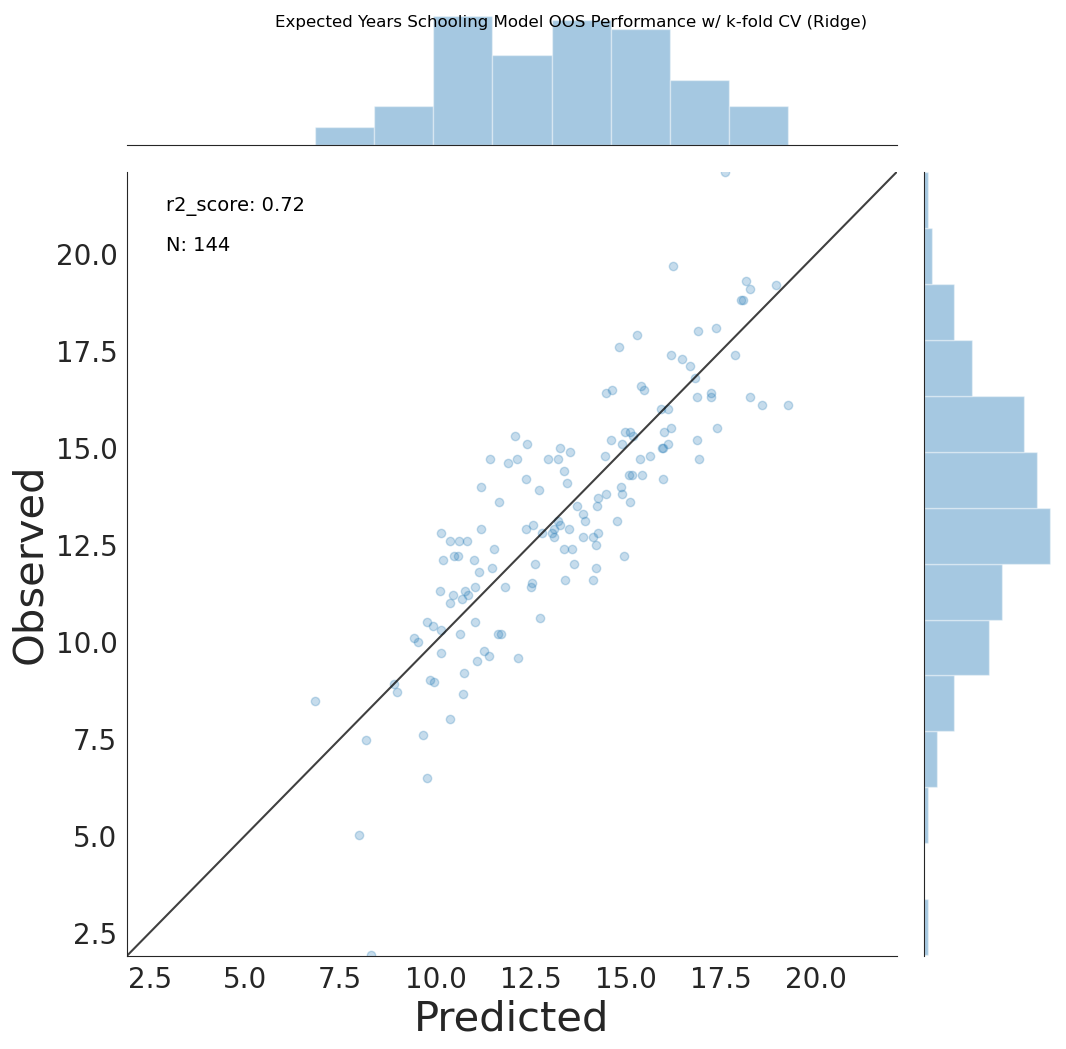

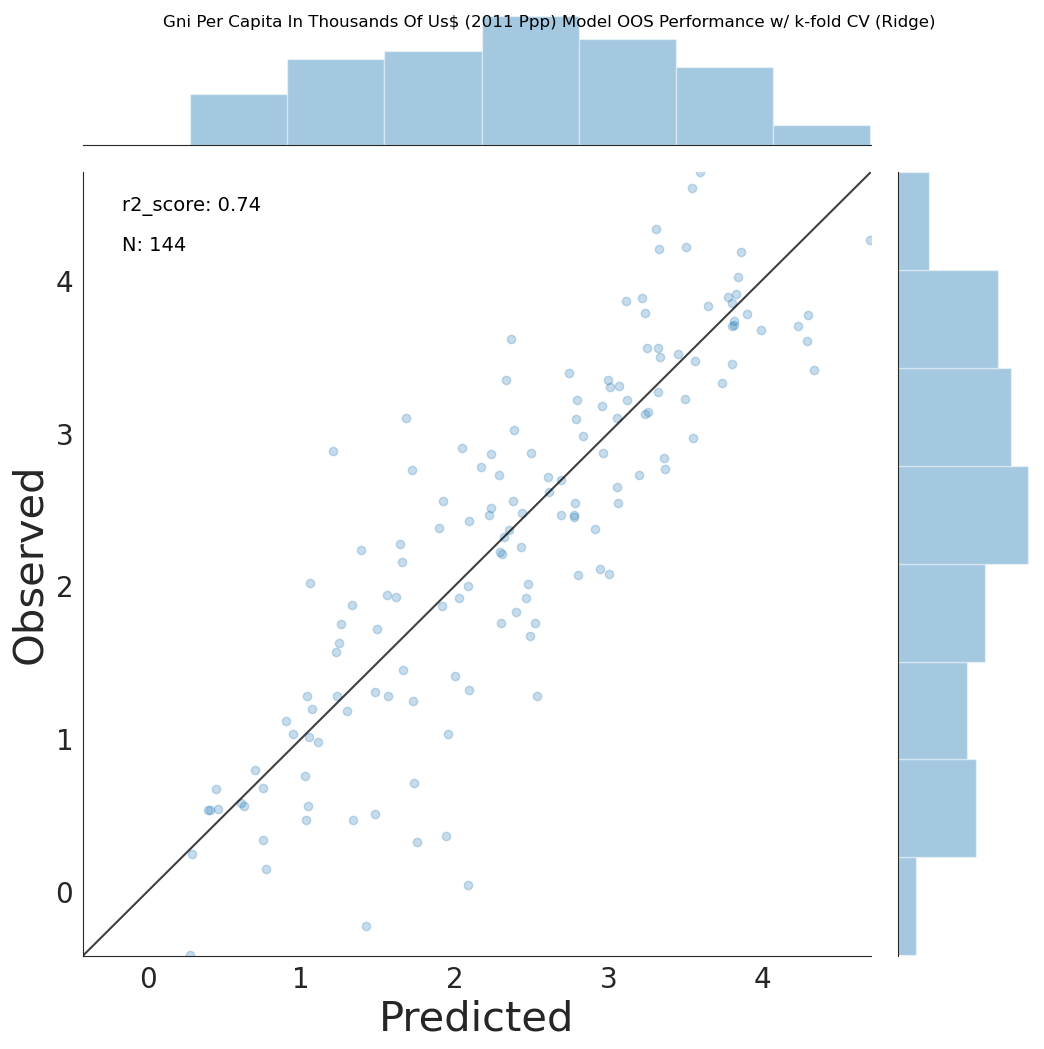

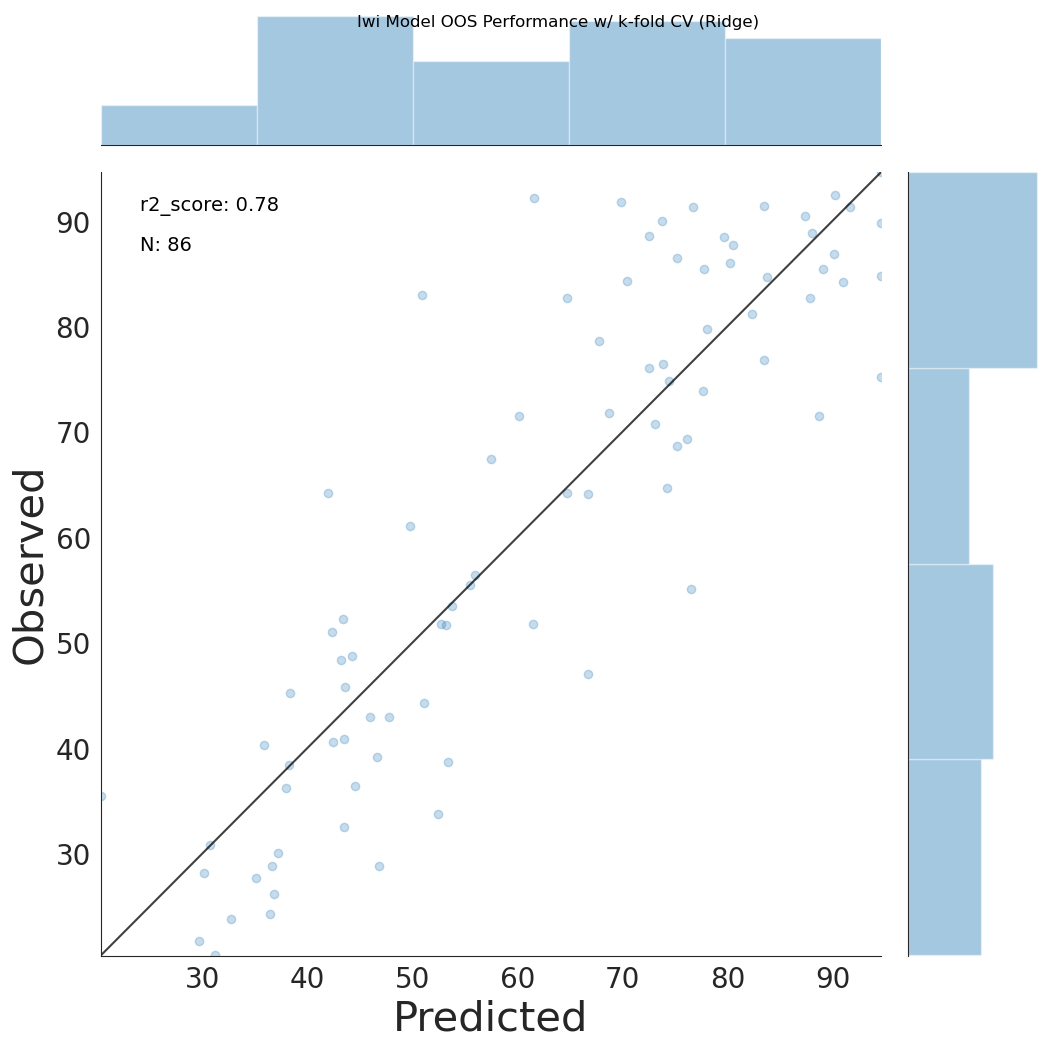

In [33]:
adm0_rcf_nl_kfold_dict = {}

for task in tasks:
    Y_train = train_df_adm0[task]
    if log_task[task]:
        Y_train = np.log(Y_train)
    
    adm0_rcf_nl_kfold_dict[task]  = cv_solve(task,
                                    X_train_adm0,
                                    Y_train,
                                    X_train2 = X_nl_adm0,
                                    lambdas2 = rescale_lambdas,         
                                    clip_bounds = [np.min(Y_train), np.max(Y_train)],)

In [34]:
outpath = (model_directory+
           "kfold_solve_adm0_level_pop_weighted_feats_rcf_nl_dmsp_hist_bins_GPW_pop_weighted.pkl")

pickle.dump(adm0_rcf_nl_kfold_dict, open(outpath, "wb"))
adm0_rcf_nl_kfold_dict = pickle.load(open(outpath, "rb"))


### Conduct Basic ADM0 to ADM1 Super Resolution Test

In [35]:
def run_preds_from_adm0_model_on_adm1_x(kfold_dict,task,X_for_pred,X_for_pred2=None):
    """
    This function runs predictions from an ADM0 model on an ADM1 observation.
    
    It also ensures that ADM1 predictions are done from the model where the parent country was out of sample.

    (We ensure the that our preds are from within the CV folds)
    
    """
    
    kfold_results = kfold_dict[task]
    best_lam_idx  = ir.interpret_kfold_results(kfold_results, crits="r2_score")[0][0][0]
    
    X_for_pred_countries = pd.Series(X_for_pred.index).apply(lambda x: x[:3])
    
    if X_for_pred2 is not None:
        X_for_pred2 = kfold_results["rescale_X2"] * X_for_pred2
        
        X_for_pred = pd.concat([X_for_pred,X_for_pred2],axis=1)
    
    stack = []
    for i, test_country_array in enumerate(kfold_results["locations_test"]):
        idx_bools = X_for_pred_countries.isin(test_country_array).to_numpy()
        test_set_df = X_for_pred[idx_bools]
        
        weights = kfold_results["models"][i][0][best_lam_idx]
        intercept = kfold_results["intercepts"][i][0][best_lam_idx]
        preds = test_set_df.dot(weights) + intercept
        stack.append(preds)
        
    output = pd.concat(stack).sort_index()
    output = output.clip(*kfold_results["clip_bounds"])
    
    return output

In [36]:
adm0_pred_adm1_rcf_perf_dict = {}
save_adm0_adm1_test_results = {}

for task in tasks:
    print(task)
    
    t = train_df[task].dropna()
    i = t.index
    p = run_preds_from_adm0_model_on_adm1_x(adm0_kfold_dict, task,X_train).loc[i]
    
    task_results = {"truth" : t, "preds": p, "index": i}
    save_adm0_adm1_test_results[task] = task_results
    
    adm0_pred_adm1_rcf_perf_dict[task] = get_within_perf_from_kfold_dict(None,task,metric="ALL",
                                                                          truth=t, preds=p)

Sub-national HDI
Life expectancy
Mean years schooling
Expected years schooling
GNI per capita in thousands of US$ (2011 PPP)
iwi


### Conduct Basic ADM0 to ADM1 Super Resolution Test with NL features

In [37]:
adm0_pred_adm1_nl_perf_dict = {}

for task in tasks:
    print(task)
    
    t = train_df[task].dropna()
    i = t.index
    p = run_preds_from_adm0_model_on_adm1_x(adm0_nl_kfold_dict, task,X_nl).loc[i]

    
    task_results = {"truth" : t, "preds": p, "index": i}
    save_adm0_adm1_test_results[task] = task_results
    
    adm0_pred_adm1_nl_perf_dict[task] = get_within_perf_from_kfold_dict(None,task,metric="ALL",
                                                                          truth=t, preds=p)

Sub-national HDI
Life expectancy
Mean years schooling
Expected years schooling
GNI per capita in thousands of US$ (2011 PPP)
iwi


### Conduct Basic ADM0 to ADM1 Super Resolution Test with RCF + NL feats

In [38]:
adm0_pred_adm1_rcf_nl_perf_dict = {}

for task in tasks:
    print(task)
    
    t = train_df[task].dropna()
    i = t.index
    p = run_preds_from_adm0_model_on_adm1_x(adm0_rcf_nl_kfold_dict, task,X_train,X_nl).loc[i]

    
    task_results = {"truth" : t, "preds": p, "index": i}
    save_adm0_adm1_test_results[task] = task_results
    
    adm0_pred_adm1_rcf_nl_perf_dict[task] = get_within_perf_from_kfold_dict(None,task,metric="ALL",
                                                                          truth=t, preds=p)

Sub-national HDI
Life expectancy
Mean years schooling
Expected years schooling
GNI per capita in thousands of US$ (2011 PPP)
iwi


## Summary Tables

In [39]:
rename_dict = {"pearson": "$\rho^{2}$", "spearman":"Spearman r", "r2":"$R^{2}$",
               "within_adm0_pearson": "$\rho^{2}$", "within_adm0_spearman":"Spearman r", "within_adm0_r2":"$R^{2}$",
    
}

In [40]:
def make_table_from_task(task, var_name=""):
    outcomes_dicts =[

    adm0_pred_adm1_rcf_perf_dict,
    adm0_pred_adm1_nl_perf_dict,
    adm0_pred_adm1_rcf_nl_perf_dict,

    cc_rcf_perf_dict,
    cc_nl_perf_dict,
    cc_nl_and_rcf_perf_dict,

    demean_rcf_perf_dict,
    demean_nl_perf_dict,
    demeaned_nl_and_rcf_demeaned_perf_dict

    ]

    outcomes = [outcome[task] for outcome in outcomes_dicts]

    table = pd.DataFrame(outcomes).round(2)
    table[table <= 0] = "$< 0$"

    table = table.rename(columns = rename_dict)

    table = table.rename(columns = rename_dict)

    table.loc[0:2,"HDI"] = "\textbf{Country level} " + "(n={:,})".format(n_adm0[task])
    table.loc[3:5,"HDI"] = "\textbf{Province level} " + "(n={:,})".format(n_adm1[task])
    table.loc[6:8,"HDI"] = "\textbf{Within-country} " + "(n={:,})".format(n_demean[task])

    table.loc[0:2,""] = ["\textbf{MOSAIKS}","\textbf{NL}","\textbf{MOSAIKS+NL}"]
    table.loc[3:5,""] = ["\textbf{MOSAIKS}","\textbf{NL}","\textbf{MOSAIKS+NL}"]
    table.loc[6:8,""] = ["\textbf{MOSAIKS}","\textbf{NL}","\textbf{MOSAIKS+NL}"]

    table.loc[9] = "\textbf{Predicted at province level}"


    table.loc[10] = "\emph{Full variation performance} " + "(n={:,})".format(n_adm1[task])
    table.iloc[10,3:6] = "\emph{Within-country performance} " + "(n={:,})".format(n_demean[task])
    
    table.drop(columns="Spearman r", inplace=True)
    
    table.loc[11] = ("(" + pd.Series(np.arange(1,table.shape[1]+1)).astype(str) +")").to_numpy()
    
    table = table.T.reset_index().set_index([9,10,"index",11])

    tab = table.T

    tab.columns.names = ([None, None, None,None])

    table = tab.set_index([tab.columns[-2],tab.columns[-1]])

    table.index.names =["\emph{ \textbf{" + var_name + " trained at:}}", "\emph{ \textbf{Features}}"]
    
    table = table.iloc[[8,6,7,5,3,4,2,0,1]]

    print(table.to_latex(bold_rows=False,column_format="ll||cc|cc",
          escape=False, multicolumn_format="c")  )

    return table



## HDI

In [41]:
make_table_from_task(tasks[0], var_name="HDI") #Make Table for HDI

\begin{tabular}{ll||cc|cc}
\toprule
                               &             & \multicolumn{4}{c}{\textbf{Predicted at province level}} \\
                               &             & \multicolumn{2}{c}{\emph{Full variation performance} (n=1,363)} & \multicolumn{2}{c}{\emph{Within-country performance} (n=1,344)} \\
                               &             &                                  $\rho^{2}$ & $R^{2}$ &                                  $\rho^{2}$ & $R^{2}$ \\
                               &             &                                         (1) &     (2) &                                         (3) &     (4) \\
\emph{ \textbf{HDI trained at:}} & \emph{ \textbf{Features}} &                                             &         &                                             &         \\
\midrule
\textbf{Within-country} (n=1,344) & \textbf{MOSAIKS+NL} &                                        0.96 &    0.96 &                                        0.46 &    0.46 \\
 

\textbf{Predicted at province level}  \
                                                            \emph{Full variation performance} (n=1,363)   
                                                                                             $\rho^{2}$   
                                                                                                    (1)   
\emph{ \textbf{HDI trained at:}}  \emph{ \textbf{Features}}                                               
\textbf{Within-country} (n=1,344) \textbf{MOSAIKS+NL}                                              0.96   
                                  \textbf{MOSAIKS}                                                 0.95   
                                  \textbf{NL}                                                      0.95   
\textbf{Province level} (n=1,363) \textbf{MOSAIKS+NL}                                              0.79   
                                  \textbf{MOSAIKS}                                                 0.72   
                                  \textbf{NL}                                                      0.58   
\textbf{Country level} (n=144)    \textbf{MOSAIKS+NL}                                              0.71   
                                  \textbf{MOSAIKS}                                                  0.6   
                                  \textbf{NL}                                                      0.59   

                                                                     \
                                                                      
                                                            $R^{2}$   
                                                                (2)   
\emph{ \textbf{HDI trained at:}}  \emph{ \textbf{Features}}           
\textbf{Within-country} (n=1,344) \textbf{MOSAIKS+NL}          0.96   
                                  \textbf{MOSAIKS}             0.95   
                                  \textbf{NL}                  0.95   
\textbf{Province level} (n=1,363) \textbf{MOSAIKS+NL}          0.79   
                                  \textbf{MOSAIKS}             0.72   
                                  \textbf{NL}                  0.58   
\textbf{Country level} (n=144)    \textbf{MOSAIKS+NL}          0.69   
                                  \textbf{MOSAIKS}             0.58   
                                  \textbf{NL}                   0.5   

                                                                                                         \
                                                            \emph{Within-country performance} (n=1,344)   
                                                                                             $\rho^{2}$   
                                                                                                    (3)   
\emph{ \textbf{HDI trained at:}}  \emph{ \textbf{Features}}                                               
\textbf{Within-country} (n=1,344) \textbf{MOSAIKS+NL}                                              0.46   
                                  \textbf{MOSAIKS}                                                 0.35   
                                  \textbf{NL}                                                      0.39   
\textbf{Province level} (n=1,363) \textbf{MOSAIKS+NL}                                              0.36   
                                  \textbf{MOSAIKS}                                                 0.23   
                                  \textbf{NL}                                                      0.38   
\textbf{Country level} (n=144)    \textbf{MOSAIKS+NL}                                               0.4   
                                  \textbf{MOSAIKS}                                                 0.15   
                                  \textbf{NL}                                                      0.38   

                                                                     
    

### Life expectancy table

In [42]:
task = tasks[1]

In [43]:
make_table_from_task(tasks[1], "Life expectancy")

\begin{tabular}{ll||cc|cc}
\toprule
                               &             & \multicolumn{4}{c}{\textbf{Predicted at province level}} \\
                               &             & \multicolumn{2}{c}{\emph{Full variation performance} (n=1,363)} & \multicolumn{2}{c}{\emph{Within-country performance} (n=1,344)} \\
                               &             &                                  $\rho^{2}$ & $R^{2}$ &                                  $\rho^{2}$ & $R^{2}$ \\
                               &             &                                         (1) &     (2) &                                         (3) &     (4) \\
\emph{ \textbf{Life expectancy trained at:}} & \emph{ \textbf{Features}} &                                             &         &                                             &         \\
\midrule
\textbf{Within-country} (n=1,344) & \textbf{MOSAIKS+NL} &                                        0.93 &    0.93 &                                        0.07 & 

\textbf{Predicted at province level}  \
                                                                       \emph{Full variation performance} (n=1,363)   
                                                                                                        $\rho^{2}$   
                                                                                                               (1)   
\emph{ \textbf{Life expectancy trained at:}} \emph{ \textbf{Features}}                                               
\textbf{Within-country} (n=1,344)            \textbf{MOSAIKS+NL}                                              0.93   
                                             \textbf{MOSAIKS}                                                 0.93   
                                             \textbf{NL}                                                      0.93   
\textbf{Province level} (n=1,363)            \textbf{MOSAIKS+NL}                                              0.68   
                                             \textbf{MOSAIKS}                                                 0.66   
                                             \textbf{NL}                                                      0.42   
\textbf{Country level} (n=144)               \textbf{MOSAIKS+NL}                                              0.54   
                                             \textbf{MOSAIKS}                                                 0.49   
                                             \textbf{NL}                                                      0.44   

                                                                                \
                                                                                 
                                                                       $R^{2}$   
                                                                           (2)   
\emph{ \textbf{Life expectancy trained at:}} \emph{ \textbf{Features}}           
\textbf{Within-country} (n=1,344)            \textbf{MOSAIKS+NL}          0.93   
                                             \textbf{MOSAIKS}             0.93   
                                             \textbf{NL}                  0.93   
\textbf{Province level} (n=1,363)            \textbf{MOSAIKS+NL}          0.68   
                                             \textbf{MOSAIKS}             0.66   
                                             \textbf{NL}                  0.42   
\textbf{Country level} (n=144)               \textbf{MOSAIKS+NL}          0.47   
                                             \textbf{MOSAIKS}             0.46   
                                             \textbf{NL}                  0.36   

                                                                                                                    \
                                                                       \emph{Within-country performance} (n=1,344)   
                                                                                                        $\rho^{2}$   
                                                                                                               (3)   
\emph{ \textbf{Life expectancy trained at:}} \emph{ \textbf{Features}}                                               
\textbf{Within-country} (n=1,344)            \textbf{MOSAIKS+NL}                                              0.07   
                                             \textbf{MOSAIKS}                                                 0.02   
                                             \textbf{NL}                                                      0.07   
\textbf{Province level} (n=1,363)            \textbf{MOSAIKS+NL}                                              0.03   
                                             \textbf{MOSAIKS}                                                 0.02   
                                             \textbf{NL}                                        

### Mean years schooling

In [44]:
make_table_from_task(tasks[2], "Mean years schooling")

\begin{tabular}{ll||cc|cc}
\toprule
                               &             & \multicolumn{4}{c}{\textbf{Predicted at province level}} \\
                               &             & \multicolumn{2}{c}{\emph{Full variation performance} (n=1,363)} & \multicolumn{2}{c}{\emph{Within-country performance} (n=1,344)} \\
                               &             &                                  $\rho^{2}$ & $R^{2}$ &                                  $\rho^{2}$ & $R^{2}$ \\
                               &             &                                         (1) &     (2) &                                         (3) &     (4) \\
\emph{ \textbf{Mean years schooling trained at:}} & \emph{ \textbf{Features}} &                                             &         &                                             &         \\
\midrule
\textbf{Within-country} (n=1,344) & \textbf{MOSAIKS+NL} &                                        0.93 &    0.93 &                                        0.

\textbf{Predicted at province level}  \
                                                                            \emph{Full variation performance} (n=1,363)   
                                                                                                             $\rho^{2}$   
                                                                                                                    (1)   
\emph{ \textbf{Mean years schooling trained at:}} \emph{ \textbf{Features}}                                               
\textbf{Within-country} (n=1,344)                 \textbf{MOSAIKS+NL}                                              0.93   
                                                  \textbf{MOSAIKS}                                                 0.91   
                                                  \textbf{NL}                                                      0.92   
\textbf{Province level} (n=1,363)                 \textbf{MOSAIKS+NL}                                              0.69   
                                                  \textbf{MOSAIKS}                                                 0.63   
                                                  \textbf{NL}                                                      0.52   
\textbf{Country level} (n=144)                    \textbf{MOSAIKS+NL}                                              0.65   
                                                  \textbf{MOSAIKS}                                                 0.54   
                                                  \textbf{NL}                                                      0.53   

                                                                                     \
                                                                                      
                                                                            $R^{2}$   
                                                                                (2)   
\emph{ \textbf{Mean years schooling trained at:}} \emph{ \textbf{Features}}           
\textbf{Within-country} (n=1,344)                 \textbf{MOSAIKS+NL}          0.93   
                                                  \textbf{MOSAIKS}             0.91   
                                                  \textbf{NL}                  0.92   
\textbf{Province level} (n=1,363)                 \textbf{MOSAIKS+NL}          0.69   
                                                  \textbf{MOSAIKS}             0.62   
                                                  \textbf{NL}                  0.52   
\textbf{Country level} (n=144)                    \textbf{MOSAIKS+NL}          0.63   
                                                  \textbf{MOSAIKS}             0.51   
                                                  \textbf{NL}                  0.52   

                                                                                                                         \
                                                                            \emph{Within-country performance} (n=1,344)   
                                                                                                             $\rho^{2}$   
                                                                                                                    (3)   
\emph{ \textbf{Mean years schooling trained at:}} \emph{ \textbf{Features}}                                               
\textbf{Within-country} (n=1,344)                 \textbf{MOSAIKS+NL}                                              0.48   
                                                  \textbf{MOSAIKS}                                                 0.37   
                                                  \textbf{NL}                                                      0.39   
\textbf{Province level} (n=1,363)                 \textbf{MOSAIKS+NL}                                              0.33   
                                  

### Expected years schooling

In [45]:
make_table_from_task(tasks[3], "Expected years schooling")

\begin{tabular}{ll||cc|cc}
\toprule
                               &             & \multicolumn{4}{c}{\textbf{Predicted at province level}} \\
                               &             & \multicolumn{2}{c}{\emph{Full variation performance} (n=1,363)} & \multicolumn{2}{c}{\emph{Within-country performance} (n=1,344)} \\
                               &             &                                  $\rho^{2}$ & $R^{2}$ &                                  $\rho^{2}$ & $R^{2}$ \\
                               &             &                                         (1) &     (2) &                                         (3) &     (4) \\
\emph{ \textbf{Expected years schooling trained at:}} & \emph{ \textbf{Features}} &                                             &         &                                             &         \\
\midrule
\textbf{Within-country} (n=1,344) & \textbf{MOSAIKS+NL} &                                         0.9 &     0.9 &                                      

\textbf{Predicted at province level}  \
                                                                             \emph{Full variation performance} (n=1,363)   
                                                                                                              $\rho^{2}$   
                                                                                                                     (1)   
\emph{ \textbf{Expected years schooling trained... \emph{ \textbf{Features}}                                               
\textbf{Within-country} (n=1,344)                  \textbf{MOSAIKS+NL}                                               0.9   
                                                   \textbf{MOSAIKS}                                                 0.89   
                                                   \textbf{NL}                                                      0.89   
\textbf{Province level} (n=1,363)                  \textbf{MOSAIKS+NL}                                              0.58   
                                                   \textbf{MOSAIKS}                                                 0.56   
                                                   \textbf{NL}                                                      0.42   
\textbf{Country level} (n=144)                     \textbf{MOSAIKS+NL}                                              0.52   
                                                   \textbf{MOSAIKS}                                                 0.49   
                                                   \textbf{NL}                                                      0.42   

                                                                                      \
                                                                                       
                                                                             $R^{2}$   
                                                                                 (2)   
\emph{ \textbf{Expected years schooling trained... \emph{ \textbf{Features}}           
\textbf{Within-country} (n=1,344)                  \textbf{MOSAIKS+NL}           0.9   
                                                   \textbf{MOSAIKS}             0.89   
                                                   \textbf{NL}                  0.89   
\textbf{Province level} (n=1,363)                  \textbf{MOSAIKS+NL}          0.58   
                                                   \textbf{MOSAIKS}             0.56   
                                                   \textbf{NL}                  0.42   
\textbf{Country level} (n=144)                     \textbf{MOSAIKS+NL}          0.46   
                                                   \textbf{MOSAIKS}             0.46   
                                                   \textbf{NL}                  0.37   

                                                                                                                          \
                                                                             \emph{Within-country performance} (n=1,344)   
                                                                                                              $\rho^{2}$   
                                                                                                                     (3)   
\emph{ \textbf{Expected years schooling trained... \emph{ \textbf{Features}}                                               
\textbf{Within-country} (n=1,344)                  \textbf{MOSAIKS+NL}                                              0.23   
                                                   \textbf{MOSAIKS}                                                 0.19   
                                                   \textbf{NL}                                                      0.13   
\textbf{Province level} (n=1,363)                  \textbf{MOSAIKS+NL}                                              0.17  

### GNI

In [46]:
make_table_from_task(tasks[4], "GNIpc")

\begin{tabular}{ll||cc|cc}
\toprule
                               &             & \multicolumn{4}{c}{\textbf{Predicted at province level}} \\
                               &             & \multicolumn{2}{c}{\emph{Full variation performance} (n=1,363)} & \multicolumn{2}{c}{\emph{Within-country performance} (n=1,344)} \\
                               &             &                                  $\rho^{2}$ & $R^{2}$ &                                  $\rho^{2}$ & $R^{2}$ \\
                               &             &                                         (1) &     (2) &                                         (3) &     (4) \\
\emph{ \textbf{GNIpc trained at:}} & \emph{ \textbf{Features}} &                                             &         &                                             &         \\
\midrule
\textbf{Within-country} (n=1,344) & \textbf{MOSAIKS+NL} &                                        0.96 &    0.96 &                                        0.46 &    0.46 \\

\textbf{Predicted at province level}  \
                                                             \emph{Full variation performance} (n=1,363)   
                                                                                              $\rho^{2}$   
                                                                                                     (1)   
\emph{ \textbf{GNIpc trained at:}} \emph{ \textbf{Features}}                                               
\textbf{Within-country} (n=1,344)  \textbf{MOSAIKS+NL}                                              0.96   
                                   \textbf{MOSAIKS}                                                 0.95   
                                   \textbf{NL}                                                      0.96   
\textbf{Province level} (n=1,363)  \textbf{MOSAIKS+NL}                                              0.71   
                                   \textbf{MOSAIKS}                                                 0.62   
                                   \textbf{NL}                                                      0.56   
\textbf{Country level} (n=144)     \textbf{MOSAIKS+NL}                                              0.54   
                                   \textbf{MOSAIKS}                                                 0.42   
                                   \textbf{NL}                                                       0.4   

                                                                      \
                                                                       
                                                             $R^{2}$   
                                                                 (2)   
\emph{ \textbf{GNIpc trained at:}} \emph{ \textbf{Features}}           
\textbf{Within-country} (n=1,344)  \textbf{MOSAIKS+NL}          0.96   
                                   \textbf{MOSAIKS}             0.95   
                                   \textbf{NL}                  0.96   
\textbf{Province level} (n=1,363)  \textbf{MOSAIKS+NL}          0.71   
                                   \textbf{MOSAIKS}             0.61   
                                   \textbf{NL}                  0.56   
\textbf{Country level} (n=144)     \textbf{MOSAIKS+NL}         $< 0$   
                                   \textbf{MOSAIKS}            $< 0$   
                                   \textbf{NL}                 $< 0$   

                                                                                                          \
                                                             \emph{Within-country performance} (n=1,344)   
                                                                                              $\rho^{2}$   
                                                                                                     (3)   
\emph{ \textbf{GNIpc trained at:}} \emph{ \textbf{Features}}                                               
\textbf{Within-country} (n=1,344)  \textbf{MOSAIKS+NL}                                              0.46   
                                   \textbf{MOSAIKS}                                                 0.31   
                                   \textbf{NL}                                                      0.45   
\textbf{Province level} (n=1,363)  \textbf{MOSAIKS+NL}                                              0.38   
                                   \textbf{MOSAIKS}                                                 0.18   
                                   \textbf{NL}                                                      0.43   
\textbf{Country level} (n=144)     \textbf{MOSAIKS+NL}                                              0.17   
                                   \textbf{MOSAIKS}                                                 0.06   
                                   \textbf{NL}                                                      0.16   

                                 

### IWI

In [47]:
make_table_from_task(tasks[5], "IWI")

\begin{tabular}{ll||cc|cc}
\toprule
                              &             & \multicolumn{4}{c}{\textbf{Predicted at province level}} \\
                              &             & \multicolumn{2}{c}{\emph{Full variation performance} (n=864)} & \multicolumn{2}{c}{\emph{Within-country performance} (n=863)} \\
                              &             &                                $\rho^{2}$ & $R^{2}$ &                                $\rho^{2}$ & $R^{2}$ \\
                              &             &                                       (1) &     (2) &                                       (3) &     (4) \\
\emph{ \textbf{IWI trained at:}} & \emph{ \textbf{Features}} &                                           &         &                                           &         \\
\midrule
\textbf{Within-country} (n=863) & \textbf{MOSAIKS+NL} &                                      0.92 &    0.92 &                                       0.5 &     0.5 \\
                           

\textbf{Predicted at province level}  \
                                                           \emph{Full variation performance} (n=864)   
                                                                                          $\rho^{2}$   
                                                                                                 (1)   
\emph{ \textbf{IWI trained at:}} \emph{ \textbf{Features}}                                             
\textbf{Within-country} (n=863)  \textbf{MOSAIKS+NL}                                            0.92   
                                 \textbf{MOSAIKS}                                                0.9   
                                 \textbf{NL}                                                    0.92   
\textbf{Province level} (n=864)  \textbf{MOSAIKS+NL}                                            0.68   
                                 \textbf{MOSAIKS}                                               0.56   
                                 \textbf{NL}                                                    0.58   
\textbf{Country level} (n=86)    \textbf{MOSAIKS+NL}                                            0.61   
                                 \textbf{MOSAIKS}                                               0.34   
                                 \textbf{NL}                                                     0.6   

                                                                    \
                                                                     
                                                           $R^{2}$   
                                                               (2)   
\emph{ \textbf{IWI trained at:}} \emph{ \textbf{Features}}           
\textbf{Within-country} (n=863)  \textbf{MOSAIKS+NL}          0.92   
                                 \textbf{MOSAIKS}              0.9   
                                 \textbf{NL}                  0.92   
\textbf{Province level} (n=864)  \textbf{MOSAIKS+NL}          0.67   
                                 \textbf{MOSAIKS}             0.55   
                                 \textbf{NL}                  0.58   
\textbf{Country level} (n=86)    \textbf{MOSAIKS+NL}          0.52   
                                 \textbf{MOSAIKS}             0.23   
                                 \textbf{NL}                   0.5   

                                                                                                      \
                                                           \emph{Within-country performance} (n=863)   
                                                                                          $\rho^{2}$   
                                                                                                 (3)   
\emph{ \textbf{IWI trained at:}} \emph{ \textbf{Features}}                                             
\textbf{Within-country} (n=863)  \textbf{MOSAIKS+NL}                                             0.5   
                                 \textbf{MOSAIKS}                                               0.32   
                                 \textbf{NL}                                                     0.5   
\textbf{Province level} (n=864)  \textbf{MOSAIKS+NL}                                            0.41   
                                 \textbf{MOSAIKS}                                               0.23   
                                 \textbf{NL}                                                    0.49   
\textbf{Country level} (n=86)    \textbf{MOSAIKS+NL}                                            0.48   
                                 \textbf{MOSAIKS}                                               0.09   
                                 \textbf{NL}                                                     0.5   

                                                                    
                                                                    
                               